In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/DAT410')

Mounted at /content/drive


In [2]:
# Other libraries
import pandas as pd
import numpy as np
import glob

In [3]:
import matplotlib.pyplot as plt
!pip install rasterio
import rasterio as rio
import rasterio
from rasterio.transform import xy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 30.7 MB/s eta 0:00:00


In [ ]:
!unzip '/content/drive/My Drive/DAT410/Potsdam-GeoTif.zip' -d '/content/drive/My Drive/DAT410/'


unzip:  cannot find or open /content/drive/My Drive/DAT410/Potsdam-GeoTif.zip, /content/drive/My Drive/DAT410/Potsdam-GeoTif.zip.zip or /content/drive/My Drive/DAT410/Potsdam-GeoTif.zip.ZIP.


In [4]:
PathToGeoTiffFile = "Potsdam-GeoTif"
blob = PathToGeoTiffFile +  '/0000000672-0000033824.tif'

In [5]:
img = rio.open(blob)
img_array = img.read()
imtransform = img.transform
nRows = img_array.shape[1]
ncols = img_array.shape[2]
Bands = img_array.shape[0]

img_array = img_array.reshape(Bands, nRows*ncols).T
img_array = img_array.reshape( nRows,ncols, Bands)

Text(0.5, 1.0, 'Input image')

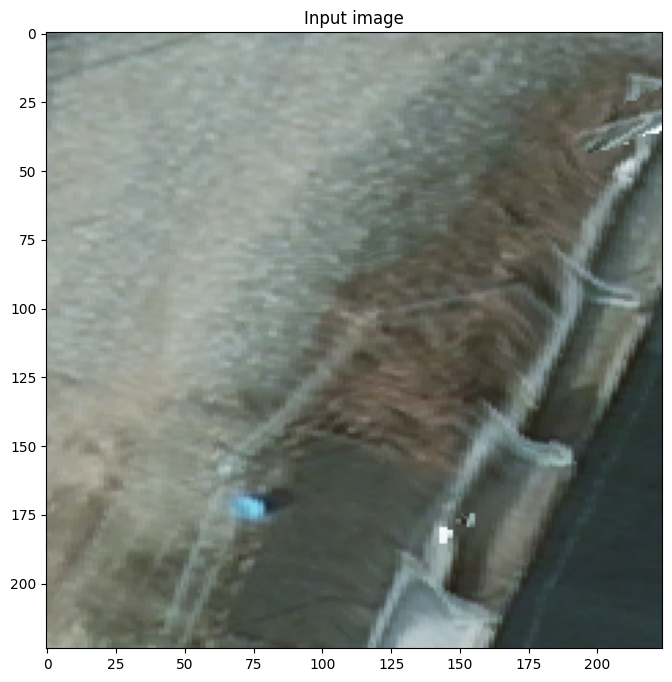

In [ ]:
plt.figure(figsize=(24,8))

plt.imshow(img_array[:,:,0:3]/255)
plt.title('Input image')

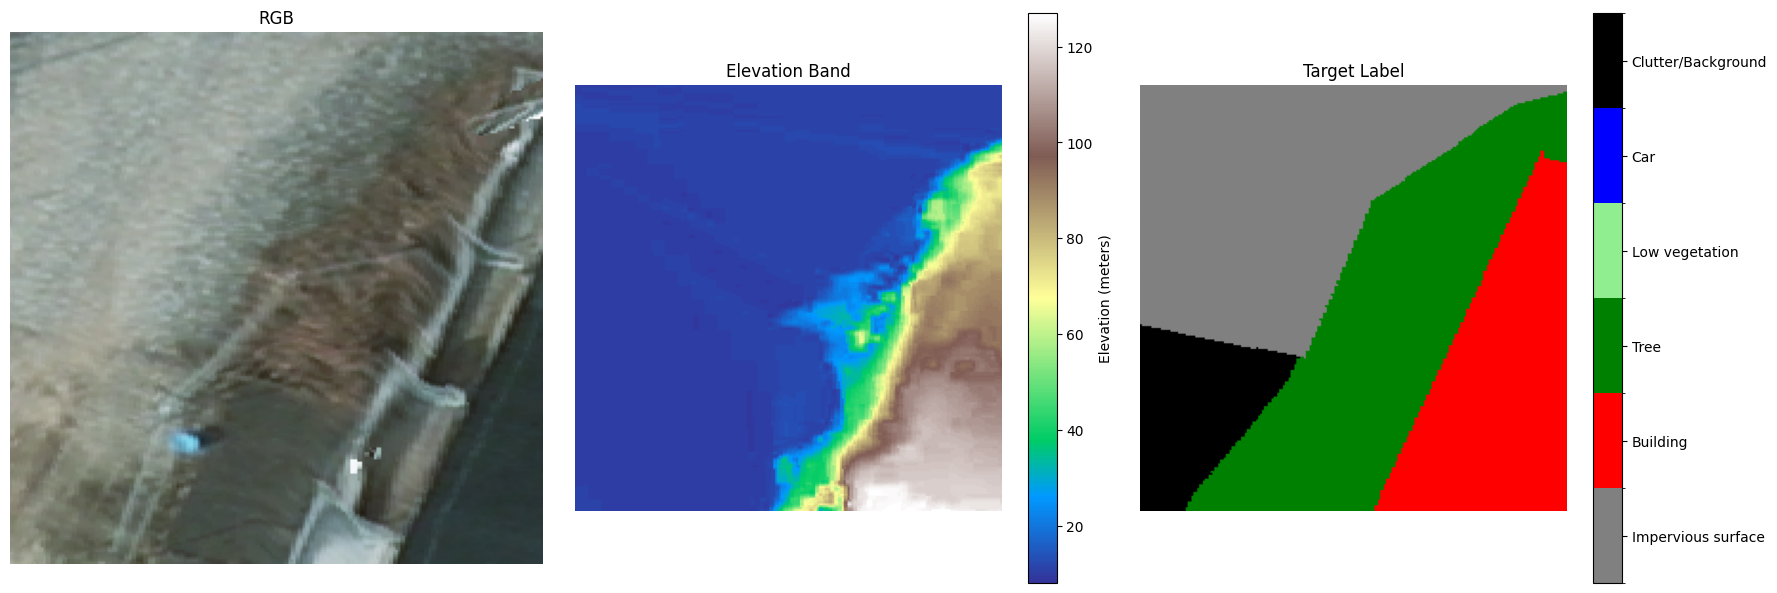

In [6]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open the image file
with rasterio.open(blob) as src:
    # Read the bands
    red = src.read(1)  # Red band
    green = src.read(2)  # Green band
    blue = src.read(3)  # Blue band
    infrared = src.read(4)  # Infrared band
    elevation = src.read(5)  # Elevation band
    target = src.read(6)  # Target label band

# Create RGB composite
rgb = np.stack([red, green, blue], axis=-1)
rgb_normalized = (rgb / rgb.max() * 255).astype(np.uint8)  # Normalize to 8-bit

# Prepare figure
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# RGB Visualization
axes[0].imshow(rgb_normalized)
axes[0].set_title('RGB', fontsize=12)
axes[0].axis('off')

# Elevation Visualization
elevation = elevation.squeeze()
elev_plot = axes[1].imshow(elevation, cmap='terrain')
plt.colorbar(elev_plot, ax=axes[1], label='Elevation (meters)')
axes[1].set_title('Elevation Band', fontsize=12)
axes[1].axis('off')

# Target Label Visualization
target = target.squeeze().astype(int)
unique_labels = np.unique(target)
num_classes = len(unique_labels)

# Class names and colors (all six classes)
class_names = ['Impervious surface', 'Building', 'Tree', 'Low vegetation', 'Car', 'Clutter/Background']
colors = ['gray', 'red', 'green', 'lightgreen', 'blue', 'black']

# Create discrete colormap for all six classes
cmap = ListedColormap(colors)
bounds = np.arange(len(class_names) + 1) - 0.5  # Use len(class_names) instead of num_classes
norm = BoundaryNorm(bounds, cmap.N)

# Plot the target labels
label_plot = axes[2].imshow(target, cmap=cmap, norm=norm)

# Create colorbar with all six classes
cbar = plt.colorbar(label_plot, ax=axes[2], ticks=np.arange(len(class_names)))
cbar.set_ticklabels(class_names)
axes[2].set_title('Target Label', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [7]:
import os
import random
from sklearn.model_selection import KFold
from shutil import copyfile

# Path to the directory containing GeoTIFF files
PathToGeoTiffFile = "Potsdam-GeoTif"

# Output folder for 5-fold splits
output_folder = "Potsdam-5Fold-Splits"
os.makedirs(output_folder, exist_ok=True)

# Step 1: Read all GeoTIFF file paths
all_files = [os.path.join(PathToGeoTiffFile, f) for f in os.listdir(PathToGeoTiffFile) if f.endswith(".tif")]

# Step 2: Randomly sample at least 10,000 images
random.seed(42)  # Ensure reproducibility
sampled_files = random.sample(all_files, 10000)  # Extract 10,000 samples

# Step 3: Split into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (_, fold_idx) in enumerate(kf.split(sampled_files)):
    fold_folder = os.path.join(output_folder, f"fold_{fold}")
    os.makedirs(fold_folder, exist_ok=True)

    # Copy files for this fold
    for idx in fold_idx:
        src = sampled_files[idx]
        dst = os.path.join(fold_folder, os.path.basename(src))
        copyfile(src, dst)

    print(f"Fold {fold} prepared: {len(fold_idx)} files")

print(f"5-Fold splits saved in: {output_folder}")

Fold 0 prepared: 2000 files
Fold 1 prepared: 2000 files
Fold 2 prepared: 2000 files
Fold 3 prepared: 2000 files
Fold 4 prepared: 2000 files
5-Fold splits saved in: Potsdam-5Fold-Splits


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PotsdamDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.file_list = [f for f in os.listdir(folder_path) if f.endswith('.tif')]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.file_list[idx])
        with rasterio.open(img_path) as src:
            img = src.read()  # (C, H, W)

        label = img[-1, :, :]  # (H, W)
        img = img[0:4, :, :]   # (4, H, W)

        # 转换为 (H, W, C) 以适应 ToTensor()
        img = np.transpose(img, (1, 2, 0))  # (H, W, 4)

        if self.transform:
            img = self.transform(img)  # ToTensor() 转换为 (4, H, W)
        else:
            img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)  # (C, H, W)

        label = torch.tensor(label, dtype=torch.long)
        return img, label

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=3, padding='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 6, kernel_size=3, padding='same')
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.softmax(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
])

from torch.utils.data import DataLoader, ConcatDataset

# 合并数据集
train_folders = [
    'Potsdam-5Fold-Splits/fold_0',
    'Potsdam-5Fold-Splits/fold_1',
    'Potsdam-5Fold-Splits/fold_2'
]
train_datasets = [PotsdamDataset(folder, transform=transform) for folder in train_folders]
train_dataset = ConcatDataset(train_datasets)

# 创建 DataLoader，设置 shuffle=True
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True)
val_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_3', transform=transform)
test_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_4', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# 验证输入形状
for inputs, labels in train_loader:
    print("修正后输入形状:", inputs.shape)  # [8, 4, 224, 224]
    print("修正后标签形状:", labels.shape)  # [8, 224, 224]
    break

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.numel()
            correct_train += (predicted == labels).sum().item()
            print(labels.numel()==labels.size(1)*labels.size(2)*8)


        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.numel()
                correct_val += (predicted == labels).sum().item()


        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

修正后输入形状: torch.Size([8, 4, 224, 224])
修正后标签形状: torch.Size([8, 224, 224])


  0%|          | 1/750 [00:01<19:34,  1.57s/it]

True


  0%|          | 2/750 [00:03<19:38,  1.58s/it]

True


  0%|          | 3/750 [00:04<19:59,  1.61s/it]

True


  1%|          | 4/750 [00:06<20:57,  1.69s/it]

True


  1%|          | 5/750 [00:08<20:40,  1.67s/it]

True


  1%|          | 6/750 [00:09<20:01,  1.61s/it]

True


  1%|          | 7/750 [00:31<1:41:55,  8.23s/it]

True


  1%|          | 8/750 [00:32<1:14:01,  5.99s/it]

True


  1%|          | 9/750 [00:34<57:08,  4.63s/it]  

True


  1%|▏         | 10/750 [00:39<58:04,  4.71s/it]

True


  1%|▏         | 11/750 [00:41<50:03,  4.06s/it]

True


  2%|▏         | 12/750 [00:43<42:12,  3.43s/it]

True


  2%|▏         | 13/750 [00:45<34:41,  2.82s/it]

True


  2%|▏         | 14/750 [01:06<1:41:47,  8.30s/it]

True


  2%|▏         | 15/750 [01:13<1:39:32,  8.13s/it]

True


  2%|▏         | 16/750 [01:14<1:12:15,  5.91s/it]

True


  2%|▏         | 17/750 [01:15<53:10,  4.35s/it]  

True


  2%|▏         | 18/750 [01:16<41:27,  3.40s/it]

True


  3%|▎         | 19/750 [01:17<32:27,  2.66s/it]

True


  3%|▎         | 20/750 [01:18<24:22,  2.00s/it]

True


  3%|▎         | 21/750 [01:18<20:22,  1.68s/it]

True


  3%|▎         | 22/750 [01:19<17:45,  1.46s/it]

True


  3%|▎         | 23/750 [01:20<15:18,  1.26s/it]

True


  3%|▎         | 24/750 [01:21<14:17,  1.18s/it]

True


  3%|▎         | 25/750 [01:22<12:11,  1.01s/it]

True


  3%|▎         | 26/750 [01:23<11:04,  1.09it/s]

True


  4%|▎         | 27/750 [01:24<12:06,  1.00s/it]

True


  4%|▎         | 28/750 [01:25<11:52,  1.01it/s]

True


  4%|▍         | 29/750 [01:26<11:51,  1.01it/s]

True


  4%|▍         | 30/750 [01:26<10:43,  1.12it/s]

True


  4%|▍         | 31/750 [01:27<09:28,  1.26it/s]

True


  4%|▍         | 32/750 [01:28<10:02,  1.19it/s]

True


  4%|▍         | 33/750 [01:29<10:20,  1.16it/s]

True


  5%|▍         | 34/750 [01:29<09:34,  1.25it/s]

True


  5%|▍         | 35/750 [01:31<10:30,  1.13it/s]

True


  5%|▍         | 36/750 [01:31<09:32,  1.25it/s]

True


  5%|▍         | 37/750 [01:32<09:20,  1.27it/s]

True


  5%|▌         | 38/750 [01:33<11:02,  1.08it/s]

True


  5%|▌         | 39/750 [01:34<11:46,  1.01it/s]

True


  5%|▌         | 40/750 [01:35<11:00,  1.08it/s]

True


  5%|▌         | 41/750 [01:36<09:56,  1.19it/s]

True


  6%|▌         | 42/750 [01:36<09:28,  1.25it/s]

True


  6%|▌         | 43/750 [01:37<09:14,  1.28it/s]

True


  6%|▌         | 44/750 [01:38<09:09,  1.28it/s]

True


  6%|▌         | 45/750 [01:39<11:51,  1.01s/it]

True


  6%|▌         | 46/750 [01:40<10:33,  1.11it/s]

True


  6%|▋         | 47/750 [01:41<10:07,  1.16it/s]

True


  6%|▋         | 48/750 [01:42<11:42,  1.00s/it]

True


  7%|▋         | 49/750 [01:43<09:52,  1.18it/s]

True


  7%|▋         | 50/750 [01:44<10:05,  1.16it/s]

True


  7%|▋         | 51/750 [01:45<10:38,  1.09it/s]

True


  7%|▋         | 52/750 [01:46<10:45,  1.08it/s]

True


  7%|▋         | 53/750 [01:46<10:14,  1.13it/s]

True


  7%|▋         | 54/750 [01:47<09:38,  1.20it/s]

True


  7%|▋         | 55/750 [01:48<09:08,  1.27it/s]

True


  7%|▋         | 56/750 [01:49<08:55,  1.30it/s]

True


  8%|▊         | 57/750 [01:49<09:14,  1.25it/s]

True


  8%|▊         | 58/750 [01:50<09:16,  1.24it/s]

True


  8%|▊         | 59/750 [01:51<08:19,  1.38it/s]

True


  8%|▊         | 60/750 [01:51<08:13,  1.40it/s]

True


  8%|▊         | 61/750 [01:52<07:36,  1.51it/s]

True


  8%|▊         | 62/750 [01:53<09:08,  1.25it/s]

True


  8%|▊         | 63/750 [01:55<13:18,  1.16s/it]

True


  9%|▊         | 64/750 [01:56<11:43,  1.03s/it]

True


  9%|▊         | 65/750 [01:57<11:24,  1.00it/s]

True


  9%|▉         | 66/750 [01:57<10:28,  1.09it/s]

True


  9%|▉         | 67/750 [01:58<10:43,  1.06it/s]

True


  9%|▉         | 68/750 [02:19<1:17:49,  6.85s/it]

True


  9%|▉         | 69/750 [02:19<55:42,  4.91s/it]  

True


  9%|▉         | 70/750 [02:20<40:16,  3.55s/it]

True


  9%|▉         | 71/750 [02:20<29:39,  2.62s/it]

True


 10%|▉         | 72/750 [02:21<22:23,  1.98s/it]

True


 10%|▉         | 73/750 [02:21<16:50,  1.49s/it]

True


 10%|▉         | 74/750 [02:22<12:57,  1.15s/it]

True


 10%|█         | 75/750 [02:25<20:14,  1.80s/it]

True


 10%|█         | 76/750 [02:25<15:14,  1.36s/it]

True


 10%|█         | 77/750 [02:26<12:30,  1.11s/it]

True


 10%|█         | 78/750 [02:26<09:57,  1.13it/s]

True


 11%|█         | 79/750 [02:26<08:10,  1.37it/s]

True


 11%|█         | 80/750 [02:27<07:00,  1.59it/s]

True


 11%|█         | 81/750 [02:27<06:17,  1.77it/s]

True


 11%|█         | 82/750 [02:28<06:15,  1.78it/s]

True


 11%|█         | 83/750 [02:28<06:08,  1.81it/s]

True


 11%|█         | 84/750 [02:29<05:43,  1.94it/s]

True


 11%|█▏        | 85/750 [02:29<05:52,  1.89it/s]

True


 11%|█▏        | 86/750 [02:30<05:25,  2.04it/s]

True


 12%|█▏        | 87/750 [02:30<05:03,  2.19it/s]

True


 12%|█▏        | 88/750 [02:31<05:17,  2.09it/s]

True


 12%|█▏        | 89/750 [02:31<04:58,  2.21it/s]

True


 12%|█▏        | 90/750 [02:31<04:43,  2.32it/s]

True


 12%|█▏        | 91/750 [02:32<04:32,  2.42it/s]

True


 12%|█▏        | 92/750 [02:32<04:24,  2.48it/s]

True


 12%|█▏        | 93/750 [02:32<04:15,  2.57it/s]

True


 13%|█▎        | 94/750 [02:33<04:19,  2.53it/s]

True


 13%|█▎        | 95/750 [02:33<04:15,  2.56it/s]

True


 13%|█▎        | 96/750 [02:44<38:37,  3.54s/it]

True


 13%|█▎        | 97/750 [02:45<28:13,  2.59s/it]

True


 13%|█▎        | 98/750 [02:45<20:49,  1.92s/it]

True


 13%|█▎        | 99/750 [02:45<15:54,  1.47s/it]

True


 13%|█▎        | 100/750 [02:46<12:18,  1.14s/it]

True


 13%|█▎        | 101/750 [02:46<10:18,  1.05it/s]

True


 14%|█▎        | 102/750 [02:47<08:56,  1.21it/s]

True


 14%|█▎        | 103/750 [02:47<07:23,  1.46it/s]

True


 14%|█▍        | 104/750 [02:47<06:07,  1.76it/s]

True


 14%|█▍        | 105/750 [02:48<05:25,  1.98it/s]

True


 14%|█▍        | 106/750 [02:48<04:48,  2.24it/s]

True


 14%|█▍        | 107/750 [02:48<04:39,  2.30it/s]

True


 14%|█▍        | 108/750 [02:49<04:21,  2.46it/s]

True


 15%|█▍        | 109/750 [02:49<04:47,  2.23it/s]

True


 15%|█▍        | 110/750 [02:50<04:30,  2.37it/s]

True


 15%|█▍        | 111/750 [02:50<04:25,  2.40it/s]

True


 15%|█▍        | 112/750 [02:51<04:54,  2.17it/s]

True


 15%|█▌        | 113/750 [02:51<04:35,  2.31it/s]

True


 15%|█▌        | 114/750 [02:51<04:13,  2.51it/s]

True


 15%|█▌        | 115/750 [02:52<04:23,  2.41it/s]

True


 15%|█▌        | 116/750 [02:52<04:12,  2.51it/s]

True


 16%|█▌        | 117/750 [02:53<04:28,  2.36it/s]

True


 16%|█▌        | 118/750 [02:53<04:47,  2.19it/s]

True


 16%|█▌        | 119/750 [02:54<04:38,  2.27it/s]

True


 16%|█▌        | 120/750 [02:54<04:52,  2.15it/s]

True


 16%|█▌        | 121/750 [02:55<04:42,  2.23it/s]

True


 16%|█▋        | 122/750 [02:55<04:23,  2.38it/s]

True


 16%|█▋        | 123/750 [02:55<04:11,  2.49it/s]

True


 17%|█▋        | 124/750 [02:57<08:28,  1.23it/s]

True


 17%|█▋        | 125/750 [02:57<07:02,  1.48it/s]

True


 17%|█▋        | 126/750 [02:58<06:01,  1.73it/s]

True


 17%|█▋        | 127/750 [02:58<06:11,  1.68it/s]

True


 17%|█▋        | 128/750 [02:59<05:19,  1.95it/s]

True


 17%|█▋        | 129/750 [02:59<04:51,  2.13it/s]

True


 17%|█▋        | 130/750 [03:10<36:46,  3.56s/it]

True


 17%|█▋        | 131/750 [03:10<26:56,  2.61s/it]

True


 18%|█▊        | 132/750 [03:11<19:59,  1.94s/it]

True


 18%|█▊        | 133/750 [03:11<15:12,  1.48s/it]

True


 18%|█▊        | 134/750 [03:11<11:49,  1.15s/it]

True


 18%|█▊        | 135/750 [03:12<09:23,  1.09it/s]

True


 18%|█▊        | 136/750 [03:12<08:12,  1.25it/s]

True


 18%|█▊        | 137/750 [03:13<06:54,  1.48it/s]

True


 18%|█▊        | 138/750 [03:13<05:54,  1.73it/s]

True


 19%|█▊        | 139/750 [03:14<05:56,  1.71it/s]

True


 19%|█▊        | 140/750 [03:15<07:00,  1.45it/s]

True


 19%|█▉        | 141/750 [03:15<05:51,  1.73it/s]

True


 19%|█▉        | 142/750 [03:15<05:33,  1.82it/s]

True


 19%|█▉        | 143/750 [03:16<05:01,  2.01it/s]

True


 19%|█▉        | 144/750 [03:16<05:25,  1.86it/s]

True


 19%|█▉        | 145/750 [03:17<05:01,  2.01it/s]

True


 19%|█▉        | 146/750 [03:17<04:41,  2.15it/s]

True


 20%|█▉        | 147/750 [03:18<04:27,  2.25it/s]

True


 20%|█▉        | 148/750 [03:18<04:39,  2.16it/s]

True


 20%|█▉        | 149/750 [03:18<04:36,  2.17it/s]

True


 20%|██        | 150/750 [03:19<04:23,  2.27it/s]

True


 20%|██        | 151/750 [03:19<04:15,  2.34it/s]

True


 20%|██        | 152/750 [03:20<04:08,  2.41it/s]

True


 20%|██        | 153/750 [03:20<04:04,  2.44it/s]

True


 21%|██        | 154/750 [03:20<03:56,  2.52it/s]

True


 21%|██        | 155/750 [03:21<03:56,  2.52it/s]

True


 21%|██        | 156/750 [03:21<03:57,  2.50it/s]

True


 21%|██        | 157/750 [03:22<04:23,  2.25it/s]

True


 21%|██        | 158/750 [03:22<04:12,  2.35it/s]

True


 21%|██        | 159/750 [03:23<04:01,  2.45it/s]

True


 21%|██▏       | 160/750 [03:23<04:20,  2.26it/s]

True


 21%|██▏       | 161/750 [03:24<04:57,  1.98it/s]

True


 22%|██▏       | 162/750 [03:24<04:38,  2.11it/s]

True


 22%|██▏       | 163/750 [03:25<04:32,  2.16it/s]

True


 22%|██▏       | 164/750 [03:25<04:15,  2.29it/s]

True


 22%|██▏       | 165/750 [03:25<04:02,  2.42it/s]

True


 22%|██▏       | 166/750 [03:26<03:52,  2.51it/s]

True


 22%|██▏       | 167/750 [03:26<03:45,  2.58it/s]

True


 22%|██▏       | 168/750 [03:26<03:39,  2.65it/s]

True


 23%|██▎       | 169/750 [03:27<03:33,  2.72it/s]

True


 23%|██▎       | 170/750 [03:27<03:33,  2.72it/s]

True


 23%|██▎       | 171/750 [03:28<03:50,  2.51it/s]

True


 23%|██▎       | 172/750 [03:28<03:43,  2.58it/s]

True


 23%|██▎       | 173/750 [03:28<04:04,  2.36it/s]

True


 23%|██▎       | 174/750 [03:29<03:55,  2.44it/s]

True


 23%|██▎       | 175/750 [03:29<03:51,  2.48it/s]

True


 23%|██▎       | 176/750 [03:30<03:52,  2.47it/s]

True


 24%|██▎       | 177/750 [03:30<03:53,  2.46it/s]

True


 24%|██▎       | 178/750 [03:31<04:17,  2.22it/s]

True


 24%|██▍       | 179/750 [03:31<04:18,  2.21it/s]

True


 24%|██▍       | 180/750 [03:31<04:00,  2.37it/s]

True


 24%|██▍       | 181/750 [03:32<03:54,  2.43it/s]

True


 24%|██▍       | 182/750 [03:32<03:50,  2.47it/s]

True


 24%|██▍       | 183/750 [03:33<03:44,  2.53it/s]

True


 25%|██▍       | 184/750 [03:33<03:35,  2.63it/s]

True


 25%|██▍       | 185/750 [03:33<03:42,  2.54it/s]

True


 25%|██▍       | 186/750 [03:34<03:37,  2.59it/s]

True


 25%|██▍       | 187/750 [03:34<03:36,  2.60it/s]

True


 25%|██▌       | 188/750 [03:34<03:41,  2.54it/s]

True


 25%|██▌       | 189/750 [03:35<03:38,  2.57it/s]

True


 25%|██▌       | 190/750 [03:35<03:35,  2.60it/s]

True


 25%|██▌       | 191/750 [03:36<03:31,  2.65it/s]

True


 26%|██▌       | 192/750 [03:36<04:03,  2.29it/s]

True


 26%|██▌       | 193/750 [03:37<03:54,  2.38it/s]

True


 26%|██▌       | 194/750 [03:37<03:45,  2.47it/s]

True


 26%|██▌       | 195/750 [03:37<03:44,  2.47it/s]

True


 26%|██▌       | 196/750 [03:38<03:38,  2.54it/s]

True


 26%|██▋       | 197/750 [03:38<03:29,  2.63it/s]

True


 26%|██▋       | 198/750 [03:38<03:44,  2.46it/s]

True


 27%|██▋       | 199/750 [03:39<03:35,  2.56it/s]

True


 27%|██▋       | 200/750 [03:39<03:55,  2.34it/s]

True


 27%|██▋       | 201/750 [03:40<03:42,  2.47it/s]

True


 27%|██▋       | 202/750 [03:40<03:34,  2.55it/s]

True


 27%|██▋       | 203/750 [03:40<03:34,  2.55it/s]

True


 27%|██▋       | 204/750 [03:41<03:42,  2.45it/s]

True


 27%|██▋       | 205/750 [03:41<04:13,  2.15it/s]

True


 27%|██▋       | 206/750 [03:42<04:10,  2.17it/s]

True


 28%|██▊       | 207/750 [03:42<04:11,  2.16it/s]

True


 28%|██▊       | 208/750 [03:43<03:58,  2.27it/s]

True


 28%|██▊       | 209/750 [03:43<03:46,  2.39it/s]

True


 28%|██▊       | 210/750 [03:44<04:00,  2.24it/s]

True


 28%|██▊       | 211/750 [03:44<04:21,  2.06it/s]

True


 28%|██▊       | 212/750 [03:45<04:12,  2.13it/s]

True


 28%|██▊       | 213/750 [03:45<04:13,  2.12it/s]

True


 29%|██▊       | 214/750 [03:46<03:56,  2.27it/s]

True


 29%|██▊       | 215/750 [03:46<03:47,  2.36it/s]

True


 29%|██▉       | 216/750 [03:46<03:59,  2.23it/s]

True


 29%|██▉       | 217/750 [03:47<03:44,  2.37it/s]

True


 29%|██▉       | 218/750 [03:47<03:35,  2.46it/s]

True


 29%|██▉       | 219/750 [03:48<03:42,  2.39it/s]

True


 29%|██▉       | 220/750 [03:48<03:35,  2.46it/s]

True


 29%|██▉       | 221/750 [03:48<03:28,  2.54it/s]

True


 30%|██▉       | 222/750 [03:49<03:32,  2.49it/s]

True


 30%|██▉       | 223/750 [03:49<03:24,  2.57it/s]

True


 30%|██▉       | 224/750 [03:50<03:24,  2.57it/s]

True


 30%|███       | 225/750 [03:50<03:21,  2.61it/s]

True


 30%|███       | 226/750 [03:50<03:26,  2.54it/s]

True


 30%|███       | 227/750 [03:51<03:31,  2.47it/s]

True


 30%|███       | 228/750 [03:51<03:28,  2.50it/s]

True


 31%|███       | 229/750 [03:52<03:26,  2.53it/s]

True


 31%|███       | 230/750 [03:52<03:43,  2.32it/s]

True


 31%|███       | 231/750 [03:52<03:44,  2.31it/s]

True


 31%|███       | 232/750 [03:53<03:52,  2.23it/s]

True


 31%|███       | 233/750 [03:53<03:40,  2.35it/s]

True


 31%|███       | 234/750 [03:54<05:31,  1.56it/s]

True


 31%|███▏      | 235/750 [03:55<05:14,  1.64it/s]

True


 31%|███▏      | 236/750 [03:55<04:37,  1.85it/s]

True


 32%|███▏      | 237/750 [03:56<04:34,  1.87it/s]

True


 32%|███▏      | 238/750 [03:56<04:07,  2.07it/s]

True


 32%|███▏      | 239/750 [03:57<04:14,  2.01it/s]

True


 32%|███▏      | 240/750 [03:57<03:59,  2.13it/s]

True


 32%|███▏      | 241/750 [03:58<03:45,  2.26it/s]

True


 32%|███▏      | 242/750 [03:58<04:03,  2.08it/s]

True


 32%|███▏      | 243/750 [03:58<03:37,  2.33it/s]

True


 33%|███▎      | 244/750 [03:59<04:05,  2.07it/s]

True


 33%|███▎      | 245/750 [04:00<04:00,  2.10it/s]

True


 33%|███▎      | 246/750 [04:00<03:34,  2.35it/s]

True


 33%|███▎      | 247/750 [04:00<03:16,  2.55it/s]

True


 33%|███▎      | 248/750 [04:01<03:33,  2.35it/s]

True


 33%|███▎      | 249/750 [04:01<03:16,  2.55it/s]

True


 33%|███▎      | 250/750 [04:01<03:32,  2.36it/s]

True


 33%|███▎      | 251/750 [04:02<03:14,  2.56it/s]

True


 34%|███▎      | 252/750 [04:02<03:03,  2.72it/s]

True


 34%|███▎      | 253/750 [04:02<02:53,  2.86it/s]

True


 34%|███▍      | 254/750 [04:03<02:49,  2.93it/s]

True


 34%|███▍      | 255/750 [04:03<02:50,  2.91it/s]

True


 34%|███▍      | 256/750 [04:03<02:50,  2.90it/s]

True


 34%|███▍      | 257/750 [04:04<03:26,  2.39it/s]

True


 34%|███▍      | 258/750 [04:15<29:03,  3.54s/it]

True


 35%|███▍      | 259/750 [04:15<21:18,  2.60s/it]

True


 35%|███▍      | 260/750 [04:16<16:17,  1.99s/it]

True


 35%|███▍      | 261/750 [04:16<12:15,  1.50s/it]

True


 35%|███▍      | 262/750 [04:17<09:36,  1.18s/it]

True


 35%|███▌      | 263/750 [04:17<07:39,  1.06it/s]

True


 35%|███▌      | 264/750 [04:17<06:32,  1.24it/s]

True


 35%|███▌      | 265/750 [04:18<05:27,  1.48it/s]

True


 35%|███▌      | 266/750 [04:18<04:44,  1.70it/s]

True


 36%|███▌      | 267/750 [04:19<04:12,  1.91it/s]

True


 36%|███▌      | 268/750 [04:19<03:53,  2.06it/s]

True


 36%|███▌      | 269/750 [04:20<04:07,  1.95it/s]

True


 36%|███▌      | 270/750 [04:20<03:52,  2.06it/s]

True


 36%|███▌      | 271/750 [04:20<03:37,  2.20it/s]

True


 36%|███▋      | 272/750 [04:21<03:50,  2.07it/s]

True


 36%|███▋      | 273/750 [04:21<03:32,  2.25it/s]

True


 37%|███▋      | 274/750 [04:22<03:20,  2.38it/s]

True


 37%|███▋      | 275/750 [04:22<03:10,  2.49it/s]

True


 37%|███▋      | 276/750 [04:23<03:25,  2.31it/s]

True


 37%|███▋      | 277/750 [04:23<03:26,  2.29it/s]

True


 37%|███▋      | 278/750 [04:24<04:19,  1.82it/s]

True


 37%|███▋      | 279/750 [04:24<04:16,  1.84it/s]

True


 37%|███▋      | 280/750 [04:25<04:03,  1.93it/s]

True


 37%|███▋      | 281/750 [04:25<04:31,  1.73it/s]

True


 38%|███▊      | 282/750 [04:26<04:02,  1.93it/s]

True


 38%|███▊      | 283/750 [04:26<04:00,  1.94it/s]

True


 38%|███▊      | 284/750 [04:27<03:39,  2.13it/s]

True


 38%|███▊      | 285/750 [04:27<03:22,  2.30it/s]

True


 38%|███▊      | 286/750 [04:28<03:56,  1.96it/s]

True


 38%|███▊      | 287/750 [04:28<03:37,  2.13it/s]

True


 38%|███▊      | 288/750 [04:29<03:45,  2.05it/s]

True


 39%|███▊      | 289/750 [04:29<03:27,  2.22it/s]

True


 39%|███▊      | 290/750 [04:30<03:52,  1.98it/s]

True


 39%|███▉      | 291/750 [04:30<03:33,  2.15it/s]

True


 39%|███▉      | 292/750 [04:30<03:12,  2.38it/s]

True


 39%|███▉      | 293/750 [04:31<03:01,  2.52it/s]

True


 39%|███▉      | 294/750 [04:31<03:06,  2.45it/s]

True


 39%|███▉      | 295/750 [04:31<02:59,  2.54it/s]

True


 39%|███▉      | 296/750 [04:32<02:56,  2.57it/s]

True


 40%|███▉      | 297/750 [04:32<03:17,  2.29it/s]

True


 40%|███▉      | 298/750 [04:33<03:04,  2.45it/s]

True


 40%|███▉      | 299/750 [04:33<03:23,  2.21it/s]

True


 40%|████      | 300/750 [04:34<03:07,  2.40it/s]

True


 40%|████      | 301/750 [04:34<03:18,  2.27it/s]

True


 40%|████      | 302/750 [04:35<03:06,  2.40it/s]

True


 40%|████      | 303/750 [04:35<02:57,  2.51it/s]

True


 41%|████      | 304/750 [04:35<02:45,  2.70it/s]

True


 41%|████      | 305/750 [04:36<03:12,  2.31it/s]

True


 41%|████      | 306/750 [04:36<02:59,  2.48it/s]

True


 41%|████      | 307/750 [04:36<02:50,  2.59it/s]

True


 41%|████      | 308/750 [04:37<02:50,  2.59it/s]

True


 41%|████      | 309/750 [04:48<25:56,  3.53s/it]

True


 41%|████▏     | 310/750 [04:48<18:53,  2.58s/it]

True


 41%|████▏     | 311/750 [04:49<14:17,  1.95s/it]

True


 42%|████▏     | 312/750 [04:49<10:55,  1.50s/it]

True


 42%|████▏     | 313/750 [04:49<08:28,  1.16s/it]

True


 42%|████▏     | 314/750 [04:50<06:45,  1.08it/s]

True


 42%|████▏     | 315/750 [04:50<05:30,  1.31it/s]

True


 42%|████▏     | 316/750 [04:50<04:37,  1.57it/s]

True


 42%|████▏     | 317/750 [04:51<04:05,  1.77it/s]

True


 42%|████▏     | 318/750 [04:51<03:37,  1.98it/s]

True


 43%|████▎     | 319/750 [04:52<03:40,  1.95it/s]

True


 43%|████▎     | 320/750 [04:52<03:29,  2.05it/s]

True


 43%|████▎     | 321/750 [04:53<03:14,  2.20it/s]

True


 43%|████▎     | 322/750 [04:53<03:06,  2.30it/s]

True


 43%|████▎     | 323/750 [04:53<03:11,  2.23it/s]

True


 43%|████▎     | 324/750 [04:54<02:55,  2.43it/s]

True


 43%|████▎     | 325/750 [04:54<02:51,  2.48it/s]

True


 43%|████▎     | 326/750 [04:55<03:06,  2.27it/s]

True


 44%|████▎     | 327/750 [04:55<03:04,  2.29it/s]

True


 44%|████▎     | 328/750 [04:55<02:53,  2.43it/s]

True


 44%|████▍     | 329/750 [04:56<02:41,  2.61it/s]

True


 44%|████▍     | 330/750 [04:56<02:40,  2.61it/s]

True


 44%|████▍     | 331/750 [04:56<02:37,  2.66it/s]

True


 44%|████▍     | 332/750 [04:57<02:33,  2.73it/s]

True


 44%|████▍     | 333/750 [04:57<02:32,  2.74it/s]

True


 45%|████▍     | 334/750 [04:58<02:38,  2.62it/s]

True


 45%|████▍     | 335/750 [04:58<03:16,  2.11it/s]

True


 45%|████▍     | 336/750 [04:59<03:03,  2.25it/s]

True


 45%|████▍     | 337/750 [04:59<02:54,  2.37it/s]

True


 45%|████▌     | 338/750 [04:59<02:49,  2.44it/s]

True


 45%|████▌     | 339/750 [05:00<02:45,  2.48it/s]

True


 45%|████▌     | 340/750 [05:00<02:46,  2.46it/s]

True


 45%|████▌     | 341/750 [05:11<24:05,  3.54s/it]

True


 46%|████▌     | 342/750 [05:11<17:40,  2.60s/it]

True


 46%|████▌     | 343/750 [05:12<13:04,  1.93s/it]

True


 46%|████▌     | 344/750 [05:12<10:14,  1.51s/it]

True


 46%|████▌     | 345/750 [05:13<07:52,  1.17s/it]

True


 46%|████▌     | 346/750 [05:14<07:11,  1.07s/it]

True


 46%|████▋     | 347/750 [05:14<05:47,  1.16it/s]

True


 46%|████▋     | 348/750 [05:14<04:54,  1.37it/s]

True


 47%|████▋     | 349/750 [05:15<04:11,  1.60it/s]

True


 47%|████▋     | 350/750 [05:15<04:07,  1.62it/s]

True


 47%|████▋     | 351/750 [05:16<04:08,  1.61it/s]

True


 47%|████▋     | 352/750 [05:17<03:57,  1.68it/s]

True


 47%|████▋     | 353/750 [05:17<03:42,  1.79it/s]

True


 47%|████▋     | 354/750 [05:17<03:20,  1.98it/s]

True


 47%|████▋     | 355/750 [05:18<03:04,  2.14it/s]

True


 47%|████▋     | 356/750 [05:18<03:12,  2.04it/s]

True


 48%|████▊     | 357/750 [05:19<04:00,  1.64it/s]

True


 48%|████▊     | 358/750 [05:20<03:34,  1.83it/s]

True


 48%|████▊     | 359/750 [05:20<03:20,  1.95it/s]

True


 48%|████▊     | 360/750 [05:20<02:58,  2.18it/s]

True


 48%|████▊     | 361/750 [05:21<02:49,  2.30it/s]

True


 48%|████▊     | 362/750 [05:21<02:40,  2.41it/s]

True


 48%|████▊     | 363/750 [05:21<02:34,  2.51it/s]

True


 49%|████▊     | 364/750 [05:22<03:19,  1.94it/s]

True


 49%|████▊     | 365/750 [05:23<03:08,  2.04it/s]

True


 49%|████▉     | 366/750 [05:23<02:58,  2.15it/s]

True


 49%|████▉     | 367/750 [05:24<03:19,  1.92it/s]

True


 49%|████▉     | 368/750 [05:24<03:00,  2.12it/s]

True


 49%|████▉     | 369/750 [05:25<03:02,  2.09it/s]

True


 49%|████▉     | 370/750 [05:25<02:50,  2.24it/s]

True


 49%|████▉     | 371/750 [05:26<02:57,  2.14it/s]

True


 50%|████▉     | 372/750 [05:26<02:48,  2.24it/s]

True


 50%|████▉     | 373/750 [05:26<02:41,  2.33it/s]

True


 50%|████▉     | 374/750 [05:27<02:53,  2.17it/s]

True


 50%|█████     | 375/750 [05:27<02:38,  2.36it/s]

True


 50%|█████     | 376/750 [05:28<02:30,  2.49it/s]

True


 50%|█████     | 377/750 [05:28<03:25,  1.82it/s]

True


 50%|█████     | 378/750 [05:29<03:02,  2.04it/s]

True


 51%|█████     | 379/750 [05:29<02:47,  2.22it/s]

True


 51%|█████     | 380/750 [05:30<02:52,  2.15it/s]

True


 51%|█████     | 381/750 [05:30<02:38,  2.33it/s]

True


 51%|█████     | 382/750 [05:30<02:32,  2.41it/s]

True


 51%|█████     | 383/750 [05:31<02:31,  2.43it/s]

True


 51%|█████     | 384/750 [05:31<02:38,  2.31it/s]

True


 51%|█████▏    | 385/750 [05:32<02:29,  2.44it/s]

True


 51%|█████▏    | 386/750 [05:32<02:57,  2.05it/s]

True


 52%|█████▏    | 387/750 [05:33<02:46,  2.18it/s]

True


 52%|█████▏    | 388/750 [05:33<02:34,  2.34it/s]

True


 52%|█████▏    | 389/750 [05:33<02:28,  2.44it/s]

True


 52%|█████▏    | 390/750 [05:34<02:22,  2.52it/s]

True


 52%|█████▏    | 391/750 [05:34<02:26,  2.45it/s]

True


 52%|█████▏    | 392/750 [05:35<02:25,  2.46it/s]

True


 52%|█████▏    | 393/750 [05:35<02:19,  2.56it/s]

True


 53%|█████▎    | 394/750 [05:35<02:29,  2.39it/s]

True


 53%|█████▎    | 395/750 [05:36<02:20,  2.53it/s]

True


 53%|█████▎    | 396/750 [05:36<02:18,  2.56it/s]

True


 53%|█████▎    | 397/750 [05:37<02:27,  2.39it/s]

True


 53%|█████▎    | 398/750 [05:37<02:58,  1.97it/s]

True


 53%|█████▎    | 399/750 [05:39<04:18,  1.36it/s]

True


 53%|█████▎    | 400/750 [05:39<03:33,  1.64it/s]

True


 53%|█████▎    | 401/750 [05:39<03:06,  1.87it/s]

True


 54%|█████▎    | 402/750 [05:40<02:59,  1.94it/s]

True


 54%|█████▎    | 403/750 [05:40<02:39,  2.18it/s]

True


 54%|█████▍    | 404/750 [05:40<02:25,  2.38it/s]

True


 54%|█████▍    | 405/750 [05:41<02:15,  2.55it/s]

True


 54%|█████▍    | 406/750 [05:41<02:08,  2.68it/s]

True


 54%|█████▍    | 407/750 [05:41<02:02,  2.80it/s]

True


 54%|█████▍    | 408/750 [05:42<02:15,  2.53it/s]

True


 55%|█████▍    | 409/750 [05:42<02:23,  2.37it/s]

True


 55%|█████▍    | 410/750 [05:43<02:15,  2.52it/s]

True


 55%|█████▍    | 411/750 [05:43<02:07,  2.65it/s]

True


 55%|█████▍    | 412/750 [05:43<02:03,  2.73it/s]

True


 55%|█████▌    | 413/750 [05:44<02:00,  2.80it/s]

True


 55%|█████▌    | 414/750 [05:44<02:16,  2.47it/s]

True


 55%|█████▌    | 415/750 [05:45<02:43,  2.04it/s]

True


 55%|█████▌    | 416/750 [05:45<02:30,  2.22it/s]

True


 56%|█████▌    | 417/750 [05:46<02:28,  2.25it/s]

True


 56%|█████▌    | 418/750 [05:46<02:22,  2.32it/s]

True


 56%|█████▌    | 419/750 [05:47<02:27,  2.24it/s]

True


 56%|█████▌    | 420/750 [05:47<02:36,  2.11it/s]

True


 56%|█████▌    | 421/750 [05:48<02:36,  2.10it/s]

True


 56%|█████▋    | 422/750 [05:48<02:25,  2.25it/s]

True


 56%|█████▋    | 423/750 [05:48<02:14,  2.43it/s]

True


 57%|█████▋    | 424/750 [05:49<02:07,  2.57it/s]

True


 57%|█████▋    | 425/750 [05:49<02:03,  2.64it/s]

True


 57%|█████▋    | 426/750 [05:49<02:05,  2.59it/s]

True


 57%|█████▋    | 427/750 [05:51<03:26,  1.56it/s]

True


 57%|█████▋    | 428/750 [05:51<03:26,  1.56it/s]

True


 57%|█████▋    | 429/750 [05:52<03:01,  1.76it/s]

True


 57%|█████▋    | 430/750 [05:52<02:41,  1.98it/s]

True


 57%|█████▋    | 431/750 [05:52<02:28,  2.15it/s]

True


 58%|█████▊    | 432/750 [05:53<02:17,  2.30it/s]

True


 58%|█████▊    | 433/750 [05:53<02:08,  2.46it/s]

True


 58%|█████▊    | 434/750 [05:53<02:02,  2.57it/s]

True


 58%|█████▊    | 435/750 [05:54<02:02,  2.57it/s]

True


 58%|█████▊    | 436/750 [05:54<02:02,  2.57it/s]

True


 58%|█████▊    | 437/750 [05:55<01:56,  2.68it/s]

True


 58%|█████▊    | 438/750 [05:55<02:00,  2.60it/s]

True


 59%|█████▊    | 439/750 [05:55<02:08,  2.42it/s]

True


 59%|█████▊    | 440/750 [05:56<02:04,  2.49it/s]

True


 59%|█████▉    | 441/750 [05:56<02:01,  2.53it/s]

True


 59%|█████▉    | 442/750 [05:57<02:08,  2.39it/s]

True


 59%|█████▉    | 443/750 [05:57<02:09,  2.38it/s]

True


 59%|█████▉    | 444/750 [05:58<02:19,  2.19it/s]

True


 59%|█████▉    | 445/750 [05:58<02:20,  2.17it/s]

True


 59%|█████▉    | 446/750 [05:59<02:16,  2.23it/s]

True


 60%|█████▉    | 447/750 [05:59<02:40,  1.89it/s]

True


 60%|█████▉    | 448/750 [06:00<02:59,  1.68it/s]

True


 60%|█████▉    | 449/750 [06:00<02:40,  1.88it/s]

True


 60%|██████    | 450/750 [06:01<02:25,  2.06it/s]

True


 60%|██████    | 451/750 [06:01<02:16,  2.20it/s]

True


 60%|██████    | 452/750 [06:02<02:13,  2.23it/s]

True


 60%|██████    | 453/750 [06:02<02:07,  2.33it/s]

True


 61%|██████    | 454/750 [06:02<02:04,  2.38it/s]

True


 61%|██████    | 455/750 [06:03<02:00,  2.44it/s]

True


 61%|██████    | 456/750 [06:03<02:03,  2.38it/s]

True


 61%|██████    | 457/750 [06:04<02:02,  2.39it/s]

True


 61%|██████    | 458/750 [06:04<01:58,  2.47it/s]

True


 61%|██████    | 459/750 [06:05<02:34,  1.88it/s]

True


 61%|██████▏   | 460/750 [06:05<02:21,  2.05it/s]

True


 61%|██████▏   | 461/750 [06:06<02:06,  2.28it/s]

True


 62%|██████▏   | 462/750 [06:16<16:15,  3.39s/it]

True


 62%|██████▏   | 463/750 [06:16<11:51,  2.48s/it]

True


 62%|██████▏   | 464/750 [06:17<08:51,  1.86s/it]

True


 62%|██████▏   | 465/750 [06:17<06:44,  1.42s/it]

True


 62%|██████▏   | 466/750 [06:17<05:14,  1.11s/it]

True


 62%|██████▏   | 467/750 [06:18<04:14,  1.11it/s]

True


 62%|██████▏   | 468/750 [06:18<03:37,  1.29it/s]

True


 63%|██████▎   | 469/750 [06:19<03:06,  1.51it/s]

True


 63%|██████▎   | 470/750 [06:19<02:43,  1.71it/s]

True


 63%|██████▎   | 471/750 [06:20<02:47,  1.67it/s]

True


 63%|██████▎   | 472/750 [06:20<02:29,  1.86it/s]

True


 63%|██████▎   | 473/750 [06:20<02:16,  2.02it/s]

True


 63%|██████▎   | 474/750 [06:21<02:26,  1.89it/s]

True


 63%|██████▎   | 475/750 [06:22<02:35,  1.77it/s]

True


 63%|██████▎   | 476/750 [06:22<02:19,  1.96it/s]

True


 64%|██████▎   | 477/750 [06:22<02:05,  2.18it/s]

True


 64%|██████▎   | 478/750 [06:23<02:04,  2.19it/s]

True


 64%|██████▍   | 479/750 [06:23<02:06,  2.14it/s]

True


 64%|██████▍   | 480/750 [06:24<01:56,  2.31it/s]

True


 64%|██████▍   | 481/750 [06:24<01:58,  2.27it/s]

True


 64%|██████▍   | 482/750 [06:25<01:50,  2.43it/s]

True


 64%|██████▍   | 483/750 [06:25<01:44,  2.54it/s]

True


 65%|██████▍   | 484/750 [06:25<01:41,  2.63it/s]

True


 65%|██████▍   | 485/750 [06:26<01:40,  2.65it/s]

True


 65%|██████▍   | 486/750 [06:26<01:36,  2.73it/s]

True


 65%|██████▍   | 487/750 [06:26<01:34,  2.79it/s]

True


 65%|██████▌   | 488/750 [06:27<01:32,  2.82it/s]

True


 65%|██████▌   | 489/750 [06:27<01:33,  2.80it/s]

True


 65%|██████▌   | 490/750 [06:28<01:51,  2.34it/s]

True


 65%|██████▌   | 491/750 [06:28<01:53,  2.28it/s]

True


 66%|██████▌   | 492/750 [06:28<01:48,  2.38it/s]

True


 66%|██████▌   | 493/750 [06:29<01:52,  2.29it/s]

True


 66%|██████▌   | 494/750 [06:29<01:51,  2.30it/s]

True


 66%|██████▌   | 495/750 [06:30<01:45,  2.41it/s]

True


 66%|██████▌   | 496/750 [06:30<01:58,  2.14it/s]

True


 66%|██████▋   | 497/750 [06:31<01:54,  2.22it/s]

True


 66%|██████▋   | 498/750 [06:31<01:51,  2.26it/s]

True


 67%|██████▋   | 499/750 [06:31<01:45,  2.39it/s]

True


 67%|██████▋   | 500/750 [06:32<01:43,  2.40it/s]

True


 67%|██████▋   | 501/750 [06:32<01:38,  2.53it/s]

True


 67%|██████▋   | 502/750 [06:33<01:48,  2.29it/s]

True


 67%|██████▋   | 503/750 [06:33<01:40,  2.46it/s]

True


 67%|██████▋   | 504/750 [06:33<01:37,  2.54it/s]

True


 67%|██████▋   | 505/750 [06:34<01:34,  2.60it/s]

True


 67%|██████▋   | 506/750 [06:34<01:31,  2.68it/s]

True


 68%|██████▊   | 507/750 [06:35<01:29,  2.72it/s]

True


 68%|██████▊   | 508/750 [06:35<01:28,  2.74it/s]

True


 68%|██████▊   | 509/750 [06:35<01:42,  2.34it/s]

True


 68%|██████▊   | 510/750 [06:36<01:59,  2.01it/s]

True


 68%|██████▊   | 511/750 [06:36<01:46,  2.23it/s]

True


 68%|██████▊   | 512/750 [06:37<01:38,  2.41it/s]

True


 68%|██████▊   | 513/750 [06:37<01:32,  2.57it/s]

True


 69%|██████▊   | 514/750 [06:38<01:41,  2.33it/s]

True


 69%|██████▊   | 515/750 [06:38<01:35,  2.47it/s]

True


 69%|██████▉   | 516/750 [06:49<13:33,  3.48s/it]

True


 69%|██████▉   | 517/750 [06:49<10:18,  2.65s/it]

True


 69%|██████▉   | 518/750 [06:50<07:33,  1.96s/it]

True


 69%|██████▉   | 519/750 [06:50<05:46,  1.50s/it]

True


 69%|██████▉   | 520/750 [06:50<04:24,  1.15s/it]

True


 69%|██████▉   | 521/750 [06:51<03:27,  1.10it/s]

True


 70%|██████▉   | 522/750 [06:51<02:49,  1.35it/s]

True


 70%|██████▉   | 523/750 [06:52<02:21,  1.60it/s]

True


 70%|██████▉   | 524/750 [06:52<02:20,  1.61it/s]

True


 70%|███████   | 525/750 [06:53<02:09,  1.74it/s]

True


 70%|███████   | 526/750 [06:53<02:23,  1.56it/s]

True


 70%|███████   | 527/750 [06:54<02:06,  1.76it/s]

True


 70%|███████   | 528/750 [06:54<02:02,  1.81it/s]

True


 71%|███████   | 529/750 [06:55<01:50,  2.00it/s]

True


 71%|███████   | 530/750 [06:55<01:40,  2.18it/s]

True


 71%|███████   | 531/750 [06:55<01:36,  2.26it/s]

True


 71%|███████   | 532/750 [06:56<01:31,  2.39it/s]

True


 71%|███████   | 533/750 [06:56<01:25,  2.54it/s]

True


 71%|███████   | 534/750 [06:56<01:21,  2.66it/s]

True


 71%|███████▏  | 535/750 [06:57<01:18,  2.75it/s]

True


 71%|███████▏  | 536/750 [06:57<01:34,  2.27it/s]

True


 72%|███████▏  | 537/750 [06:58<01:27,  2.43it/s]

True


 72%|███████▏  | 538/750 [06:58<01:25,  2.47it/s]

True


 72%|███████▏  | 539/750 [06:59<01:48,  1.94it/s]

True


 72%|███████▏  | 540/750 [06:59<01:38,  2.12it/s]

True


 72%|███████▏  | 541/750 [07:00<01:32,  2.26it/s]

True


 72%|███████▏  | 542/750 [07:00<01:25,  2.44it/s]

True


 72%|███████▏  | 543/750 [07:00<01:20,  2.57it/s]

True


 73%|███████▎  | 544/750 [07:01<01:23,  2.46it/s]

True


 73%|███████▎  | 545/750 [07:01<01:18,  2.63it/s]

True


 73%|███████▎  | 546/750 [07:02<01:16,  2.65it/s]

True


 73%|███████▎  | 547/750 [07:02<01:15,  2.69it/s]

True


 73%|███████▎  | 548/750 [07:02<01:17,  2.60it/s]

True


 73%|███████▎  | 549/750 [07:03<01:31,  2.19it/s]

True


 73%|███████▎  | 550/750 [07:03<01:28,  2.26it/s]

True


 73%|███████▎  | 551/750 [07:04<01:31,  2.17it/s]

True


 74%|███████▎  | 552/750 [07:04<01:37,  2.04it/s]

True


 74%|███████▎  | 553/750 [07:05<01:31,  2.14it/s]

True


 74%|███████▍  | 554/750 [07:15<10:55,  3.34s/it]

True


 74%|███████▍  | 555/750 [07:15<07:57,  2.45s/it]

True


 74%|███████▍  | 556/750 [07:16<05:53,  1.82s/it]

True


 74%|███████▍  | 557/750 [07:16<04:46,  1.48s/it]

True


 74%|███████▍  | 558/750 [07:17<03:49,  1.20s/it]

True


 75%|███████▍  | 559/750 [07:17<03:12,  1.01s/it]

True


 75%|███████▍  | 560/750 [07:18<02:33,  1.24it/s]

True


 75%|███████▍  | 561/750 [07:18<02:06,  1.49it/s]

True


 75%|███████▍  | 562/750 [07:18<01:49,  1.72it/s]

True


 75%|███████▌  | 563/750 [07:19<01:47,  1.75it/s]

True


 75%|███████▌  | 564/750 [07:20<01:45,  1.77it/s]

True


 75%|███████▌  | 565/750 [07:20<01:44,  1.78it/s]

True


 75%|███████▌  | 566/750 [07:20<01:31,  2.01it/s]

True


 76%|███████▌  | 567/750 [07:21<01:22,  2.22it/s]

True


 76%|███████▌  | 568/750 [07:21<01:26,  2.10it/s]

True


 76%|███████▌  | 569/750 [07:22<01:18,  2.31it/s]

True


 76%|███████▌  | 570/750 [07:22<01:40,  1.79it/s]

True


 76%|███████▌  | 571/750 [07:23<01:28,  2.02it/s]

True


 76%|███████▋  | 572/750 [07:23<01:20,  2.21it/s]

True


 76%|███████▋  | 573/750 [07:24<01:15,  2.34it/s]

True


 77%|███████▋  | 574/750 [07:24<01:16,  2.31it/s]

True


 77%|███████▋  | 575/750 [07:25<01:36,  1.82it/s]

True


 77%|███████▋  | 576/750 [07:25<01:24,  2.06it/s]

True


 77%|███████▋  | 577/750 [07:26<01:24,  2.05it/s]

True


 77%|███████▋  | 578/750 [07:27<01:45,  1.64it/s]

True


 77%|███████▋  | 579/750 [07:27<01:45,  1.63it/s]

True


 77%|███████▋  | 580/750 [07:28<01:33,  1.82it/s]

True


 77%|███████▋  | 581/750 [07:28<01:25,  1.98it/s]

True


 78%|███████▊  | 582/750 [07:28<01:22,  2.03it/s]

True


 78%|███████▊  | 583/750 [07:29<01:24,  1.98it/s]

True


 78%|███████▊  | 584/750 [07:29<01:16,  2.17it/s]

True


 78%|███████▊  | 585/750 [07:30<01:11,  2.31it/s]

True


 78%|███████▊  | 586/750 [07:30<01:16,  2.14it/s]

True


 78%|███████▊  | 587/750 [07:31<01:12,  2.26it/s]

True


 78%|███████▊  | 588/750 [07:31<01:07,  2.40it/s]

True


 79%|███████▊  | 589/750 [07:31<01:03,  2.52it/s]

True


 79%|███████▊  | 590/750 [07:32<01:01,  2.60it/s]

True


 79%|███████▉  | 591/750 [07:32<00:58,  2.70it/s]

True


 79%|███████▉  | 592/750 [07:32<00:56,  2.78it/s]

True


 79%|███████▉  | 593/750 [07:33<01:02,  2.51it/s]

True


 79%|███████▉  | 594/750 [07:33<01:06,  2.33it/s]

True


 79%|███████▉  | 595/750 [07:34<01:14,  2.09it/s]

True


 79%|███████▉  | 596/750 [07:34<01:09,  2.21it/s]

True


 80%|███████▉  | 597/750 [07:35<01:23,  1.83it/s]

True


 80%|███████▉  | 598/750 [07:35<01:13,  2.05it/s]

True


 80%|███████▉  | 599/750 [07:36<01:07,  2.23it/s]

True


 80%|████████  | 600/750 [07:36<01:09,  2.16it/s]

True


 80%|████████  | 601/750 [07:37<01:09,  2.14it/s]

True


 80%|████████  | 602/750 [07:37<01:03,  2.34it/s]

True


 80%|████████  | 603/750 [07:37<01:00,  2.45it/s]

True


 81%|████████  | 604/750 [07:38<01:01,  2.39it/s]

True


 81%|████████  | 605/750 [07:38<01:01,  2.38it/s]

True


 81%|████████  | 606/750 [07:39<01:00,  2.37it/s]

True


 81%|████████  | 607/750 [07:39<00:59,  2.40it/s]

True


 81%|████████  | 608/750 [07:40<01:04,  2.21it/s]

True


 81%|████████  | 609/750 [07:41<01:20,  1.74it/s]

True


 81%|████████▏ | 610/750 [07:41<01:12,  1.94it/s]

True


 81%|████████▏ | 611/750 [07:42<01:16,  1.82it/s]

True


 82%|████████▏ | 612/750 [07:42<01:10,  1.97it/s]

True


 82%|████████▏ | 613/750 [07:42<01:07,  2.04it/s]

True


 82%|████████▏ | 614/750 [07:43<01:02,  2.18it/s]

True


 82%|████████▏ | 615/750 [07:45<01:55,  1.16it/s]

True


 82%|████████▏ | 616/750 [07:45<01:35,  1.40it/s]

True


 82%|████████▏ | 617/750 [07:45<01:21,  1.64it/s]

True


 82%|████████▏ | 618/750 [07:46<01:10,  1.86it/s]

True


 83%|████████▎ | 619/750 [07:46<01:17,  1.68it/s]

True


 83%|████████▎ | 620/750 [07:47<01:13,  1.77it/s]

True


 83%|████████▎ | 621/750 [07:47<01:06,  1.94it/s]

True


 83%|████████▎ | 622/750 [07:48<01:00,  2.13it/s]

True


 83%|████████▎ | 623/750 [07:49<01:12,  1.75it/s]

True


 83%|████████▎ | 624/750 [07:49<01:05,  1.92it/s]

True


 83%|████████▎ | 625/750 [07:49<01:00,  2.06it/s]

True


 83%|████████▎ | 626/750 [07:50<01:08,  1.82it/s]

True


 84%|████████▎ | 627/750 [07:51<01:09,  1.76it/s]

True


 84%|████████▎ | 628/750 [07:51<01:10,  1.72it/s]

True


 84%|████████▍ | 629/750 [07:52<01:04,  1.87it/s]

True


 84%|████████▍ | 630/750 [07:52<01:01,  1.95it/s]

True


 84%|████████▍ | 631/750 [07:53<01:05,  1.83it/s]

True


 84%|████████▍ | 632/750 [07:53<01:00,  1.95it/s]

True


 84%|████████▍ | 633/750 [07:54<00:57,  2.02it/s]

True


 85%|████████▍ | 634/750 [07:54<00:54,  2.13it/s]

True


 85%|████████▍ | 635/750 [07:54<00:51,  2.24it/s]

True


 85%|████████▍ | 636/750 [07:55<00:54,  2.10it/s]

True


 85%|████████▍ | 637/750 [07:55<00:50,  2.23it/s]

True


 85%|████████▌ | 638/750 [07:56<00:50,  2.20it/s]

True


 85%|████████▌ | 639/750 [07:56<00:49,  2.23it/s]

True


 85%|████████▌ | 640/750 [07:57<00:49,  2.21it/s]

True


 85%|████████▌ | 641/750 [07:57<00:54,  2.00it/s]

True


 86%|████████▌ | 642/750 [07:58<00:52,  2.08it/s]

True


 86%|████████▌ | 643/750 [07:58<00:48,  2.19it/s]

True


 86%|████████▌ | 644/750 [07:59<00:46,  2.27it/s]

True


 86%|████████▌ | 645/750 [07:59<00:47,  2.19it/s]

True


 86%|████████▌ | 646/750 [07:59<00:44,  2.32it/s]

True


 86%|████████▋ | 647/750 [08:00<00:42,  2.43it/s]

True


 86%|████████▋ | 648/750 [08:00<00:48,  2.09it/s]

True


 87%|████████▋ | 649/750 [08:01<00:50,  1.98it/s]

True


 87%|████████▋ | 650/750 [08:02<01:00,  1.65it/s]

True


 87%|████████▋ | 651/750 [08:02<00:53,  1.84it/s]

True


 87%|████████▋ | 652/750 [08:03<00:47,  2.06it/s]

True


 87%|████████▋ | 653/750 [08:03<00:47,  2.05it/s]

True


 87%|████████▋ | 654/750 [08:03<00:42,  2.24it/s]

True


 87%|████████▋ | 655/750 [08:04<00:41,  2.29it/s]

True


 87%|████████▋ | 656/750 [08:04<00:40,  2.34it/s]

True


 88%|████████▊ | 657/750 [08:05<00:38,  2.40it/s]

True


 88%|████████▊ | 658/750 [08:05<00:48,  1.89it/s]

True


 88%|████████▊ | 659/750 [08:06<00:43,  2.09it/s]

True


 88%|████████▊ | 660/750 [08:06<00:41,  2.16it/s]

True


 88%|████████▊ | 661/750 [08:07<00:37,  2.36it/s]

True


 88%|████████▊ | 662/750 [08:07<00:34,  2.52it/s]

True


 88%|████████▊ | 663/750 [08:07<00:33,  2.59it/s]

True


 89%|████████▊ | 664/750 [08:08<00:32,  2.65it/s]

True


 89%|████████▊ | 665/750 [08:08<00:32,  2.64it/s]

True


 89%|████████▉ | 666/750 [08:08<00:31,  2.68it/s]

True


 89%|████████▉ | 667/750 [08:09<00:31,  2.65it/s]

True


 89%|████████▉ | 668/750 [08:10<01:00,  1.35it/s]

True


 89%|████████▉ | 669/750 [08:11<00:50,  1.60it/s]

True


 89%|████████▉ | 670/750 [08:11<00:43,  1.84it/s]

True


 89%|████████▉ | 671/750 [08:11<00:39,  2.01it/s]

True


 90%|████████▉ | 672/750 [08:12<00:46,  1.68it/s]

True


 90%|████████▉ | 673/750 [08:13<00:44,  1.73it/s]

True


 90%|████████▉ | 674/750 [08:13<00:44,  1.72it/s]

True


 90%|█████████ | 675/750 [08:14<00:38,  1.94it/s]

True


 90%|█████████ | 676/750 [08:14<00:34,  2.16it/s]

True


 90%|█████████ | 677/750 [08:15<00:38,  1.88it/s]

True


 90%|█████████ | 678/750 [08:15<00:38,  1.89it/s]

True


 91%|█████████ | 679/750 [08:16<00:34,  2.08it/s]

True


 91%|█████████ | 680/750 [08:17<00:43,  1.62it/s]

True


 91%|█████████ | 681/750 [08:17<00:39,  1.73it/s]

True


 91%|█████████ | 682/750 [08:18<00:39,  1.73it/s]

True


 91%|█████████ | 683/750 [08:18<00:34,  1.94it/s]

True


 91%|█████████ | 684/750 [08:18<00:30,  2.17it/s]

True


 91%|█████████▏| 685/750 [08:19<00:30,  2.12it/s]

True


 91%|█████████▏| 686/750 [08:19<00:27,  2.33it/s]

True


 92%|█████████▏| 687/750 [08:20<00:25,  2.51it/s]

True


 92%|█████████▏| 688/750 [08:20<00:23,  2.64it/s]

True


 92%|█████████▏| 689/750 [08:20<00:22,  2.72it/s]

True


 92%|█████████▏| 690/750 [08:30<03:18,  3.31s/it]

True


 92%|█████████▏| 691/750 [08:31<02:24,  2.44s/it]

True


 92%|█████████▏| 692/750 [08:32<01:51,  1.92s/it]

True


 92%|█████████▏| 693/750 [08:32<01:21,  1.44s/it]

True


 93%|█████████▎| 694/750 [08:32<01:02,  1.12s/it]

True


 93%|█████████▎| 695/750 [08:33<00:48,  1.13it/s]

True


 93%|█████████▎| 696/750 [08:33<00:39,  1.38it/s]

True


 93%|█████████▎| 697/750 [08:33<00:32,  1.61it/s]

True


 93%|█████████▎| 698/750 [08:34<00:28,  1.86it/s]

True


 93%|█████████▎| 699/750 [08:34<00:26,  1.94it/s]

True


 93%|█████████▎| 700/750 [08:35<00:26,  1.91it/s]

True


 93%|█████████▎| 701/750 [08:35<00:24,  2.03it/s]

True


 94%|█████████▎| 702/750 [08:36<00:23,  2.03it/s]

True


 94%|█████████▎| 703/750 [08:36<00:21,  2.20it/s]

True


 94%|█████████▍| 704/750 [08:37<00:23,  1.92it/s]

True


 94%|█████████▍| 705/750 [08:37<00:22,  2.03it/s]

True


 94%|█████████▍| 706/750 [08:37<00:19,  2.23it/s]

True


 94%|█████████▍| 707/750 [08:38<00:18,  2.38it/s]

True


 94%|█████████▍| 708/750 [08:38<00:18,  2.26it/s]

True


 95%|█████████▍| 709/750 [08:39<00:18,  2.17it/s]

True


 95%|█████████▍| 710/750 [08:39<00:17,  2.33it/s]

True


 95%|█████████▍| 711/750 [08:39<00:16,  2.43it/s]

True


 95%|█████████▍| 712/750 [08:40<00:15,  2.47it/s]

True


 95%|█████████▌| 713/750 [08:40<00:14,  2.56it/s]

True


 95%|█████████▌| 714/750 [08:41<00:15,  2.29it/s]

True


 95%|█████████▌| 715/750 [08:41<00:15,  2.20it/s]

True


 95%|█████████▌| 716/750 [08:42<00:14,  2.37it/s]

True


 96%|█████████▌| 717/750 [08:42<00:13,  2.51it/s]

True


 96%|█████████▌| 718/750 [08:42<00:12,  2.64it/s]

True


 96%|█████████▌| 719/750 [08:43<00:14,  2.20it/s]

True


 96%|█████████▌| 720/750 [08:43<00:12,  2.36it/s]

True


 96%|█████████▌| 721/750 [08:44<00:11,  2.52it/s]

True


 96%|█████████▋| 722/750 [08:44<00:11,  2.44it/s]

True


 96%|█████████▋| 723/750 [08:44<00:10,  2.49it/s]

True


 97%|█████████▋| 724/750 [08:45<00:10,  2.59it/s]

True


 97%|█████████▋| 725/750 [08:45<00:09,  2.71it/s]

True


 97%|█████████▋| 726/750 [08:45<00:08,  2.76it/s]

True


 97%|█████████▋| 727/750 [08:46<00:08,  2.76it/s]

True


 97%|█████████▋| 728/750 [08:46<00:08,  2.66it/s]

True


 97%|█████████▋| 729/750 [08:47<00:09,  2.21it/s]

True


 97%|█████████▋| 730/750 [08:48<00:13,  1.46it/s]

True


 97%|█████████▋| 731/750 [08:48<00:11,  1.70it/s]

True


 98%|█████████▊| 732/750 [08:49<00:09,  1.91it/s]

True


 98%|█████████▊| 733/750 [08:49<00:09,  1.85it/s]

True


 98%|█████████▊| 734/750 [08:51<00:14,  1.07it/s]

True


 98%|█████████▊| 735/750 [08:52<00:11,  1.33it/s]

True


 98%|█████████▊| 736/750 [08:52<00:10,  1.40it/s]

True


 98%|█████████▊| 737/750 [08:53<00:07,  1.65it/s]

True


 98%|█████████▊| 738/750 [09:03<00:42,  3.53s/it]

True


 99%|█████████▊| 739/750 [09:03<00:28,  2.58s/it]

True


 99%|█████████▊| 740/750 [09:04<00:19,  1.92s/it]

True


 99%|█████████▉| 741/750 [09:04<00:13,  1.45s/it]

True


 99%|█████████▉| 742/750 [09:04<00:08,  1.12s/it]

True


 99%|█████████▉| 743/750 [09:05<00:06,  1.12it/s]

True


 99%|█████████▉| 744/750 [09:05<00:04,  1.29it/s]

True


 99%|█████████▉| 745/750 [09:06<00:03,  1.55it/s]

True


 99%|█████████▉| 746/750 [09:06<00:02,  1.57it/s]

True


100%|█████████▉| 747/750 [09:06<00:01,  1.80it/s]

True


100%|█████████▉| 748/750 [09:07<00:00,  2.03it/s]

True


100%|█████████▉| 749/750 [09:07<00:00,  2.26it/s]

True


100%|██████████| 750/750 [09:08<00:00,  1.37it/s]

True


Epoch 1/20, Train Loss: 1.6727, Train Acc: 36.16%, Val Loss: 1.6669, Val Acc: 36.83%


  0%|          | 1/750 [00:00<03:59,  3.13it/s]

True


  0%|          | 2/750 [00:00<04:40,  2.67it/s]

True


  0%|          | 3/750 [00:01<04:28,  2.78it/s]

True


  1%|          | 4/750 [00:01<04:25,  2.81it/s]

True


  1%|          | 5/750 [00:01<04:20,  2.86it/s]

True


  1%|          | 6/750 [00:02<04:14,  2.93it/s]

True


  1%|          | 7/750 [00:12<46:04,  3.72s/it]

True


  1%|          | 8/750 [00:13<32:44,  2.65s/it]

True


  1%|          | 9/750 [00:13<23:46,  1.92s/it]

True


  1%|▏         | 10/750 [00:13<17:41,  1.43s/it]

True


  1%|▏         | 11/750 [00:14<13:36,  1.10s/it]

True


  2%|▏         | 12/750 [00:14<10:50,  1.13it/s]

True


  2%|▏         | 13/750 [00:14<08:49,  1.39it/s]

True


  2%|▏         | 14/750 [00:25<44:29,  3.63s/it]

True


  2%|▏         | 15/750 [00:25<32:28,  2.65s/it]

True


  2%|▏         | 16/750 [00:25<24:02,  1.96s/it]

True


  2%|▏         | 17/750 [00:26<18:09,  1.49s/it]

True


  2%|▏         | 18/750 [00:26<14:10,  1.16s/it]

True


  3%|▎         | 19/750 [00:27<11:15,  1.08it/s]

True


  3%|▎         | 20/750 [00:27<09:16,  1.31it/s]

True


  3%|▎         | 21/750 [00:27<07:51,  1.55it/s]

True


  3%|▎         | 22/750 [00:28<06:49,  1.78it/s]

True


  3%|▎         | 23/750 [00:28<06:05,  1.99it/s]

True


  3%|▎         | 24/750 [00:28<05:34,  2.17it/s]

True


  3%|▎         | 25/750 [00:29<05:14,  2.30it/s]

True


  3%|▎         | 26/750 [00:29<05:08,  2.35it/s]

True


  4%|▎         | 27/750 [00:30<04:53,  2.47it/s]

True


  4%|▎         | 28/750 [00:30<04:51,  2.48it/s]

True


  4%|▍         | 29/750 [00:30<04:39,  2.58it/s]

True


  4%|▍         | 30/750 [00:31<04:30,  2.66it/s]

True


  4%|▍         | 31/750 [00:31<04:47,  2.50it/s]

True


  4%|▍         | 32/750 [00:32<04:34,  2.61it/s]

True


  4%|▍         | 33/750 [00:32<04:34,  2.61it/s]

True


  5%|▍         | 34/750 [00:32<04:26,  2.68it/s]

True


  5%|▍         | 35/750 [00:33<04:20,  2.75it/s]

True


  5%|▍         | 36/750 [00:43<41:01,  3.45s/it]

True


  5%|▍         | 37/750 [00:44<30:01,  2.53s/it]

True


  5%|▌         | 38/750 [00:44<22:32,  1.90s/it]

True


  5%|▌         | 39/750 [00:44<17:06,  1.44s/it]

True


  5%|▌         | 40/750 [00:45<13:20,  1.13s/it]

True


  5%|▌         | 41/750 [00:45<10:39,  1.11it/s]

True


  6%|▌         | 42/750 [00:46<08:46,  1.35it/s]

True


  6%|▌         | 43/750 [00:46<07:25,  1.59it/s]

True


  6%|▌         | 44/750 [00:46<06:27,  1.82it/s]

True


  6%|▌         | 45/750 [00:47<06:05,  1.93it/s]

True


  6%|▌         | 46/750 [00:47<05:27,  2.15it/s]

True


  6%|▋         | 47/750 [00:47<05:12,  2.25it/s]

True


  6%|▋         | 48/750 [00:48<04:56,  2.36it/s]

True


  7%|▋         | 49/750 [00:48<04:45,  2.45it/s]

True


  7%|▋         | 50/750 [00:49<04:38,  2.52it/s]

True


  7%|▋         | 51/750 [00:49<04:33,  2.55it/s]

True


  7%|▋         | 52/750 [00:49<04:32,  2.56it/s]

True


  7%|▋         | 53/750 [00:50<04:34,  2.54it/s]

True


  7%|▋         | 54/750 [00:50<04:26,  2.61it/s]

True


  7%|▋         | 55/750 [00:50<04:21,  2.66it/s]

True


  7%|▋         | 56/750 [00:51<04:17,  2.69it/s]

True


  8%|▊         | 57/750 [00:51<04:17,  2.70it/s]

True


  8%|▊         | 58/750 [00:52<04:19,  2.67it/s]

True


  8%|▊         | 59/750 [00:52<04:13,  2.72it/s]

True


  8%|▊         | 60/750 [00:52<04:11,  2.74it/s]

True


  8%|▊         | 61/750 [00:53<04:24,  2.60it/s]

True


  8%|▊         | 62/750 [00:53<04:27,  2.57it/s]

True


  8%|▊         | 63/750 [00:53<04:20,  2.64it/s]

True


  9%|▊         | 64/750 [00:54<04:15,  2.69it/s]

True


  9%|▊         | 65/750 [00:54<04:15,  2.68it/s]

True


  9%|▉         | 66/750 [00:55<04:19,  2.64it/s]

True


  9%|▉         | 67/750 [00:55<04:32,  2.50it/s]

True


  9%|▉         | 68/750 [00:55<04:26,  2.56it/s]

True


  9%|▉         | 69/750 [00:56<04:44,  2.39it/s]

True


  9%|▉         | 70/750 [00:56<04:41,  2.42it/s]

True


  9%|▉         | 71/750 [00:57<04:48,  2.35it/s]

True


 10%|▉         | 72/750 [00:57<04:51,  2.33it/s]

True


 10%|▉         | 73/750 [00:58<05:04,  2.22it/s]

True


 10%|▉         | 74/750 [00:58<04:48,  2.35it/s]

True


 10%|█         | 75/750 [00:58<04:39,  2.42it/s]

True


 10%|█         | 76/750 [00:59<04:31,  2.49it/s]

True


 10%|█         | 77/750 [00:59<04:34,  2.45it/s]

True


 10%|█         | 78/750 [01:00<04:26,  2.53it/s]

True


 11%|█         | 79/750 [01:00<04:20,  2.58it/s]

True


 11%|█         | 80/750 [01:00<04:21,  2.56it/s]

True


 11%|█         | 81/750 [01:01<04:13,  2.64it/s]

True


 11%|█         | 82/750 [01:01<04:28,  2.49it/s]

True


 11%|█         | 83/750 [01:02<04:18,  2.58it/s]

True


 11%|█         | 84/750 [01:02<04:14,  2.61it/s]

True


 11%|█▏        | 85/750 [01:02<04:23,  2.52it/s]

True


 11%|█▏        | 86/750 [01:03<04:17,  2.58it/s]

True


 12%|█▏        | 87/750 [01:03<04:11,  2.64it/s]

True


 12%|█▏        | 88/750 [01:03<04:16,  2.58it/s]

True


 12%|█▏        | 89/750 [01:04<04:13,  2.61it/s]

True


 12%|█▏        | 90/750 [01:04<04:35,  2.40it/s]

True


 12%|█▏        | 91/750 [01:05<04:18,  2.55it/s]

True


 12%|█▏        | 92/750 [01:05<04:08,  2.65it/s]

True


 12%|█▏        | 93/750 [01:05<03:55,  2.79it/s]

True


 13%|█▎        | 94/750 [01:06<03:49,  2.85it/s]

True


 13%|█▎        | 95/750 [01:06<03:47,  2.88it/s]

True


 13%|█▎        | 96/750 [01:06<03:46,  2.89it/s]

True


 13%|█▎        | 97/750 [01:07<03:43,  2.92it/s]

True


 13%|█▎        | 98/750 [01:07<03:54,  2.78it/s]

True


 13%|█▎        | 99/750 [01:07<03:59,  2.72it/s]

True


 13%|█▎        | 100/750 [01:08<04:07,  2.62it/s]

True


 13%|█▎        | 101/750 [01:08<04:09,  2.60it/s]

True


 14%|█▎        | 102/750 [01:09<04:13,  2.55it/s]

True


 14%|█▎        | 103/750 [01:09<04:09,  2.60it/s]

True


 14%|█▍        | 104/750 [01:09<04:06,  2.62it/s]

True


 14%|█▍        | 105/750 [01:10<04:04,  2.63it/s]

True


 14%|█▍        | 106/750 [01:10<04:18,  2.49it/s]

True


 14%|█▍        | 107/750 [01:11<04:15,  2.52it/s]

True


 14%|█▍        | 108/750 [01:11<04:08,  2.58it/s]

True


 15%|█▍        | 109/750 [01:11<04:06,  2.60it/s]

True


 15%|█▍        | 110/750 [01:12<04:01,  2.65it/s]

True


 15%|█▍        | 111/750 [01:12<03:59,  2.67it/s]

True


 15%|█▍        | 112/750 [01:12<03:52,  2.74it/s]

True


 15%|█▌        | 113/750 [01:13<03:55,  2.71it/s]

True


 15%|█▌        | 114/750 [01:13<03:57,  2.68it/s]

True


 15%|█▌        | 115/750 [01:14<03:54,  2.71it/s]

True


 15%|█▌        | 116/750 [01:14<03:57,  2.67it/s]

True


 16%|█▌        | 117/750 [01:14<03:54,  2.70it/s]

True


 16%|█▌        | 118/750 [01:15<03:51,  2.73it/s]

True


 16%|█▌        | 119/750 [01:15<03:53,  2.70it/s]

True


 16%|█▌        | 120/750 [01:15<03:51,  2.72it/s]

True


 16%|█▌        | 121/750 [01:16<03:45,  2.79it/s]

True


 16%|█▋        | 122/750 [01:16<03:43,  2.81it/s]

True


 16%|█▋        | 123/750 [01:16<03:42,  2.82it/s]

True


 17%|█▋        | 124/750 [01:17<03:37,  2.88it/s]

True


 17%|█▋        | 125/750 [01:17<03:40,  2.84it/s]

True


 17%|█▋        | 126/750 [01:17<03:36,  2.89it/s]

True


 17%|█▋        | 127/750 [01:18<03:33,  2.92it/s]

True


 17%|█▋        | 128/750 [01:18<03:33,  2.92it/s]

True


 17%|█▋        | 129/750 [01:18<03:30,  2.95it/s]

True


 17%|█▋        | 130/750 [01:19<03:37,  2.85it/s]

True


 17%|█▋        | 131/750 [01:19<03:45,  2.75it/s]

True


 18%|█▊        | 132/750 [01:20<03:55,  2.62it/s]

True


 18%|█▊        | 133/750 [01:20<04:02,  2.55it/s]

True


 18%|█▊        | 134/750 [01:21<04:13,  2.43it/s]

True


 18%|█▊        | 135/750 [01:21<04:08,  2.47it/s]

True


 18%|█▊        | 136/750 [01:21<04:03,  2.52it/s]

True


 18%|█▊        | 137/750 [01:22<03:56,  2.59it/s]

True


 18%|█▊        | 138/750 [01:22<03:52,  2.63it/s]

True


 19%|█▊        | 139/750 [01:22<03:53,  2.62it/s]

True


 19%|█▊        | 140/750 [01:23<03:55,  2.59it/s]

True


 19%|█▉        | 141/750 [01:23<03:53,  2.60it/s]

True


 19%|█▉        | 142/750 [01:24<03:59,  2.54it/s]

True


 19%|█▉        | 143/750 [01:24<03:49,  2.64it/s]

True


 19%|█▉        | 144/750 [01:24<03:38,  2.77it/s]

True


 19%|█▉        | 145/750 [01:25<03:28,  2.90it/s]

True


 19%|█▉        | 146/750 [01:25<03:22,  2.98it/s]

True


 20%|█▉        | 147/750 [01:25<03:21,  3.00it/s]

True


 20%|█▉        | 148/750 [01:26<03:18,  3.03it/s]

True


 20%|█▉        | 149/750 [01:26<03:18,  3.03it/s]

True


 20%|██        | 150/750 [01:26<03:16,  3.05it/s]

True


 20%|██        | 151/750 [01:27<03:21,  2.98it/s]

True


 20%|██        | 152/750 [01:27<03:17,  3.03it/s]

True


 20%|██        | 153/750 [01:27<03:15,  3.05it/s]

True


 21%|██        | 154/750 [01:28<03:15,  3.04it/s]

True


 21%|██        | 155/750 [01:28<03:10,  3.12it/s]

True


 21%|██        | 156/750 [01:28<03:11,  3.10it/s]

True


 21%|██        | 157/750 [01:29<03:13,  3.07it/s]

True


 21%|██        | 158/750 [01:29<03:09,  3.12it/s]

True


 21%|██        | 159/750 [01:29<03:09,  3.12it/s]

True


 21%|██▏       | 160/750 [01:30<03:18,  2.97it/s]

True


 21%|██▏       | 161/750 [01:30<03:22,  2.91it/s]

True


 22%|██▏       | 162/750 [01:30<03:27,  2.84it/s]

True


 22%|██▏       | 163/750 [01:31<03:53,  2.52it/s]

True


 22%|██▏       | 164/750 [01:31<03:49,  2.55it/s]

True


 22%|██▏       | 165/750 [01:32<04:03,  2.41it/s]

True


 22%|██▏       | 166/750 [01:32<03:50,  2.54it/s]

True


 22%|██▏       | 167/750 [01:32<03:43,  2.61it/s]

True


 22%|██▏       | 168/750 [01:33<03:36,  2.69it/s]

True


 23%|██▎       | 169/750 [01:33<03:37,  2.67it/s]

True


 23%|██▎       | 170/750 [01:33<03:32,  2.73it/s]

True


 23%|██▎       | 171/750 [01:34<03:28,  2.78it/s]

True


 23%|██▎       | 172/750 [01:34<03:23,  2.84it/s]

True


 23%|██▎       | 173/750 [01:34<03:19,  2.89it/s]

True


 23%|██▎       | 174/750 [01:35<03:14,  2.96it/s]

True


 23%|██▎       | 175/750 [01:35<03:11,  3.00it/s]

True


 23%|██▎       | 176/750 [01:35<03:10,  3.01it/s]

True


 24%|██▎       | 177/750 [01:36<03:09,  3.02it/s]

True


 24%|██▎       | 178/750 [01:36<03:14,  2.95it/s]

True


 24%|██▍       | 179/750 [01:36<03:17,  2.89it/s]

True


 24%|██▍       | 180/750 [01:37<03:15,  2.92it/s]

True


 24%|██▍       | 181/750 [01:37<03:11,  2.97it/s]

True


 24%|██▍       | 182/750 [01:37<03:15,  2.90it/s]

True


 24%|██▍       | 183/750 [01:38<03:18,  2.85it/s]

True


 25%|██▍       | 184/750 [01:38<03:17,  2.87it/s]

True


 25%|██▍       | 185/750 [01:38<03:12,  2.94it/s]

True


 25%|██▍       | 186/750 [01:39<03:11,  2.95it/s]

True


 25%|██▍       | 187/750 [01:39<03:32,  2.65it/s]

True


 25%|██▌       | 188/750 [01:40<03:23,  2.76it/s]

True


 25%|██▌       | 189/750 [01:40<03:21,  2.79it/s]

True


 25%|██▌       | 190/750 [01:40<03:14,  2.88it/s]

True


 25%|██▌       | 191/750 [01:41<03:08,  2.96it/s]

True


 26%|██▌       | 192/750 [01:41<03:09,  2.94it/s]

True


 26%|██▌       | 193/750 [01:41<03:29,  2.66it/s]

True


 26%|██▌       | 194/750 [01:42<03:25,  2.70it/s]

True


 26%|██▌       | 195/750 [01:42<03:27,  2.67it/s]

True


 26%|██▌       | 196/750 [01:42<03:25,  2.69it/s]

True


 26%|██▋       | 197/750 [01:43<03:21,  2.74it/s]

True


 26%|██▋       | 198/750 [01:43<03:20,  2.75it/s]

True


 27%|██▋       | 199/750 [01:44<03:22,  2.73it/s]

True


 27%|██▋       | 200/750 [01:44<03:20,  2.74it/s]

True


 27%|██▋       | 201/750 [01:44<03:15,  2.81it/s]

True


 27%|██▋       | 202/750 [01:45<03:12,  2.85it/s]

True


 27%|██▋       | 203/750 [01:45<03:07,  2.91it/s]

True


 27%|██▋       | 204/750 [01:45<03:04,  2.95it/s]

True


 27%|██▋       | 205/750 [01:46<03:11,  2.85it/s]

True


 27%|██▋       | 206/750 [01:46<03:07,  2.90it/s]

True


 28%|██▊       | 207/750 [01:46<03:05,  2.92it/s]

True


 28%|██▊       | 208/750 [01:47<03:04,  2.94it/s]

True


 28%|██▊       | 209/750 [01:47<03:02,  2.97it/s]

True


 28%|██▊       | 210/750 [01:47<03:00,  2.99it/s]

True


 28%|██▊       | 211/750 [01:48<02:59,  3.00it/s]

True


 28%|██▊       | 212/750 [01:48<02:59,  2.99it/s]

True


 28%|██▊       | 213/750 [01:48<02:58,  3.00it/s]

True


 29%|██▊       | 214/750 [01:49<03:02,  2.94it/s]

True


 29%|██▊       | 215/750 [01:49<03:00,  2.96it/s]

True


 29%|██▉       | 216/750 [01:49<03:02,  2.93it/s]

True


 29%|██▉       | 217/750 [01:50<03:02,  2.91it/s]

True


 29%|██▉       | 218/750 [01:50<03:07,  2.83it/s]

True


 29%|██▉       | 219/750 [01:50<03:03,  2.89it/s]

True


 29%|██▉       | 220/750 [01:51<03:00,  2.94it/s]

True


 29%|██▉       | 221/750 [01:51<03:07,  2.83it/s]

True


 30%|██▉       | 222/750 [01:51<03:09,  2.79it/s]

True


 30%|██▉       | 223/750 [01:52<03:19,  2.64it/s]

True


 30%|██▉       | 224/750 [01:52<03:17,  2.66it/s]

True


 30%|███       | 225/750 [01:53<03:10,  2.76it/s]

True


 30%|███       | 226/750 [01:53<03:07,  2.80it/s]

True


 30%|███       | 227/750 [01:53<03:04,  2.83it/s]

True


 30%|███       | 228/750 [01:54<03:04,  2.83it/s]

True


 31%|███       | 229/750 [01:54<02:57,  2.93it/s]

True


 31%|███       | 230/750 [01:54<02:57,  2.93it/s]

True


 31%|███       | 231/750 [01:55<02:56,  2.94it/s]

True


 31%|███       | 232/750 [01:55<03:03,  2.82it/s]

True


 31%|███       | 233/750 [01:55<03:00,  2.86it/s]

True


 31%|███       | 234/750 [01:56<02:58,  2.89it/s]

True


 31%|███▏      | 235/750 [01:56<03:03,  2.81it/s]

True


 31%|███▏      | 236/750 [01:56<02:59,  2.87it/s]

True


 32%|███▏      | 237/750 [01:57<02:56,  2.91it/s]

True


 32%|███▏      | 238/750 [01:57<03:01,  2.82it/s]

True


 32%|███▏      | 239/750 [01:57<02:56,  2.90it/s]

True


 32%|███▏      | 240/750 [01:58<02:53,  2.94it/s]

True


 32%|███▏      | 241/750 [01:58<02:56,  2.89it/s]

True


 32%|███▏      | 242/750 [01:58<02:54,  2.91it/s]

True


 32%|███▏      | 243/750 [01:59<02:57,  2.86it/s]

True


 33%|███▎      | 244/750 [01:59<02:53,  2.92it/s]

True


 33%|███▎      | 245/750 [01:59<02:50,  2.96it/s]

True


 33%|███▎      | 246/750 [02:00<02:48,  2.98it/s]

True


 33%|███▎      | 247/750 [02:00<02:48,  2.98it/s]

True


 33%|███▎      | 248/750 [02:00<02:49,  2.95it/s]

True


 33%|███▎      | 249/750 [02:01<02:48,  2.98it/s]

True


 33%|███▎      | 250/750 [02:01<02:52,  2.90it/s]

True


 33%|███▎      | 251/750 [02:02<02:48,  2.95it/s]

True


 34%|███▎      | 252/750 [02:02<02:46,  3.00it/s]

True


 34%|███▎      | 253/750 [02:02<02:44,  3.03it/s]

True


 34%|███▍      | 254/750 [02:02<02:43,  3.04it/s]

True


 34%|███▍      | 255/750 [02:03<02:41,  3.06it/s]

True


 34%|███▍      | 256/750 [02:03<02:43,  3.02it/s]

True


 34%|███▍      | 257/750 [02:03<02:46,  2.97it/s]

True


 34%|███▍      | 258/750 [02:04<02:51,  2.86it/s]

True


 35%|███▍      | 259/750 [02:04<03:03,  2.68it/s]

True


 35%|███▍      | 260/750 [02:05<03:10,  2.57it/s]

True


 35%|███▍      | 261/750 [02:05<03:10,  2.57it/s]

True


 35%|███▍      | 262/750 [02:15<26:39,  3.28s/it]

True


 35%|███▌      | 263/750 [02:15<19:29,  2.40s/it]

True


 35%|███▌      | 264/750 [02:16<14:41,  1.81s/it]

True


 35%|███▌      | 265/750 [02:16<11:06,  1.37s/it]

True


 35%|███▌      | 266/750 [02:17<08:39,  1.07s/it]

True


 36%|███▌      | 267/750 [02:17<07:09,  1.13it/s]

True


 36%|███▌      | 268/750 [02:17<05:49,  1.38it/s]

True


 36%|███▌      | 269/750 [02:18<04:53,  1.64it/s]

True


 36%|███▌      | 270/750 [02:18<04:15,  1.88it/s]

True


 36%|███▌      | 271/750 [02:18<03:47,  2.10it/s]

True


 36%|███▋      | 272/750 [02:19<03:26,  2.32it/s]

True


 36%|███▋      | 273/750 [02:19<03:15,  2.45it/s]

True


 37%|███▋      | 274/750 [02:20<03:17,  2.41it/s]

True


 37%|███▋      | 275/750 [02:20<03:04,  2.57it/s]

True


 37%|███▋      | 276/750 [02:20<02:57,  2.68it/s]

True


 37%|███▋      | 277/750 [02:21<02:50,  2.77it/s]

True


 37%|███▋      | 278/750 [02:21<02:47,  2.82it/s]

True


 37%|███▋      | 279/750 [02:21<02:43,  2.87it/s]

True


 37%|███▋      | 280/750 [02:22<02:39,  2.94it/s]

True


 37%|███▋      | 281/750 [02:22<02:37,  2.98it/s]

True


 38%|███▊      | 282/750 [02:22<02:39,  2.93it/s]

True


 38%|███▊      | 283/750 [02:23<02:44,  2.84it/s]

True


 38%|███▊      | 284/750 [02:23<02:43,  2.85it/s]

True


 38%|███▊      | 285/750 [02:23<02:42,  2.86it/s]

True


 38%|███▊      | 286/750 [02:24<02:43,  2.83it/s]

True


 38%|███▊      | 287/750 [02:24<02:47,  2.76it/s]

True


 38%|███▊      | 288/750 [02:24<02:48,  2.74it/s]

True


 39%|███▊      | 289/750 [02:25<02:47,  2.75it/s]

True


 39%|███▊      | 290/750 [02:25<02:49,  2.72it/s]

True


 39%|███▉      | 291/750 [02:26<02:48,  2.72it/s]

True


 39%|███▉      | 292/750 [02:36<25:26,  3.33s/it]

True


 39%|███▉      | 293/750 [02:36<18:39,  2.45s/it]

True


 39%|███▉      | 294/750 [02:37<13:54,  1.83s/it]

True


 39%|███▉      | 295/750 [02:37<10:36,  1.40s/it]

True


 39%|███▉      | 296/750 [02:37<08:26,  1.12s/it]

True


 40%|███▉      | 297/750 [02:38<06:52,  1.10it/s]

True


 40%|███▉      | 298/750 [02:38<05:36,  1.34it/s]

True


 40%|███▉      | 299/750 [02:39<04:43,  1.59it/s]

True


 40%|████      | 300/750 [02:39<04:10,  1.80it/s]

True


 40%|████      | 301/750 [02:39<03:50,  1.94it/s]

True


 40%|████      | 302/750 [02:40<03:36,  2.07it/s]

True


 40%|████      | 303/750 [02:40<03:24,  2.18it/s]

True


 41%|████      | 304/750 [02:41<03:21,  2.22it/s]

True


 41%|████      | 305/750 [02:41<03:11,  2.32it/s]

True


 41%|████      | 306/750 [02:41<03:04,  2.41it/s]

True


 41%|████      | 307/750 [02:42<02:57,  2.50it/s]

True


 41%|████      | 308/750 [02:42<02:52,  2.57it/s]

True


 41%|████      | 309/750 [02:43<02:49,  2.60it/s]

True


 41%|████▏     | 310/750 [02:43<02:52,  2.55it/s]

True


 41%|████▏     | 311/750 [02:43<02:48,  2.61it/s]

True


 42%|████▏     | 312/750 [02:44<02:46,  2.63it/s]

True


 42%|████▏     | 313/750 [02:44<02:44,  2.66it/s]

True


 42%|████▏     | 314/750 [02:44<02:41,  2.70it/s]

True


 42%|████▏     | 315/750 [02:45<02:42,  2.68it/s]

True


 42%|████▏     | 316/750 [02:45<02:45,  2.63it/s]

True


 42%|████▏     | 317/750 [02:46<02:42,  2.67it/s]

True


 42%|████▏     | 318/750 [02:56<24:04,  3.34s/it]

True


 43%|████▎     | 319/750 [02:56<17:34,  2.45s/it]

True


 43%|████▎     | 320/750 [02:57<13:05,  1.83s/it]

True


 43%|████▎     | 321/750 [02:57<09:54,  1.39s/it]

True


 43%|████▎     | 322/750 [02:57<07:39,  1.07s/it]

True


 43%|████▎     | 323/750 [02:58<06:16,  1.13it/s]

True


 43%|████▎     | 324/750 [02:58<05:28,  1.29it/s]

True


 43%|████▎     | 325/750 [02:59<04:38,  1.53it/s]

True


 43%|████▎     | 326/750 [02:59<04:01,  1.75it/s]

True


 44%|████▎     | 327/750 [02:59<03:46,  1.87it/s]

True


 44%|████▎     | 328/750 [03:00<03:30,  2.01it/s]

True


 44%|████▍     | 329/750 [03:00<03:23,  2.07it/s]

True


 44%|████▍     | 330/750 [03:01<03:09,  2.21it/s]

True


 44%|████▍     | 331/750 [03:01<03:07,  2.23it/s]

True


 44%|████▍     | 332/750 [03:01<03:05,  2.25it/s]

True


 44%|████▍     | 333/750 [03:02<02:51,  2.44it/s]

True


 45%|████▍     | 334/750 [03:02<02:44,  2.53it/s]

True


 45%|████▍     | 335/750 [03:03<02:36,  2.65it/s]

True


 45%|████▍     | 336/750 [03:03<02:40,  2.59it/s]

True


 45%|████▍     | 337/750 [03:03<02:41,  2.55it/s]

True


 45%|████▌     | 338/750 [03:04<02:39,  2.59it/s]

True


 45%|████▌     | 339/750 [03:04<02:38,  2.59it/s]

True


 45%|████▌     | 340/750 [03:05<02:41,  2.54it/s]

True


 45%|████▌     | 341/750 [03:05<02:40,  2.55it/s]

True


 46%|████▌     | 342/750 [03:05<02:40,  2.54it/s]

True


 46%|████▌     | 343/750 [03:06<02:38,  2.57it/s]

True


 46%|████▌     | 344/750 [03:06<02:36,  2.59it/s]

True


 46%|████▌     | 345/750 [03:06<02:34,  2.61it/s]

True


 46%|████▌     | 346/750 [03:07<02:33,  2.63it/s]

True


 46%|████▋     | 347/750 [03:07<02:31,  2.66it/s]

True


 46%|████▋     | 348/750 [03:08<02:32,  2.63it/s]

True


 47%|████▋     | 349/750 [03:08<02:35,  2.58it/s]

True


 47%|████▋     | 350/750 [03:08<02:32,  2.62it/s]

True


 47%|████▋     | 351/750 [03:09<02:30,  2.64it/s]

True


 47%|████▋     | 352/750 [03:09<02:29,  2.66it/s]

True


 47%|████▋     | 353/750 [03:09<02:29,  2.66it/s]

True


 47%|████▋     | 354/750 [03:10<02:28,  2.67it/s]

True


 47%|████▋     | 355/750 [03:10<02:27,  2.67it/s]

True


 47%|████▋     | 356/750 [03:11<02:26,  2.70it/s]

True


 48%|████▊     | 357/750 [03:11<02:26,  2.68it/s]

True


 48%|████▊     | 358/750 [03:11<02:34,  2.53it/s]

True


 48%|████▊     | 359/750 [03:12<02:38,  2.47it/s]

True


 48%|████▊     | 360/750 [03:12<02:42,  2.40it/s]

True


 48%|████▊     | 361/750 [03:13<02:34,  2.52it/s]

True


 48%|████▊     | 362/750 [03:13<02:33,  2.52it/s]

True


 48%|████▊     | 363/750 [03:13<02:29,  2.58it/s]

True


 49%|████▊     | 364/750 [03:14<02:26,  2.64it/s]

True


 49%|████▊     | 365/750 [03:14<02:21,  2.72it/s]

True


 49%|████▉     | 366/750 [03:14<02:18,  2.78it/s]

True


 49%|████▉     | 367/750 [03:15<02:19,  2.74it/s]

True


 49%|████▉     | 368/750 [03:15<02:24,  2.64it/s]

True


 49%|████▉     | 369/750 [03:16<02:21,  2.68it/s]

True


 49%|████▉     | 370/750 [03:16<02:25,  2.62it/s]

True


 49%|████▉     | 371/750 [03:16<02:20,  2.70it/s]

True


 50%|████▉     | 372/750 [03:17<02:27,  2.56it/s]

True


 50%|████▉     | 373/750 [03:17<02:22,  2.64it/s]

True


 50%|████▉     | 374/750 [03:17<02:18,  2.72it/s]

True


 50%|█████     | 375/750 [03:18<02:28,  2.53it/s]

True


 50%|█████     | 376/750 [03:18<02:32,  2.45it/s]

True


 50%|█████     | 377/750 [03:19<02:31,  2.45it/s]

True


 50%|█████     | 378/750 [03:19<02:24,  2.57it/s]

True


 51%|█████     | 379/750 [03:19<02:19,  2.66it/s]

True


 51%|█████     | 380/750 [03:20<02:26,  2.52it/s]

True


 51%|█████     | 381/750 [03:20<02:21,  2.61it/s]

True


 51%|█████     | 382/750 [03:21<02:16,  2.70it/s]

True


 51%|█████     | 383/750 [03:21<02:18,  2.65it/s]

True


 51%|█████     | 384/750 [03:21<02:13,  2.74it/s]

True


 51%|█████▏    | 385/750 [03:22<02:11,  2.79it/s]

True


 51%|█████▏    | 386/750 [03:22<02:07,  2.86it/s]

True


 52%|█████▏    | 387/750 [03:22<02:09,  2.80it/s]

True


 52%|█████▏    | 388/750 [03:23<02:15,  2.67it/s]

True


 52%|█████▏    | 389/750 [03:23<02:34,  2.33it/s]

True


 52%|█████▏    | 390/750 [03:24<02:28,  2.42it/s]

True


 52%|█████▏    | 391/750 [03:24<02:25,  2.47it/s]

True


 52%|█████▏    | 392/750 [03:24<02:25,  2.45it/s]

True


 52%|█████▏    | 393/750 [03:25<02:21,  2.52it/s]

True


 53%|█████▎    | 394/750 [03:25<02:17,  2.58it/s]

True


 53%|█████▎    | 395/750 [03:26<02:14,  2.65it/s]

True


 53%|█████▎    | 396/750 [03:26<02:13,  2.66it/s]

True


 53%|█████▎    | 397/750 [03:26<02:09,  2.73it/s]

True


 53%|█████▎    | 398/750 [03:27<02:08,  2.74it/s]

True


 53%|█████▎    | 399/750 [03:27<02:08,  2.73it/s]

True


 53%|█████▎    | 400/750 [03:27<02:12,  2.64it/s]

True


 53%|█████▎    | 401/750 [03:28<02:20,  2.49it/s]

True


 54%|█████▎    | 402/750 [03:28<02:14,  2.58it/s]

True


 54%|█████▎    | 403/750 [03:29<02:10,  2.66it/s]

True


 54%|█████▍    | 404/750 [03:29<02:09,  2.66it/s]

True


 54%|█████▍    | 405/750 [03:29<02:09,  2.67it/s]

True


 54%|█████▍    | 406/750 [03:30<02:10,  2.64it/s]

True


 54%|█████▍    | 407/750 [03:30<02:09,  2.65it/s]

True


 54%|█████▍    | 408/750 [03:30<02:07,  2.68it/s]

True


 55%|█████▍    | 409/750 [03:31<02:17,  2.48it/s]

True


 55%|█████▍    | 410/750 [03:31<02:14,  2.52it/s]

True


 55%|█████▍    | 411/750 [03:32<02:11,  2.58it/s]

True


 55%|█████▍    | 412/750 [03:32<02:09,  2.60it/s]

True


 55%|█████▌    | 413/750 [03:32<02:07,  2.65it/s]

True


 55%|█████▌    | 414/750 [03:33<02:04,  2.69it/s]

True


 55%|█████▌    | 415/750 [03:33<02:05,  2.68it/s]

True


 55%|█████▌    | 416/750 [03:34<02:05,  2.67it/s]

True


 56%|█████▌    | 417/750 [03:34<02:06,  2.63it/s]

True


 56%|█████▌    | 418/750 [03:34<02:10,  2.54it/s]

True


 56%|█████▌    | 419/750 [03:35<02:13,  2.47it/s]

True


 56%|█████▌    | 420/750 [03:35<02:13,  2.47it/s]

True


 56%|█████▌    | 421/750 [03:36<02:11,  2.51it/s]

True


 56%|█████▋    | 422/750 [03:36<02:08,  2.55it/s]

True


 56%|█████▋    | 423/750 [03:36<02:06,  2.59it/s]

True


 57%|█████▋    | 424/750 [03:37<02:02,  2.67it/s]

True


 57%|█████▋    | 425/750 [03:37<02:01,  2.68it/s]

True


 57%|█████▋    | 426/750 [03:38<02:09,  2.50it/s]

True


 57%|█████▋    | 427/750 [03:38<02:07,  2.53it/s]

True


 57%|█████▋    | 428/750 [03:38<02:03,  2.61it/s]

True


 57%|█████▋    | 429/750 [03:39<02:00,  2.66it/s]

True


 57%|█████▋    | 430/750 [03:39<01:57,  2.72it/s]

True


 57%|█████▋    | 431/750 [03:39<01:55,  2.76it/s]

True


 58%|█████▊    | 432/750 [03:40<01:59,  2.67it/s]

True


 58%|█████▊    | 433/750 [03:40<01:56,  2.71it/s]

True


 58%|█████▊    | 434/750 [03:40<01:57,  2.70it/s]

True


 58%|█████▊    | 435/750 [03:41<01:56,  2.69it/s]

True


 58%|█████▊    | 436/750 [03:41<01:58,  2.65it/s]

True


 58%|█████▊    | 437/750 [03:42<01:54,  2.74it/s]

True


 58%|█████▊    | 438/750 [03:42<01:52,  2.76it/s]

True


 59%|█████▊    | 439/750 [03:42<01:59,  2.59it/s]

True


 59%|█████▊    | 440/750 [03:43<01:56,  2.66it/s]

True


 59%|█████▉    | 441/750 [03:43<01:54,  2.69it/s]

True


 59%|█████▉    | 442/750 [03:43<01:54,  2.69it/s]

True


 59%|█████▉    | 443/750 [03:44<01:53,  2.71it/s]

True


 59%|█████▉    | 444/750 [03:44<01:59,  2.57it/s]

True


 59%|█████▉    | 445/750 [03:45<02:09,  2.36it/s]

True


 59%|█████▉    | 446/750 [03:45<02:06,  2.41it/s]

True


 60%|█████▉    | 447/750 [03:46<02:05,  2.41it/s]

True


 60%|█████▉    | 448/750 [03:46<02:05,  2.41it/s]

True


 60%|█████▉    | 449/750 [03:46<02:01,  2.48it/s]

True


 60%|██████    | 450/750 [03:47<01:57,  2.55it/s]

True


 60%|██████    | 451/750 [03:47<01:54,  2.61it/s]

True


 60%|██████    | 452/750 [03:47<01:54,  2.61it/s]

True


 60%|██████    | 453/750 [03:48<01:51,  2.67it/s]

True


 61%|██████    | 454/750 [03:48<01:53,  2.61it/s]

True


 61%|██████    | 455/750 [03:49<01:51,  2.66it/s]

True


 61%|██████    | 456/750 [03:49<01:53,  2.59it/s]

True


 61%|██████    | 457/750 [03:49<01:51,  2.64it/s]

True


 61%|██████    | 458/750 [03:50<01:48,  2.70it/s]

True


 61%|██████    | 459/750 [03:50<01:47,  2.71it/s]

True


 61%|██████▏   | 460/750 [03:50<01:46,  2.73it/s]

True


 61%|██████▏   | 461/750 [03:51<01:45,  2.73it/s]

True


 62%|██████▏   | 462/750 [03:51<01:46,  2.71it/s]

True


 62%|██████▏   | 463/750 [03:52<01:57,  2.45it/s]

True


 62%|██████▏   | 464/750 [03:52<01:52,  2.53it/s]

True


 62%|██████▏   | 465/750 [03:52<01:50,  2.59it/s]

True


 62%|██████▏   | 466/750 [03:53<01:47,  2.63it/s]

True


 62%|██████▏   | 467/750 [03:53<01:45,  2.68it/s]

True


 62%|██████▏   | 468/750 [03:53<01:44,  2.70it/s]

True


 63%|██████▎   | 469/750 [03:54<01:50,  2.53it/s]

True


 63%|██████▎   | 470/750 [03:54<01:47,  2.60it/s]

True


 63%|██████▎   | 471/750 [03:55<01:45,  2.65it/s]

True


 63%|██████▎   | 472/750 [03:55<01:46,  2.62it/s]

True


 63%|██████▎   | 473/750 [03:55<01:44,  2.64it/s]

True


 63%|██████▎   | 474/750 [03:56<01:43,  2.68it/s]

True


 63%|██████▎   | 475/750 [03:56<01:44,  2.64it/s]

True


 63%|██████▎   | 476/750 [03:57<01:46,  2.58it/s]

True


 64%|██████▎   | 477/750 [03:57<01:48,  2.51it/s]

True


 64%|██████▎   | 478/750 [03:57<01:46,  2.54it/s]

True


 64%|██████▍   | 479/750 [03:58<01:46,  2.55it/s]

True


 64%|██████▍   | 480/750 [03:58<01:44,  2.57it/s]

True


 64%|██████▍   | 481/750 [03:59<01:47,  2.51it/s]

True


 64%|██████▍   | 482/750 [03:59<01:44,  2.57it/s]

True


 64%|██████▍   | 483/750 [03:59<01:41,  2.63it/s]

True


 65%|██████▍   | 484/750 [04:00<01:38,  2.71it/s]

True


 65%|██████▍   | 485/750 [04:00<01:36,  2.76it/s]

True


 65%|██████▍   | 486/750 [04:00<01:34,  2.80it/s]

True


 65%|██████▍   | 487/750 [04:01<01:33,  2.81it/s]

True


 65%|██████▌   | 488/750 [04:01<01:39,  2.62it/s]

True


 65%|██████▌   | 489/750 [04:01<01:40,  2.61it/s]

True


 65%|██████▌   | 490/750 [04:02<01:36,  2.69it/s]

True


 65%|██████▌   | 491/750 [04:02<01:34,  2.74it/s]

True


 66%|██████▌   | 492/750 [04:03<01:33,  2.75it/s]

True


 66%|██████▌   | 493/750 [04:03<01:33,  2.75it/s]

True


 66%|██████▌   | 494/750 [04:03<01:32,  2.77it/s]

True


 66%|██████▌   | 495/750 [04:04<01:33,  2.73it/s]

True


 66%|██████▌   | 496/750 [04:04<01:32,  2.75it/s]

True


 66%|██████▋   | 497/750 [04:04<01:32,  2.74it/s]

True


 66%|██████▋   | 498/750 [04:05<01:33,  2.69it/s]

True


 67%|██████▋   | 499/750 [04:05<01:32,  2.72it/s]

True


 67%|██████▋   | 500/750 [04:05<01:30,  2.75it/s]

True


 67%|██████▋   | 501/750 [04:06<01:29,  2.77it/s]

True


 67%|██████▋   | 502/750 [04:06<01:30,  2.75it/s]

True


 67%|██████▋   | 503/750 [04:16<13:02,  3.17s/it]

True


 67%|██████▋   | 504/750 [04:16<09:33,  2.33s/it]

True


 67%|██████▋   | 505/750 [04:17<07:05,  1.74s/it]

True


 67%|██████▋   | 506/750 [04:17<05:27,  1.34s/it]

True


 68%|██████▊   | 507/750 [04:17<04:14,  1.05s/it]

True


 68%|██████▊   | 508/750 [04:18<03:24,  1.18it/s]

True


 68%|██████▊   | 509/750 [04:18<02:49,  1.42it/s]

True


 68%|██████▊   | 510/750 [04:19<02:25,  1.64it/s]

True


 68%|██████▊   | 511/750 [04:19<02:15,  1.77it/s]

True


 68%|██████▊   | 512/750 [04:19<02:02,  1.95it/s]

True


 68%|██████▊   | 513/750 [04:20<01:50,  2.15it/s]

True


 69%|██████▊   | 514/750 [04:20<01:40,  2.34it/s]

True


 69%|██████▊   | 515/750 [04:20<01:36,  2.43it/s]

True


 69%|██████▉   | 516/750 [04:21<01:30,  2.57it/s]

True


 69%|██████▉   | 517/750 [04:21<01:25,  2.71it/s]

True


 69%|██████▉   | 518/750 [04:21<01:21,  2.86it/s]

True


 69%|██████▉   | 519/750 [04:22<01:17,  2.97it/s]

True


 69%|██████▉   | 520/750 [04:22<01:18,  2.93it/s]

True


 69%|██████▉   | 521/750 [04:22<01:17,  2.97it/s]

True


 70%|██████▉   | 522/750 [04:23<01:15,  3.02it/s]

True


 70%|██████▉   | 523/750 [04:23<01:17,  2.94it/s]

True


 70%|██████▉   | 524/750 [04:23<01:18,  2.89it/s]

True


 70%|███████   | 525/750 [04:24<01:15,  3.00it/s]

True


 70%|███████   | 526/750 [04:24<01:15,  2.95it/s]

True


 70%|███████   | 527/750 [04:24<01:13,  3.05it/s]

True


 70%|███████   | 528/750 [04:25<01:11,  3.09it/s]

True


 71%|███████   | 529/750 [04:25<01:11,  3.09it/s]

True


 71%|███████   | 530/750 [04:25<01:13,  3.00it/s]

True


 71%|███████   | 531/750 [04:26<01:10,  3.10it/s]

True


 71%|███████   | 532/750 [04:26<01:09,  3.13it/s]

True


 71%|███████   | 533/750 [04:26<01:09,  3.14it/s]

True


 71%|███████   | 534/750 [04:27<01:08,  3.17it/s]

True


 71%|███████▏  | 535/750 [04:27<01:07,  3.19it/s]

True


 71%|███████▏  | 536/750 [04:27<01:08,  3.11it/s]

True


 72%|███████▏  | 537/750 [04:28<01:08,  3.12it/s]

True


 72%|███████▏  | 538/750 [04:28<01:09,  3.07it/s]

True


 72%|███████▏  | 539/750 [04:28<01:11,  2.97it/s]

True


 72%|███████▏  | 540/750 [04:29<01:08,  3.06it/s]

True


 72%|███████▏  | 541/750 [04:29<01:09,  3.03it/s]

True


 72%|███████▏  | 542/750 [04:29<01:12,  2.87it/s]

True


 72%|███████▏  | 543/750 [04:30<01:12,  2.85it/s]

True


 73%|███████▎  | 544/750 [04:30<01:14,  2.77it/s]

True


 73%|███████▎  | 545/750 [04:40<11:07,  3.26s/it]

True


 73%|███████▎  | 546/750 [04:40<08:05,  2.38s/it]

True


 73%|███████▎  | 547/750 [04:41<06:00,  1.77s/it]

True


 73%|███████▎  | 548/750 [04:41<04:34,  1.36s/it]

True


 73%|███████▎  | 549/750 [04:42<03:34,  1.07s/it]

True


 73%|███████▎  | 550/750 [04:42<02:52,  1.16it/s]

True


 73%|███████▎  | 551/750 [04:42<02:24,  1.38it/s]

True


 74%|███████▎  | 552/750 [04:43<02:02,  1.62it/s]

True


 74%|███████▎  | 553/750 [04:43<01:47,  1.84it/s]

True


 74%|███████▍  | 554/750 [04:43<01:36,  2.04it/s]

True


 74%|███████▍  | 555/750 [04:44<01:26,  2.27it/s]

True


 74%|███████▍  | 556/750 [04:44<01:20,  2.40it/s]

True


 74%|███████▍  | 557/750 [04:44<01:14,  2.58it/s]

True


 74%|███████▍  | 558/750 [04:45<01:09,  2.75it/s]

True


 75%|███████▍  | 559/750 [04:45<01:08,  2.78it/s]

True


 75%|███████▍  | 560/750 [04:45<01:06,  2.85it/s]

True


 75%|███████▍  | 561/750 [04:46<01:04,  2.92it/s]

True


 75%|███████▍  | 562/750 [04:46<01:03,  2.96it/s]

True


 75%|███████▌  | 563/750 [04:46<01:02,  2.98it/s]

True


 75%|███████▌  | 564/750 [04:56<09:52,  3.18s/it]

True


 75%|███████▌  | 565/750 [04:57<07:10,  2.33s/it]

True


 75%|███████▌  | 566/750 [04:57<05:19,  1.73s/it]

True


 76%|███████▌  | 567/750 [04:57<04:00,  1.32s/it]

True


 76%|███████▌  | 568/750 [04:58<03:06,  1.03s/it]

True


 76%|███████▌  | 569/750 [04:58<02:27,  1.22it/s]

True


 76%|███████▌  | 570/750 [04:58<02:01,  1.49it/s]

True


 76%|███████▌  | 571/750 [04:59<01:43,  1.72it/s]

True


 76%|███████▋  | 572/750 [04:59<01:33,  1.91it/s]

True


 76%|███████▋  | 573/750 [04:59<01:24,  2.09it/s]

True


 77%|███████▋  | 574/750 [05:00<01:18,  2.25it/s]

True


 77%|███████▋  | 575/750 [05:00<01:11,  2.44it/s]

True


 77%|███████▋  | 576/750 [05:00<01:06,  2.62it/s]

True


 77%|███████▋  | 577/750 [05:01<01:02,  2.79it/s]

True


 77%|███████▋  | 578/750 [05:01<00:59,  2.89it/s]

True


 77%|███████▋  | 579/750 [05:01<00:58,  2.93it/s]

True


 77%|███████▋  | 580/750 [05:02<00:56,  3.00it/s]

True


 77%|███████▋  | 581/750 [05:02<00:57,  2.92it/s]

True


 78%|███████▊  | 582/750 [05:02<00:55,  3.01it/s]

True


 78%|███████▊  | 583/750 [05:03<00:55,  3.00it/s]

True


 78%|███████▊  | 584/750 [05:03<00:59,  2.78it/s]

True


 78%|███████▊  | 585/750 [05:04<01:00,  2.72it/s]

True


 78%|███████▊  | 586/750 [05:04<01:01,  2.65it/s]

True


 78%|███████▊  | 587/750 [05:04<01:03,  2.56it/s]

True


 78%|███████▊  | 588/750 [05:05<01:04,  2.50it/s]

True


 79%|███████▊  | 589/750 [05:05<01:04,  2.49it/s]

True


 79%|███████▊  | 590/750 [05:06<01:03,  2.52it/s]

True


 79%|███████▉  | 591/750 [05:06<01:02,  2.53it/s]

True


 79%|███████▉  | 592/750 [05:06<01:00,  2.61it/s]

True


 79%|███████▉  | 593/750 [05:07<00:58,  2.67it/s]

True


 79%|███████▉  | 594/750 [05:07<00:57,  2.70it/s]

True


 79%|███████▉  | 595/750 [05:07<00:57,  2.70it/s]

True


 79%|███████▉  | 596/750 [05:08<00:56,  2.73it/s]

True


 80%|███████▉  | 597/750 [05:08<00:55,  2.73it/s]

True


 80%|███████▉  | 598/750 [05:09<00:56,  2.67it/s]

True


 80%|███████▉  | 599/750 [05:09<00:55,  2.70it/s]

True


 80%|████████  | 600/750 [05:09<00:55,  2.69it/s]

True


 80%|████████  | 601/750 [05:10<00:54,  2.73it/s]

True


 80%|████████  | 602/750 [05:10<00:53,  2.74it/s]

True


 80%|████████  | 603/750 [05:10<00:53,  2.73it/s]

True


 81%|████████  | 604/750 [05:11<00:55,  2.65it/s]

True


 81%|████████  | 605/750 [05:11<00:54,  2.65it/s]

True


 81%|████████  | 606/750 [05:11<00:54,  2.65it/s]

True


 81%|████████  | 607/750 [05:12<00:53,  2.68it/s]

True


 81%|████████  | 608/750 [05:12<00:52,  2.70it/s]

True


 81%|████████  | 609/750 [05:13<00:51,  2.75it/s]

True


 81%|████████▏ | 610/750 [05:13<00:51,  2.74it/s]

True


 81%|████████▏ | 611/750 [05:13<00:50,  2.74it/s]

True


 82%|████████▏ | 612/750 [05:14<00:50,  2.74it/s]

True


 82%|████████▏ | 613/750 [05:14<00:48,  2.80it/s]

True


 82%|████████▏ | 614/750 [05:14<00:47,  2.87it/s]

True


 82%|████████▏ | 615/750 [05:15<00:53,  2.52it/s]

True


 82%|████████▏ | 616/750 [05:15<00:53,  2.53it/s]

True


 82%|████████▏ | 617/750 [05:16<00:54,  2.45it/s]

True


 82%|████████▏ | 618/750 [05:16<00:52,  2.49it/s]

True


 83%|████████▎ | 619/750 [05:16<00:51,  2.56it/s]

True


 83%|████████▎ | 620/750 [05:17<00:49,  2.65it/s]

True


 83%|████████▎ | 621/750 [05:17<00:47,  2.71it/s]

True


 83%|████████▎ | 622/750 [05:17<00:45,  2.80it/s]

True


 83%|████████▎ | 623/750 [05:18<00:43,  2.89it/s]

True


 83%|████████▎ | 624/750 [05:18<00:44,  2.80it/s]

True


 83%|████████▎ | 625/750 [05:18<00:44,  2.80it/s]

True


 83%|████████▎ | 626/750 [05:19<00:45,  2.75it/s]

True


 84%|████████▎ | 627/750 [05:19<00:44,  2.75it/s]

True


 84%|████████▎ | 628/750 [05:20<00:43,  2.81it/s]

True


 84%|████████▍ | 629/750 [05:20<00:41,  2.91it/s]

True


 84%|████████▍ | 630/750 [05:20<00:40,  2.93it/s]

True


 84%|████████▍ | 631/750 [05:21<00:42,  2.80it/s]

True


 84%|████████▍ | 632/750 [05:21<00:41,  2.88it/s]

True


 84%|████████▍ | 633/750 [05:21<00:41,  2.80it/s]

True


 85%|████████▍ | 634/750 [05:22<00:40,  2.86it/s]

True


 85%|████████▍ | 635/750 [05:22<00:39,  2.93it/s]

True


 85%|████████▍ | 636/750 [05:22<00:38,  2.94it/s]

True


 85%|████████▍ | 637/750 [05:23<00:37,  2.98it/s]

True


 85%|████████▌ | 638/750 [05:23<00:37,  2.96it/s]

True


 85%|████████▌ | 639/750 [05:23<00:38,  2.85it/s]

True


 85%|████████▌ | 640/750 [05:24<00:39,  2.82it/s]

True


 85%|████████▌ | 641/750 [05:24<00:38,  2.80it/s]

True


 86%|████████▌ | 642/750 [05:24<00:38,  2.82it/s]

True


 86%|████████▌ | 643/750 [05:25<00:37,  2.83it/s]

True


 86%|████████▌ | 644/750 [05:25<00:36,  2.87it/s]

True


 86%|████████▌ | 645/750 [05:25<00:36,  2.90it/s]

True


 86%|████████▌ | 646/750 [05:26<00:36,  2.85it/s]

True


 86%|████████▋ | 647/750 [05:26<00:37,  2.77it/s]

True


 86%|████████▋ | 648/750 [05:27<00:38,  2.67it/s]

True


 87%|████████▋ | 649/750 [05:27<00:38,  2.61it/s]

True


 87%|████████▋ | 650/750 [05:27<00:37,  2.65it/s]

True


 87%|████████▋ | 651/750 [05:28<00:36,  2.71it/s]

True


 87%|████████▋ | 652/750 [05:28<00:36,  2.69it/s]

True


 87%|████████▋ | 653/750 [05:28<00:36,  2.66it/s]

True


 87%|████████▋ | 654/750 [05:29<00:34,  2.77it/s]

True


 87%|████████▋ | 655/750 [05:29<00:33,  2.83it/s]

True


 87%|████████▋ | 656/750 [05:29<00:32,  2.87it/s]

True


 88%|████████▊ | 657/750 [05:30<00:33,  2.81it/s]

True


 88%|████████▊ | 658/750 [05:30<00:31,  2.90it/s]

True


 88%|████████▊ | 659/750 [05:31<00:31,  2.94it/s]

True


 88%|████████▊ | 660/750 [05:31<00:29,  3.06it/s]

True


 88%|████████▊ | 661/750 [05:31<00:29,  2.97it/s]

True


 88%|████████▊ | 662/750 [05:32<00:29,  2.98it/s]

True


 88%|████████▊ | 663/750 [05:32<00:29,  2.97it/s]

True


 89%|████████▊ | 664/750 [05:32<00:28,  2.99it/s]

True


 89%|████████▊ | 665/750 [05:33<00:28,  3.01it/s]

True


 89%|████████▉ | 666/750 [05:33<00:28,  2.94it/s]

True


 89%|████████▉ | 667/750 [05:33<00:28,  2.95it/s]

True


 89%|████████▉ | 668/750 [05:34<00:27,  2.95it/s]

True


 89%|████████▉ | 669/750 [05:34<00:27,  2.98it/s]

True


 89%|████████▉ | 670/750 [05:34<00:26,  3.01it/s]

True


 89%|████████▉ | 671/750 [05:35<00:26,  2.95it/s]

True


 90%|████████▉ | 672/750 [05:35<00:28,  2.78it/s]

True


 90%|████████▉ | 673/750 [05:35<00:27,  2.78it/s]

True


 90%|████████▉ | 674/750 [05:36<00:26,  2.88it/s]

True


 90%|█████████ | 675/750 [05:36<00:26,  2.82it/s]

True


 90%|█████████ | 676/750 [05:36<00:25,  2.87it/s]

True


 90%|█████████ | 677/750 [05:37<00:24,  2.92it/s]

True


 90%|█████████ | 678/750 [05:37<00:24,  2.95it/s]

True


 91%|█████████ | 679/750 [05:37<00:24,  2.93it/s]

True


 91%|█████████ | 680/750 [05:38<00:24,  2.83it/s]

True


 91%|█████████ | 681/750 [05:38<00:25,  2.70it/s]

True


 91%|█████████ | 682/750 [05:39<00:25,  2.70it/s]

True


 91%|█████████ | 683/750 [05:39<00:25,  2.66it/s]

True


 91%|█████████ | 684/750 [05:39<00:25,  2.61it/s]

True


 91%|█████████▏| 685/750 [05:40<00:24,  2.61it/s]

True


 91%|█████████▏| 686/750 [05:40<00:24,  2.62it/s]

True


 92%|█████████▏| 687/750 [05:40<00:23,  2.67it/s]

True


 92%|█████████▏| 688/750 [05:41<00:23,  2.67it/s]

True


 92%|█████████▏| 689/750 [05:41<00:22,  2.70it/s]

True


 92%|█████████▏| 690/750 [05:42<00:22,  2.72it/s]

True


 92%|█████████▏| 691/750 [05:42<00:21,  2.75it/s]

True


 92%|█████████▏| 692/750 [05:42<00:21,  2.75it/s]

True


 92%|█████████▏| 693/750 [05:43<00:21,  2.70it/s]

True


 93%|█████████▎| 694/750 [05:43<00:22,  2.53it/s]

True


 93%|█████████▎| 695/750 [05:44<00:22,  2.40it/s]

True


 93%|█████████▎| 696/750 [05:44<00:21,  2.51it/s]

True


 93%|█████████▎| 697/750 [05:44<00:20,  2.61it/s]

True


 93%|█████████▎| 698/750 [05:45<00:19,  2.70it/s]

True


 93%|█████████▎| 699/750 [05:45<00:18,  2.72it/s]

True


 93%|█████████▎| 700/750 [05:45<00:18,  2.78it/s]

True


 93%|█████████▎| 701/750 [05:46<00:17,  2.81it/s]

True


 94%|█████████▎| 702/750 [05:46<00:18,  2.56it/s]

True


 94%|█████████▎| 703/750 [05:46<00:17,  2.62it/s]

True


 94%|█████████▍| 704/750 [05:47<00:17,  2.65it/s]

True


 94%|█████████▍| 705/750 [05:47<00:16,  2.68it/s]

True


 94%|█████████▍| 706/750 [05:48<00:16,  2.75it/s]

True


 94%|█████████▍| 707/750 [05:48<00:16,  2.54it/s]

True


 94%|█████████▍| 708/750 [05:48<00:16,  2.54it/s]

True


 95%|█████████▍| 709/750 [05:49<00:16,  2.48it/s]

True


 95%|█████████▍| 710/750 [05:49<00:18,  2.20it/s]

True


 95%|█████████▍| 711/750 [05:50<00:16,  2.30it/s]

True


 95%|█████████▍| 712/750 [05:50<00:15,  2.44it/s]

True


 95%|█████████▌| 713/750 [05:50<00:14,  2.53it/s]

True


 95%|█████████▌| 714/750 [05:51<00:13,  2.59it/s]

True


 95%|█████████▌| 715/750 [05:51<00:12,  2.70it/s]

True


 95%|█████████▌| 716/750 [05:52<00:12,  2.74it/s]

True


 96%|█████████▌| 717/750 [05:52<00:11,  2.86it/s]

True


 96%|█████████▌| 718/750 [05:52<00:10,  2.94it/s]

True


 96%|█████████▌| 719/750 [05:52<00:10,  3.00it/s]

True


 96%|█████████▌| 720/750 [05:53<00:10,  2.91it/s]

True


 96%|█████████▌| 721/750 [05:53<00:09,  2.91it/s]

True


 96%|█████████▋| 722/750 [05:54<00:09,  2.92it/s]

True


 96%|█████████▋| 723/750 [05:54<00:09,  2.92it/s]

True


 97%|█████████▋| 724/750 [05:54<00:08,  3.00it/s]

True


 97%|█████████▋| 725/750 [05:55<00:08,  2.98it/s]

True


 97%|█████████▋| 726/750 [05:55<00:07,  3.05it/s]

True


 97%|█████████▋| 727/750 [05:55<00:07,  3.08it/s]

True


 97%|█████████▋| 728/750 [05:56<00:07,  3.04it/s]

True


 97%|█████████▋| 729/750 [05:56<00:07,  2.90it/s]

True


 97%|█████████▋| 730/750 [05:56<00:06,  2.94it/s]

True


 97%|█████████▋| 731/750 [05:57<00:06,  2.99it/s]

True


 98%|█████████▊| 732/750 [05:57<00:05,  3.00it/s]

True


 98%|█████████▊| 733/750 [05:57<00:05,  3.02it/s]

True


 98%|█████████▊| 734/750 [05:58<00:05,  3.04it/s]

True


 98%|█████████▊| 735/750 [05:58<00:04,  3.06it/s]

True


 98%|█████████▊| 736/750 [05:58<00:04,  3.09it/s]

True


 98%|█████████▊| 737/750 [05:58<00:04,  3.09it/s]

True


 98%|█████████▊| 738/750 [05:59<00:04,  2.76it/s]

True


 99%|█████████▊| 739/750 [05:59<00:03,  2.83it/s]

True


 99%|█████████▊| 740/750 [06:00<00:03,  2.74it/s]

True


 99%|█████████▉| 741/750 [06:00<00:03,  2.65it/s]

True


 99%|█████████▉| 742/750 [06:00<00:03,  2.63it/s]

True


 99%|█████████▉| 743/750 [06:01<00:02,  2.62it/s]

True


 99%|█████████▉| 744/750 [06:01<00:02,  2.58it/s]

True


 99%|█████████▉| 745/750 [06:02<00:01,  2.57it/s]

True


 99%|█████████▉| 746/750 [06:02<00:01,  2.58it/s]

True


100%|█████████▉| 747/750 [06:02<00:01,  2.59it/s]

True


100%|█████████▉| 748/750 [06:03<00:00,  2.61it/s]

True


100%|█████████▉| 749/750 [06:03<00:00,  2.66it/s]

True


100%|██████████| 750/750 [06:04<00:00,  2.06it/s]

True


Epoch 2/20, Train Loss: 1.6736, Train Acc: 36.13%, Val Loss: 1.6680, Val Acc: 36.67%


  0%|          | 1/750 [00:00<04:31,  2.75it/s]

True


  0%|          | 2/750 [00:00<04:22,  2.85it/s]

True


  0%|          | 3/750 [00:01<04:16,  2.91it/s]

True


  1%|          | 4/750 [00:01<04:17,  2.90it/s]

True


  1%|          | 5/750 [00:01<04:14,  2.93it/s]

True


  1%|          | 6/750 [00:02<04:07,  3.00it/s]

True


  1%|          | 7/750 [00:11<42:10,  3.41s/it]

True


  1%|          | 8/750 [00:12<29:59,  2.43s/it]

True


  1%|          | 9/750 [00:12<21:54,  1.77s/it]

True


  1%|▏         | 10/750 [00:12<16:22,  1.33s/it]

True


  1%|▏         | 11/750 [00:13<12:38,  1.03s/it]

True


  2%|▏         | 12/750 [00:13<10:27,  1.18it/s]

True


  2%|▏         | 13/750 [00:13<08:32,  1.44it/s]

True


  2%|▏         | 14/750 [00:14<07:11,  1.70it/s]

True


  2%|▏         | 15/750 [00:14<06:18,  1.94it/s]

True


  2%|▏         | 16/750 [00:14<05:36,  2.18it/s]

True


  2%|▏         | 17/750 [00:15<05:13,  2.34it/s]

True


  2%|▏         | 18/750 [00:15<04:59,  2.45it/s]

True


  3%|▎         | 19/750 [00:16<04:50,  2.51it/s]

True


  3%|▎         | 20/750 [00:16<04:46,  2.55it/s]

True


  3%|▎         | 21/750 [00:16<04:53,  2.48it/s]

True


  3%|▎         | 22/750 [00:17<04:43,  2.57it/s]

True


  3%|▎         | 23/750 [00:17<04:34,  2.65it/s]

True


  3%|▎         | 24/750 [00:17<04:28,  2.70it/s]

True


  3%|▎         | 25/750 [00:18<04:21,  2.77it/s]

True


  3%|▎         | 26/750 [00:18<04:14,  2.84it/s]

True


  4%|▎         | 27/750 [00:18<04:19,  2.79it/s]

True


  4%|▎         | 28/750 [00:29<41:21,  3.44s/it]

True


  4%|▍         | 29/750 [00:29<30:08,  2.51s/it]

True


  4%|▍         | 30/750 [00:30<22:31,  1.88s/it]

True


  4%|▍         | 31/750 [00:30<17:19,  1.45s/it]

True


  4%|▍         | 32/750 [00:31<13:42,  1.15s/it]

True


  4%|▍         | 33/750 [00:31<10:54,  1.09it/s]

True


  5%|▍         | 34/750 [00:31<08:56,  1.33it/s]

True


  5%|▍         | 35/750 [00:32<07:36,  1.57it/s]

True


  5%|▍         | 36/750 [00:32<06:39,  1.79it/s]

True


  5%|▍         | 37/750 [00:33<06:03,  1.96it/s]

True


  5%|▌         | 38/750 [00:33<05:36,  2.12it/s]

True


  5%|▌         | 39/750 [00:33<05:06,  2.32it/s]

True


  5%|▌         | 40/750 [00:34<04:52,  2.42it/s]

True


  5%|▌         | 41/750 [00:34<04:45,  2.48it/s]

True


  6%|▌         | 42/750 [00:34<04:32,  2.60it/s]

True


  6%|▌         | 43/750 [00:35<04:33,  2.59it/s]

True


  6%|▌         | 44/750 [00:35<04:23,  2.68it/s]

True


  6%|▌         | 45/750 [00:35<04:12,  2.79it/s]

True


  6%|▌         | 46/750 [00:36<04:08,  2.83it/s]

True


  6%|▋         | 47/750 [00:46<39:28,  3.37s/it]

True


  6%|▋         | 48/750 [00:47<28:46,  2.46s/it]

True


  7%|▋         | 49/750 [00:47<21:20,  1.83s/it]

True


  7%|▋         | 50/750 [00:47<16:10,  1.39s/it]

True


  7%|▋         | 51/750 [00:48<13:09,  1.13s/it]

True


  7%|▋         | 52/750 [00:48<10:24,  1.12it/s]

True


  7%|▋         | 53/750 [00:49<09:06,  1.28it/s]

True


  7%|▋         | 54/750 [00:49<07:34,  1.53it/s]

True


  7%|▋         | 55/750 [00:49<06:42,  1.73it/s]

True


  7%|▋         | 56/750 [00:50<05:56,  1.94it/s]

True


  8%|▊         | 57/750 [00:50<05:22,  2.15it/s]

True


  8%|▊         | 58/750 [00:50<04:53,  2.36it/s]

True


  8%|▊         | 59/750 [00:51<04:47,  2.40it/s]

True


  8%|▊         | 60/750 [00:51<04:35,  2.50it/s]

True


  8%|▊         | 61/750 [00:52<04:39,  2.47it/s]

True


  8%|▊         | 62/750 [00:52<04:28,  2.56it/s]

True


  8%|▊         | 63/750 [00:52<04:33,  2.51it/s]

True


  9%|▊         | 64/750 [00:53<04:40,  2.44it/s]

True


  9%|▊         | 65/750 [00:53<04:45,  2.40it/s]

True


  9%|▉         | 66/750 [00:54<04:59,  2.28it/s]

True


  9%|▉         | 67/750 [00:54<04:50,  2.35it/s]

True


  9%|▉         | 68/750 [00:54<04:39,  2.44it/s]

True


  9%|▉         | 69/750 [00:55<04:25,  2.57it/s]

True


  9%|▉         | 70/750 [00:55<04:13,  2.68it/s]

True


  9%|▉         | 71/750 [00:55<04:01,  2.81it/s]

True


 10%|▉         | 72/750 [00:56<03:54,  2.89it/s]

True


 10%|▉         | 73/750 [00:56<03:49,  2.95it/s]

True


 10%|▉         | 74/750 [00:56<03:47,  2.97it/s]

True


 10%|█         | 75/750 [00:57<03:44,  3.01it/s]

True


 10%|█         | 76/750 [00:57<03:42,  3.02it/s]

True


 10%|█         | 77/750 [00:57<03:51,  2.91it/s]

True


 10%|█         | 78/750 [00:58<03:48,  2.94it/s]

True


 11%|█         | 79/750 [00:58<03:46,  2.96it/s]

True


 11%|█         | 80/750 [00:58<03:43,  2.99it/s]

True


 11%|█         | 81/750 [00:59<03:42,  3.00it/s]

True


 11%|█         | 82/750 [00:59<03:50,  2.90it/s]

True


 11%|█         | 83/750 [01:00<03:50,  2.89it/s]

True


 11%|█         | 84/750 [01:00<03:48,  2.92it/s]

True


 11%|█▏        | 85/750 [01:00<03:48,  2.91it/s]

True


 11%|█▏        | 86/750 [01:01<03:55,  2.82it/s]

True


 12%|█▏        | 87/750 [01:01<03:54,  2.83it/s]

True


 12%|█▏        | 88/750 [01:01<03:52,  2.85it/s]

True


 12%|█▏        | 89/750 [01:02<03:47,  2.91it/s]

True


 12%|█▏        | 90/750 [01:02<03:44,  2.93it/s]

True


 12%|█▏        | 91/750 [01:02<03:51,  2.85it/s]

True


 12%|█▏        | 92/750 [01:03<03:52,  2.83it/s]

True


 12%|█▏        | 93/750 [01:03<03:55,  2.79it/s]

True


 13%|█▎        | 94/750 [01:03<04:01,  2.71it/s]

True


 13%|█▎        | 95/750 [01:04<04:11,  2.60it/s]

True


 13%|█▎        | 96/750 [01:04<04:17,  2.54it/s]

True


 13%|█▎        | 97/750 [01:05<04:20,  2.51it/s]

True


 13%|█▎        | 98/750 [01:05<04:20,  2.50it/s]

True


 13%|█▎        | 99/750 [01:06<04:25,  2.45it/s]

True


 13%|█▎        | 100/750 [01:06<04:35,  2.36it/s]

True


 13%|█▎        | 101/750 [01:06<04:25,  2.44it/s]

True


 14%|█▎        | 102/750 [01:07<04:18,  2.50it/s]

True


 14%|█▎        | 103/750 [01:07<04:18,  2.50it/s]

True


 14%|█▍        | 104/750 [01:07<04:09,  2.59it/s]

True


 14%|█▍        | 105/750 [01:08<04:03,  2.65it/s]

True


 14%|█▍        | 106/750 [01:08<04:01,  2.67it/s]

True


 14%|█▍        | 107/750 [01:09<03:59,  2.68it/s]

True


 14%|█▍        | 108/750 [01:09<04:13,  2.53it/s]

True


 15%|█▍        | 109/750 [01:09<04:07,  2.59it/s]

True


 15%|█▍        | 110/750 [01:10<04:03,  2.63it/s]

True


 15%|█▍        | 111/750 [01:10<04:00,  2.65it/s]

True


 15%|█▍        | 112/750 [01:11<04:06,  2.59it/s]

True


 15%|█▌        | 113/750 [01:11<03:59,  2.66it/s]

True


 15%|█▌        | 114/750 [01:11<03:57,  2.68it/s]

True


 15%|█▌        | 115/750 [01:12<03:54,  2.71it/s]

True


 15%|█▌        | 116/750 [01:12<03:52,  2.73it/s]

True


 16%|█▌        | 117/750 [01:12<04:11,  2.52it/s]

True


 16%|█▌        | 118/750 [01:13<04:12,  2.50it/s]

True


 16%|█▌        | 119/750 [01:13<04:06,  2.56it/s]

True


 16%|█▌        | 120/750 [01:14<04:01,  2.61it/s]

True


 16%|█▌        | 121/750 [01:14<04:03,  2.59it/s]

True


 16%|█▋        | 122/750 [01:14<03:57,  2.65it/s]

True


 16%|█▋        | 123/750 [01:15<04:00,  2.61it/s]

True


 17%|█▋        | 124/750 [01:15<04:04,  2.56it/s]

True


 17%|█▋        | 125/750 [01:16<04:12,  2.48it/s]

True


 17%|█▋        | 126/750 [01:16<04:09,  2.50it/s]

True


 17%|█▋        | 127/750 [01:16<04:02,  2.57it/s]

True


 17%|█▋        | 128/750 [01:17<03:56,  2.64it/s]

True


 17%|█▋        | 129/750 [01:17<03:55,  2.64it/s]

True


 17%|█▋        | 130/750 [01:17<03:54,  2.65it/s]

True


 17%|█▋        | 131/750 [01:18<03:58,  2.60it/s]

True


 18%|█▊        | 132/750 [01:18<03:53,  2.65it/s]

True


 18%|█▊        | 133/750 [01:19<03:55,  2.62it/s]

True


 18%|█▊        | 134/750 [01:19<03:51,  2.66it/s]

True


 18%|█▊        | 135/750 [01:19<03:46,  2.71it/s]

True


 18%|█▊        | 136/750 [01:20<03:44,  2.74it/s]

True


 18%|█▊        | 137/750 [01:20<03:42,  2.76it/s]

True


 18%|█▊        | 138/750 [01:20<03:41,  2.77it/s]

True


 19%|█▊        | 139/750 [01:21<03:49,  2.66it/s]

True


 19%|█▊        | 140/750 [01:21<03:49,  2.65it/s]

True


 19%|█▉        | 141/750 [01:22<03:47,  2.68it/s]

True


 19%|█▉        | 142/750 [01:22<03:46,  2.68it/s]

True


 19%|█▉        | 143/750 [01:22<03:44,  2.71it/s]

True


 19%|█▉        | 144/750 [01:23<03:41,  2.74it/s]

True


 19%|█▉        | 145/750 [01:23<03:39,  2.75it/s]

True


 19%|█▉        | 146/750 [01:23<03:38,  2.76it/s]

True


 20%|█▉        | 147/750 [01:24<03:38,  2.76it/s]

True


 20%|█▉        | 148/750 [01:24<03:45,  2.67it/s]

True


 20%|█▉        | 149/750 [01:24<03:42,  2.70it/s]

True


 20%|██        | 150/750 [01:25<03:41,  2.71it/s]

True


 20%|██        | 151/750 [01:25<03:39,  2.73it/s]

True


 20%|██        | 152/750 [01:26<03:40,  2.71it/s]

True


 20%|██        | 153/750 [01:26<03:43,  2.67it/s]

True


 21%|██        | 154/750 [01:26<03:41,  2.69it/s]

True


 21%|██        | 155/750 [01:27<03:49,  2.60it/s]

True


 21%|██        | 156/750 [01:27<03:53,  2.54it/s]

True


 21%|██        | 157/750 [01:28<03:59,  2.48it/s]

True


 21%|██        | 158/750 [01:28<03:47,  2.60it/s]

True


 21%|██        | 159/750 [01:28<03:41,  2.66it/s]

True


 21%|██▏       | 160/750 [01:29<03:33,  2.76it/s]

True


 21%|██▏       | 161/750 [01:29<03:31,  2.79it/s]

True


 22%|██▏       | 162/750 [01:29<03:30,  2.80it/s]

True


 22%|██▏       | 163/750 [01:30<03:38,  2.68it/s]

True


 22%|██▏       | 164/750 [01:30<03:48,  2.57it/s]

True


 22%|██▏       | 165/750 [01:30<03:39,  2.66it/s]

True


 22%|██▏       | 166/750 [01:31<03:37,  2.68it/s]

True


 22%|██▏       | 167/750 [01:31<03:29,  2.79it/s]

True


 22%|██▏       | 168/750 [01:31<03:25,  2.84it/s]

True


 23%|██▎       | 169/750 [01:32<03:23,  2.86it/s]

True


 23%|██▎       | 170/750 [01:32<03:20,  2.89it/s]

True


 23%|██▎       | 171/750 [01:33<03:20,  2.89it/s]

True


 23%|██▎       | 172/750 [01:33<03:19,  2.90it/s]

True


 23%|██▎       | 173/750 [01:33<03:22,  2.85it/s]

True


 23%|██▎       | 174/750 [01:34<03:17,  2.91it/s]

True


 23%|██▎       | 175/750 [01:34<03:35,  2.67it/s]

True


 23%|██▎       | 176/750 [01:34<03:28,  2.75it/s]

True


 24%|██▎       | 177/750 [01:35<03:22,  2.83it/s]

True


 24%|██▎       | 178/750 [01:35<03:20,  2.85it/s]

True


 24%|██▍       | 179/750 [01:35<03:16,  2.90it/s]

True


 24%|██▍       | 180/750 [01:36<03:15,  2.91it/s]

True


 24%|██▍       | 181/750 [01:36<03:17,  2.89it/s]

True


 24%|██▍       | 182/750 [01:36<03:14,  2.92it/s]

True


 24%|██▍       | 183/750 [01:37<03:12,  2.94it/s]

True


 25%|██▍       | 184/750 [01:37<03:27,  2.72it/s]

True


 25%|██▍       | 185/750 [01:38<03:32,  2.65it/s]

True


 25%|██▍       | 186/750 [01:38<03:30,  2.68it/s]

True


 25%|██▍       | 187/750 [01:38<03:30,  2.68it/s]

True


 25%|██▌       | 188/750 [01:39<03:26,  2.72it/s]

True


 25%|██▌       | 189/750 [01:39<03:22,  2.77it/s]

True


 25%|██▌       | 190/750 [01:39<03:19,  2.81it/s]

True


 25%|██▌       | 191/750 [01:40<03:22,  2.77it/s]

True


 26%|██▌       | 192/750 [01:40<03:20,  2.79it/s]

True


 26%|██▌       | 193/750 [01:40<03:22,  2.75it/s]

True


 26%|██▌       | 194/750 [01:41<03:17,  2.81it/s]

True


 26%|██▌       | 195/750 [01:41<03:18,  2.80it/s]

True


 26%|██▌       | 196/750 [01:41<03:14,  2.85it/s]

True


 26%|██▋       | 197/750 [01:42<03:15,  2.83it/s]

True


 26%|██▋       | 198/750 [01:42<03:15,  2.82it/s]

True


 27%|██▋       | 199/750 [01:43<03:12,  2.86it/s]

True


 27%|██▋       | 200/750 [01:43<03:09,  2.90it/s]

True


 27%|██▋       | 201/750 [01:43<03:08,  2.91it/s]

True


 27%|██▋       | 202/750 [01:44<03:14,  2.82it/s]

True


 27%|██▋       | 203/750 [01:44<03:08,  2.90it/s]

True


 27%|██▋       | 204/750 [01:44<03:17,  2.77it/s]

True


 27%|██▋       | 205/750 [01:45<03:20,  2.71it/s]

True


 27%|██▋       | 206/750 [01:45<03:11,  2.84it/s]

True


 28%|██▊       | 207/750 [01:45<03:04,  2.94it/s]

True


 28%|██▊       | 208/750 [01:46<03:01,  2.99it/s]

True


 28%|██▊       | 209/750 [01:46<02:56,  3.06it/s]

True


 28%|██▊       | 210/750 [01:46<02:56,  3.06it/s]

True


 28%|██▊       | 211/750 [01:47<03:00,  2.99it/s]

True


 28%|██▊       | 212/750 [01:47<02:56,  3.04it/s]

True


 28%|██▊       | 213/750 [01:47<02:55,  3.06it/s]

True


 29%|██▊       | 214/750 [01:48<02:53,  3.09it/s]

True


 29%|██▊       | 215/750 [01:48<02:50,  3.14it/s]

True


 29%|██▉       | 216/750 [01:48<02:50,  3.13it/s]

True


 29%|██▉       | 217/750 [01:49<03:00,  2.96it/s]

True


 29%|██▉       | 218/750 [01:49<03:10,  2.80it/s]

True


 29%|██▉       | 219/750 [01:49<03:19,  2.66it/s]

True


 29%|██▉       | 220/750 [01:50<03:27,  2.55it/s]

True


 29%|██▉       | 221/750 [01:50<03:24,  2.59it/s]

True


 30%|██▉       | 222/750 [01:51<03:25,  2.57it/s]

True


 30%|██▉       | 223/750 [01:51<03:26,  2.55it/s]

True


 30%|██▉       | 224/750 [01:51<03:19,  2.64it/s]

True


 30%|███       | 225/750 [01:52<03:21,  2.61it/s]

True


 30%|███       | 226/750 [01:52<03:19,  2.63it/s]

True


 30%|███       | 227/750 [01:52<03:14,  2.68it/s]

True


 30%|███       | 228/750 [01:53<03:15,  2.67it/s]

True


 31%|███       | 229/750 [01:53<03:16,  2.65it/s]

True


 31%|███       | 230/750 [01:54<03:12,  2.70it/s]

True


 31%|███       | 231/750 [01:54<03:11,  2.71it/s]

True


 31%|███       | 232/750 [01:54<03:12,  2.70it/s]

True


 31%|███       | 233/750 [01:55<03:10,  2.71it/s]

True


 31%|███       | 234/750 [01:55<03:08,  2.74it/s]

True


 31%|███▏      | 235/750 [01:55<03:09,  2.72it/s]

True


 31%|███▏      | 236/750 [01:56<03:07,  2.74it/s]

True


 32%|███▏      | 237/750 [01:56<03:07,  2.74it/s]

True


 32%|███▏      | 238/750 [01:57<03:10,  2.68it/s]

True


 32%|███▏      | 239/750 [01:57<03:07,  2.73it/s]

True


 32%|███▏      | 240/750 [01:57<03:07,  2.72it/s]

True


 32%|███▏      | 241/750 [01:58<03:06,  2.73it/s]

True


 32%|███▏      | 242/750 [01:58<03:05,  2.74it/s]

True


 32%|███▏      | 243/750 [01:58<03:07,  2.70it/s]

True


 33%|███▎      | 244/750 [01:59<03:05,  2.73it/s]

True


 33%|███▎      | 245/750 [01:59<03:05,  2.73it/s]

True


 33%|███▎      | 246/750 [01:59<03:03,  2.75it/s]

True


 33%|███▎      | 247/750 [02:00<03:13,  2.60it/s]

True


 33%|███▎      | 248/750 [02:00<03:23,  2.47it/s]

True


 33%|███▎      | 249/750 [02:01<03:31,  2.37it/s]

True


 33%|███▎      | 250/750 [02:01<03:21,  2.48it/s]

True


 33%|███▎      | 251/750 [02:02<03:16,  2.54it/s]

True


 34%|███▎      | 252/750 [02:02<03:12,  2.58it/s]

True


 34%|███▎      | 253/750 [02:02<03:09,  2.62it/s]

True


 34%|███▍      | 254/750 [02:03<03:07,  2.64it/s]

True


 34%|███▍      | 255/750 [02:03<03:09,  2.61it/s]

True


 34%|███▍      | 256/750 [02:03<03:07,  2.63it/s]

True


 34%|███▍      | 257/750 [02:04<03:06,  2.64it/s]

True


 34%|███▍      | 258/750 [02:04<03:05,  2.66it/s]

True


 35%|███▍      | 259/750 [02:05<03:04,  2.66it/s]

True


 35%|███▍      | 260/750 [02:05<03:06,  2.63it/s]

True


 35%|███▍      | 261/750 [02:05<03:05,  2.64it/s]

True


 35%|███▍      | 262/750 [02:06<03:05,  2.63it/s]

True


 35%|███▌      | 263/750 [02:06<03:05,  2.62it/s]

True


 35%|███▌      | 264/750 [02:06<03:10,  2.55it/s]

True


 35%|███▌      | 265/750 [02:07<03:09,  2.56it/s]

True


 35%|███▌      | 266/750 [02:07<03:07,  2.58it/s]

True


 36%|███▌      | 267/750 [02:08<03:06,  2.59it/s]

True


 36%|███▌      | 268/750 [02:08<03:02,  2.64it/s]

True


 36%|███▌      | 269/750 [02:08<02:58,  2.69it/s]

True


 36%|███▌      | 270/750 [02:09<02:56,  2.72it/s]

True


 36%|███▌      | 271/750 [02:09<02:55,  2.73it/s]

True


 36%|███▋      | 272/750 [02:09<02:56,  2.71it/s]

True


 36%|███▋      | 273/750 [02:10<02:59,  2.66it/s]

True


 37%|███▋      | 274/750 [02:10<02:56,  2.69it/s]

True


 37%|███▋      | 275/750 [02:11<02:58,  2.67it/s]

True


 37%|███▋      | 276/750 [02:11<02:58,  2.65it/s]

True


 37%|███▋      | 277/750 [02:11<02:54,  2.72it/s]

True


 37%|███▋      | 278/750 [02:12<02:52,  2.74it/s]

True


 37%|███▋      | 279/750 [02:12<02:49,  2.78it/s]

True


 37%|███▋      | 280/750 [02:22<24:47,  3.17s/it]

True


 37%|███▋      | 281/750 [02:22<18:06,  2.32s/it]

True


 38%|███▊      | 282/750 [02:22<13:27,  1.72s/it]

True


 38%|███▊      | 283/750 [02:23<10:25,  1.34s/it]

True


 38%|███▊      | 284/750 [02:23<08:13,  1.06s/it]

True


 38%|███▊      | 285/750 [02:24<06:40,  1.16it/s]

True


 38%|███▊      | 286/750 [02:24<05:35,  1.38it/s]

True


 38%|███▊      | 287/750 [02:35<29:02,  3.76s/it]

True


 38%|███▊      | 288/750 [02:35<21:12,  2.75s/it]

True


 39%|███▊      | 289/750 [02:36<15:40,  2.04s/it]

True


 39%|███▊      | 290/750 [02:36<11:54,  1.55s/it]

True


 39%|███▉      | 291/750 [02:36<09:09,  1.20s/it]

True


 39%|███▉      | 292/750 [02:37<07:20,  1.04it/s]

True


 39%|███▉      | 293/750 [02:37<06:11,  1.23it/s]

True


 39%|███▉      | 294/750 [02:38<05:11,  1.46it/s]

True


 39%|███▉      | 295/750 [02:38<04:27,  1.70it/s]

True


 39%|███▉      | 296/750 [02:38<03:56,  1.92it/s]

True


 40%|███▉      | 297/750 [02:39<03:36,  2.09it/s]

True


 40%|███▉      | 298/750 [02:39<03:27,  2.18it/s]

True


 40%|███▉      | 299/750 [02:40<03:13,  2.33it/s]

True


 40%|████      | 300/750 [02:40<03:04,  2.44it/s]

True


 40%|████      | 301/750 [02:40<02:59,  2.51it/s]

True


 40%|████      | 302/750 [02:41<02:48,  2.65it/s]

True


 40%|████      | 303/750 [02:41<02:41,  2.77it/s]

True


 41%|████      | 304/750 [02:41<02:49,  2.63it/s]

True


 41%|████      | 305/750 [02:42<02:40,  2.78it/s]

True


 41%|████      | 306/750 [02:42<02:34,  2.88it/s]

True


 41%|████      | 307/750 [02:42<02:33,  2.89it/s]

True


 41%|████      | 308/750 [02:43<02:33,  2.88it/s]

True


 41%|████      | 309/750 [02:43<02:30,  2.93it/s]

True


 41%|████▏     | 310/750 [02:43<02:27,  2.98it/s]

True


 41%|████▏     | 311/750 [02:44<02:23,  3.06it/s]

True


 42%|████▏     | 312/750 [02:44<02:21,  3.09it/s]

True


 42%|████▏     | 313/750 [02:44<02:22,  3.06it/s]

True


 42%|████▏     | 314/750 [02:45<02:29,  2.91it/s]

True


 42%|████▏     | 315/750 [02:45<02:30,  2.90it/s]

True


 42%|████▏     | 316/750 [02:45<02:30,  2.88it/s]

True


 42%|████▏     | 317/750 [02:46<02:31,  2.87it/s]

True


 42%|████▏     | 318/750 [02:46<02:37,  2.74it/s]

True


 43%|████▎     | 319/750 [02:47<02:33,  2.81it/s]

True


 43%|████▎     | 320/750 [02:47<02:37,  2.73it/s]

True


 43%|████▎     | 321/750 [02:47<02:41,  2.66it/s]

True


 43%|████▎     | 322/750 [02:58<23:49,  3.34s/it]

True


 43%|████▎     | 323/750 [02:58<17:28,  2.46s/it]

True


 43%|████▎     | 324/750 [02:58<13:03,  1.84s/it]

True


 43%|████▎     | 325/750 [02:59<10:00,  1.41s/it]

True


 43%|████▎     | 326/750 [02:59<07:44,  1.10s/it]

True


 44%|████▎     | 327/750 [02:59<06:06,  1.15it/s]

True


 44%|████▎     | 328/750 [03:00<05:01,  1.40it/s]

True


 44%|████▍     | 329/750 [03:00<04:13,  1.66it/s]

True


 44%|████▍     | 330/750 [03:00<03:40,  1.91it/s]

True


 44%|████▍     | 331/750 [03:01<03:23,  2.06it/s]

True


 44%|████▍     | 332/750 [03:01<03:08,  2.21it/s]

True


 44%|████▍     | 333/750 [03:02<02:55,  2.38it/s]

True


 45%|████▍     | 334/750 [03:02<02:44,  2.52it/s]

True


 45%|████▍     | 335/750 [03:02<02:53,  2.39it/s]

True


 45%|████▍     | 336/750 [03:03<02:43,  2.54it/s]

True


 45%|████▍     | 337/750 [03:03<02:35,  2.65it/s]

True


 45%|████▌     | 338/750 [03:03<02:30,  2.73it/s]

True


 45%|████▌     | 339/750 [03:04<02:29,  2.74it/s]

True


 45%|████▌     | 340/750 [03:04<02:31,  2.70it/s]

True


 45%|████▌     | 341/750 [03:05<02:28,  2.76it/s]

True


 46%|████▌     | 342/750 [03:05<02:26,  2.78it/s]

True


 46%|████▌     | 343/750 [03:05<02:22,  2.85it/s]

True


 46%|████▌     | 344/750 [03:06<02:23,  2.82it/s]

True


 46%|████▌     | 345/750 [03:06<02:21,  2.87it/s]

True


 46%|████▌     | 346/750 [03:06<02:16,  2.95it/s]

True


 46%|████▋     | 347/750 [03:07<02:14,  3.00it/s]

True


 46%|████▋     | 348/750 [03:07<02:16,  2.94it/s]

True


 47%|████▋     | 349/750 [03:07<02:18,  2.90it/s]

True


 47%|████▋     | 350/750 [03:08<02:30,  2.67it/s]

True


 47%|████▋     | 351/750 [03:08<02:35,  2.56it/s]

True


 47%|████▋     | 352/750 [03:09<02:37,  2.53it/s]

True


 47%|████▋     | 353/750 [03:09<02:34,  2.57it/s]

True


 47%|████▋     | 354/750 [03:09<02:34,  2.56it/s]

True


 47%|████▋     | 355/750 [03:10<02:32,  2.59it/s]

True


 47%|████▋     | 356/750 [03:10<02:25,  2.70it/s]

True


 48%|████▊     | 357/750 [03:10<02:26,  2.68it/s]

True


 48%|████▊     | 358/750 [03:11<02:30,  2.61it/s]

True


 48%|████▊     | 359/750 [03:11<02:26,  2.67it/s]

True


 48%|████▊     | 360/750 [03:11<02:18,  2.81it/s]

True


 48%|████▊     | 361/750 [03:12<02:12,  2.93it/s]

True


 48%|████▊     | 362/750 [03:12<02:10,  2.98it/s]

True


 48%|████▊     | 363/750 [03:12<02:09,  3.00it/s]

True


 49%|████▊     | 364/750 [03:13<02:08,  3.00it/s]

True


 49%|████▊     | 365/750 [03:13<02:07,  3.02it/s]

True


 49%|████▉     | 366/750 [03:13<02:06,  3.04it/s]

True


 49%|████▉     | 367/750 [03:14<02:08,  2.98it/s]

True


 49%|████▉     | 368/750 [03:14<02:21,  2.70it/s]

True


 49%|████▉     | 369/750 [03:15<02:15,  2.82it/s]

True


 49%|████▉     | 370/750 [03:15<02:10,  2.91it/s]

True


 49%|████▉     | 371/750 [03:15<02:07,  2.97it/s]

True


 50%|████▉     | 372/750 [03:15<02:06,  2.99it/s]

True


 50%|████▉     | 373/750 [03:16<02:04,  3.03it/s]

True


 50%|████▉     | 374/750 [03:16<02:08,  2.94it/s]

True


 50%|█████     | 375/750 [03:17<02:15,  2.77it/s]

True


 50%|█████     | 376/750 [03:17<02:12,  2.82it/s]

True


 50%|█████     | 377/750 [03:17<02:12,  2.82it/s]

True


 50%|█████     | 378/750 [03:18<02:09,  2.88it/s]

True


 51%|█████     | 379/750 [03:18<02:06,  2.93it/s]

True


 51%|█████     | 380/750 [03:18<02:08,  2.87it/s]

True


 51%|█████     | 381/750 [03:19<02:13,  2.76it/s]

True


 51%|█████     | 382/750 [03:19<02:17,  2.68it/s]

True


 51%|█████     | 383/750 [03:19<02:18,  2.66it/s]

True


 51%|█████     | 384/750 [03:20<02:14,  2.71it/s]

True


 51%|█████▏    | 385/750 [03:20<02:11,  2.77it/s]

True


 51%|█████▏    | 386/750 [03:21<02:14,  2.71it/s]

True


 52%|█████▏    | 387/750 [03:21<02:12,  2.74it/s]

True


 52%|█████▏    | 388/750 [03:21<02:16,  2.64it/s]

True


 52%|█████▏    | 389/750 [03:22<02:08,  2.82it/s]

True


 52%|█████▏    | 390/750 [03:22<02:03,  2.91it/s]

True


 52%|█████▏    | 391/750 [03:22<02:04,  2.89it/s]

True


 52%|█████▏    | 392/750 [03:23<02:05,  2.86it/s]

True


 52%|█████▏    | 393/750 [03:23<02:06,  2.82it/s]

True


 53%|█████▎    | 394/750 [03:23<02:05,  2.83it/s]

True


 53%|█████▎    | 395/750 [03:24<02:08,  2.76it/s]

True


 53%|█████▎    | 396/750 [03:24<02:05,  2.81it/s]

True


 53%|█████▎    | 397/750 [03:24<02:05,  2.81it/s]

True


 53%|█████▎    | 398/750 [03:25<02:18,  2.55it/s]

True


 53%|█████▎    | 399/750 [03:25<02:13,  2.63it/s]

True


 53%|█████▎    | 400/750 [03:26<02:09,  2.71it/s]

True


 53%|█████▎    | 401/750 [03:26<02:05,  2.78it/s]

True


 54%|█████▎    | 402/750 [03:26<02:03,  2.82it/s]

True


 54%|█████▎    | 403/750 [03:27<02:12,  2.61it/s]

True


 54%|█████▍    | 404/750 [03:27<02:11,  2.63it/s]

True


 54%|█████▍    | 405/750 [03:27<02:05,  2.74it/s]

True


 54%|█████▍    | 406/750 [03:28<02:01,  2.83it/s]

True


 54%|█████▍    | 407/750 [03:28<01:57,  2.91it/s]

True


 54%|█████▍    | 408/750 [03:28<01:57,  2.92it/s]

True


 55%|█████▍    | 409/750 [03:29<01:56,  2.93it/s]

True


 55%|█████▍    | 410/750 [03:29<01:54,  2.98it/s]

True


 55%|█████▍    | 411/750 [03:29<01:58,  2.86it/s]

True


 55%|█████▍    | 412/750 [03:30<02:02,  2.75it/s]

True


 55%|█████▌    | 413/750 [03:30<02:07,  2.64it/s]

True


 55%|█████▌    | 414/750 [03:31<02:10,  2.57it/s]

True


 55%|█████▌    | 415/750 [03:31<02:13,  2.51it/s]

True


 55%|█████▌    | 416/750 [03:32<02:10,  2.56it/s]

True


 56%|█████▌    | 417/750 [03:32<02:06,  2.62it/s]

True


 56%|█████▌    | 418/750 [03:32<02:05,  2.64it/s]

True


 56%|█████▌    | 419/750 [03:33<02:05,  2.64it/s]

True


 56%|█████▌    | 420/750 [03:33<02:04,  2.66it/s]

True


 56%|█████▌    | 421/750 [03:33<02:02,  2.68it/s]

True


 56%|█████▋    | 422/750 [03:34<02:03,  2.66it/s]

True


 56%|█████▋    | 423/750 [03:34<01:58,  2.77it/s]

True


 57%|█████▋    | 424/750 [03:35<02:07,  2.55it/s]

True


 57%|█████▋    | 425/750 [03:35<02:03,  2.64it/s]

True


 57%|█████▋    | 426/750 [03:35<01:59,  2.71it/s]

True


 57%|█████▋    | 427/750 [03:36<01:55,  2.79it/s]

True


 57%|█████▋    | 428/750 [03:36<01:52,  2.85it/s]

True


 57%|█████▋    | 429/750 [03:36<01:49,  2.93it/s]

True


 57%|█████▋    | 430/750 [03:37<01:47,  2.97it/s]

True


 57%|█████▋    | 431/750 [03:37<01:52,  2.83it/s]

True


 58%|█████▊    | 432/750 [03:37<01:51,  2.86it/s]

True


 58%|█████▊    | 433/750 [03:38<01:49,  2.89it/s]

True


 58%|█████▊    | 434/750 [03:38<01:49,  2.89it/s]

True


 58%|█████▊    | 435/750 [03:38<01:48,  2.89it/s]

True


 58%|█████▊    | 436/750 [03:39<01:46,  2.94it/s]

True


 58%|█████▊    | 437/750 [03:39<01:46,  2.93it/s]

True


 58%|█████▊    | 438/750 [03:39<01:46,  2.94it/s]

True


 59%|█████▊    | 439/750 [03:40<01:44,  2.96it/s]

True


 59%|█████▊    | 440/750 [03:40<01:59,  2.60it/s]

True


 59%|█████▉    | 441/750 [03:40<01:55,  2.67it/s]

True


 59%|█████▉    | 442/750 [03:41<01:55,  2.67it/s]

True


 59%|█████▉    | 443/750 [03:41<01:56,  2.64it/s]

True


 59%|█████▉    | 444/750 [03:42<02:08,  2.38it/s]

True


 59%|█████▉    | 445/750 [03:42<02:01,  2.51it/s]

True


 59%|█████▉    | 446/750 [03:42<01:59,  2.55it/s]

True


 60%|█████▉    | 447/750 [03:43<01:56,  2.61it/s]

True


 60%|█████▉    | 448/750 [03:43<01:52,  2.68it/s]

True


 60%|█████▉    | 449/750 [03:44<01:52,  2.68it/s]

True


 60%|██████    | 450/750 [03:44<01:52,  2.66it/s]

True


 60%|██████    | 451/750 [03:44<01:50,  2.71it/s]

True


 60%|██████    | 452/750 [03:45<01:49,  2.73it/s]

True


 60%|██████    | 453/750 [03:45<01:46,  2.78it/s]

True


 61%|██████    | 454/750 [03:45<01:52,  2.63it/s]

True


 61%|██████    | 455/750 [03:46<01:48,  2.71it/s]

True


 61%|██████    | 456/750 [03:46<01:45,  2.80it/s]

True


 61%|██████    | 457/750 [03:46<01:43,  2.84it/s]

True


 61%|██████    | 458/750 [03:47<01:44,  2.80it/s]

True


 61%|██████    | 459/750 [03:47<01:44,  2.78it/s]

True


 61%|██████▏   | 460/750 [03:48<01:41,  2.85it/s]

True


 61%|██████▏   | 461/750 [03:48<01:40,  2.87it/s]

True


 62%|██████▏   | 462/750 [03:48<01:38,  2.91it/s]

True


 62%|██████▏   | 463/750 [03:49<01:38,  2.92it/s]

True


 62%|██████▏   | 464/750 [03:49<01:38,  2.91it/s]

True


 62%|██████▏   | 465/750 [03:49<01:36,  2.94it/s]

True


 62%|██████▏   | 466/750 [03:50<01:36,  2.95it/s]

True


 62%|██████▏   | 467/750 [03:50<01:38,  2.86it/s]

True


 62%|██████▏   | 468/750 [03:50<01:37,  2.88it/s]

True


 63%|██████▎   | 469/750 [03:51<01:39,  2.81it/s]

True


 63%|██████▎   | 470/750 [03:51<01:38,  2.83it/s]

True


 63%|██████▎   | 471/750 [03:51<01:36,  2.91it/s]

True


 63%|██████▎   | 472/750 [03:52<01:35,  2.92it/s]

True


 63%|██████▎   | 473/750 [03:52<01:39,  2.79it/s]

True


 63%|██████▎   | 474/750 [03:52<01:41,  2.72it/s]

True


 63%|██████▎   | 475/750 [03:53<01:46,  2.59it/s]

True


 63%|██████▎   | 476/750 [03:53<01:43,  2.64it/s]

True


 64%|██████▎   | 477/750 [03:54<01:40,  2.72it/s]

True


 64%|██████▎   | 478/750 [03:54<01:44,  2.59it/s]

True


 64%|██████▍   | 479/750 [03:54<01:40,  2.69it/s]

True


 64%|██████▍   | 480/750 [03:55<01:37,  2.78it/s]

True


 64%|██████▍   | 481/750 [03:55<01:36,  2.79it/s]

True


 64%|██████▍   | 482/750 [03:55<01:34,  2.85it/s]

True


 64%|██████▍   | 483/750 [03:56<01:31,  2.92it/s]

True


 65%|██████▍   | 484/750 [03:56<01:31,  2.90it/s]

True


 65%|██████▍   | 485/750 [03:56<01:30,  2.92it/s]

True


 65%|██████▍   | 486/750 [03:57<01:29,  2.96it/s]

True


 65%|██████▍   | 487/750 [03:57<01:28,  2.97it/s]

True


 65%|██████▌   | 488/750 [03:57<01:27,  2.99it/s]

True


 65%|██████▌   | 489/750 [03:58<01:27,  2.99it/s]

True


 65%|██████▌   | 490/750 [03:58<01:27,  2.97it/s]

True


 65%|██████▌   | 491/750 [03:58<01:27,  2.97it/s]

True


 66%|██████▌   | 492/750 [03:59<01:27,  2.97it/s]

True


 66%|██████▌   | 493/750 [03:59<01:29,  2.87it/s]

True


 66%|██████▌   | 494/750 [03:59<01:29,  2.85it/s]

True


 66%|██████▌   | 495/750 [04:00<01:30,  2.82it/s]

True


 66%|██████▌   | 496/750 [04:00<01:32,  2.75it/s]

True


 66%|██████▋   | 497/750 [04:01<01:31,  2.77it/s]

True


 66%|██████▋   | 498/750 [04:01<01:31,  2.76it/s]

True


 67%|██████▋   | 499/750 [04:01<01:30,  2.76it/s]

True


 67%|██████▋   | 500/750 [04:02<01:30,  2.75it/s]

True


 67%|██████▋   | 501/750 [04:02<01:34,  2.63it/s]

True


 67%|██████▋   | 502/750 [04:02<01:35,  2.61it/s]

True


 67%|██████▋   | 503/750 [04:03<01:34,  2.62it/s]

True


 67%|██████▋   | 504/750 [04:03<01:35,  2.57it/s]

True


 67%|██████▋   | 505/750 [04:04<01:35,  2.56it/s]

True


 67%|██████▋   | 506/750 [04:04<01:35,  2.56it/s]

True


 68%|██████▊   | 507/750 [04:04<01:35,  2.56it/s]

True


 68%|██████▊   | 508/750 [04:05<01:34,  2.57it/s]

True


 68%|██████▊   | 509/750 [04:05<01:39,  2.42it/s]

True


 68%|██████▊   | 510/750 [04:06<01:35,  2.52it/s]

True


 68%|██████▊   | 511/750 [04:06<01:34,  2.53it/s]

True


 68%|██████▊   | 512/750 [04:06<01:32,  2.57it/s]

True


 68%|██████▊   | 513/750 [04:07<01:29,  2.64it/s]

True


 69%|██████▊   | 514/750 [04:07<01:26,  2.74it/s]

True


 69%|██████▊   | 515/750 [04:07<01:22,  2.84it/s]

True


 69%|██████▉   | 516/750 [04:08<01:20,  2.91it/s]

True


 69%|██████▉   | 517/750 [04:08<01:18,  2.96it/s]

True


 69%|██████▉   | 518/750 [04:08<01:17,  3.01it/s]

True


 69%|██████▉   | 519/750 [04:09<01:16,  3.03it/s]

True


 69%|██████▉   | 520/750 [04:09<01:16,  2.99it/s]

True


 69%|██████▉   | 521/750 [04:09<01:14,  3.07it/s]

True


 70%|██████▉   | 522/750 [04:10<01:13,  3.08it/s]

True


 70%|██████▉   | 523/750 [04:10<01:14,  3.04it/s]

True


 70%|██████▉   | 524/750 [04:10<01:13,  3.06it/s]

True


 70%|███████   | 525/750 [04:11<01:13,  3.06it/s]

True


 70%|███████   | 526/750 [04:11<01:12,  3.08it/s]

True


 70%|███████   | 527/750 [04:11<01:12,  3.08it/s]

True


 70%|███████   | 528/750 [04:12<01:11,  3.09it/s]

True


 71%|███████   | 529/750 [04:12<01:13,  3.00it/s]

True


 71%|███████   | 530/750 [04:12<01:13,  3.00it/s]

True


 71%|███████   | 531/750 [04:13<01:13,  2.97it/s]

True


 71%|███████   | 532/750 [04:13<01:13,  2.97it/s]

True


 71%|███████   | 533/750 [04:13<01:13,  2.97it/s]

True


 71%|███████   | 534/750 [04:14<01:14,  2.92it/s]

True


 71%|███████▏  | 535/750 [04:14<01:17,  2.76it/s]

True


 71%|███████▏  | 536/750 [04:14<01:17,  2.76it/s]

True


 72%|███████▏  | 537/750 [04:15<01:16,  2.77it/s]

True


 72%|███████▏  | 538/750 [04:15<01:18,  2.71it/s]

True


 72%|███████▏  | 539/750 [04:16<01:20,  2.61it/s]

True


 72%|███████▏  | 540/750 [04:16<01:19,  2.65it/s]

True


 72%|███████▏  | 541/750 [04:16<01:18,  2.68it/s]

True


 72%|███████▏  | 542/750 [04:17<01:15,  2.76it/s]

True


 72%|███████▏  | 543/750 [04:17<01:13,  2.82it/s]

True


 73%|███████▎  | 544/750 [04:17<01:12,  2.84it/s]

True


 73%|███████▎  | 545/750 [04:18<01:11,  2.87it/s]

True


 73%|███████▎  | 546/750 [04:18<01:09,  2.92it/s]

True


 73%|███████▎  | 547/750 [04:18<01:10,  2.87it/s]

True


 73%|███████▎  | 548/750 [04:29<11:28,  3.41s/it]

True


 73%|███████▎  | 549/750 [04:29<08:20,  2.49s/it]

True


 73%|███████▎  | 550/750 [04:30<06:09,  1.85s/it]

True


 73%|███████▎  | 551/750 [04:30<04:37,  1.40s/it]

True


 74%|███████▎  | 552/750 [04:30<03:34,  1.08s/it]

True


 74%|███████▎  | 553/750 [04:31<02:50,  1.16it/s]

True


 74%|███████▍  | 554/750 [04:31<02:21,  1.38it/s]

True


 74%|███████▍  | 555/750 [04:31<01:58,  1.65it/s]

True


 74%|███████▍  | 556/750 [04:32<01:42,  1.89it/s]

True


 74%|███████▍  | 557/750 [04:32<01:30,  2.13it/s]

True


 74%|███████▍  | 558/750 [04:32<01:22,  2.32it/s]

True


 75%|███████▍  | 559/750 [04:33<01:16,  2.48it/s]

True


 75%|███████▍  | 560/750 [04:33<01:12,  2.60it/s]

True


 75%|███████▍  | 561/750 [04:33<01:09,  2.72it/s]

True


 75%|███████▍  | 562/750 [04:34<01:09,  2.70it/s]

True


 75%|███████▌  | 563/750 [04:34<01:07,  2.78it/s]

True


 75%|███████▌  | 564/750 [04:34<01:05,  2.85it/s]

True


 75%|███████▌  | 565/750 [04:35<01:04,  2.85it/s]

True


 75%|███████▌  | 566/750 [04:35<01:05,  2.81it/s]

True


 76%|███████▌  | 567/750 [04:36<01:04,  2.84it/s]

True


 76%|███████▌  | 568/750 [04:36<01:03,  2.85it/s]

True


 76%|███████▌  | 569/750 [04:36<01:02,  2.89it/s]

True


 76%|███████▌  | 570/750 [04:37<01:01,  2.92it/s]

True


 76%|███████▌  | 571/750 [04:37<01:04,  2.76it/s]

True


 76%|███████▋  | 572/750 [04:37<01:05,  2.70it/s]

True


 76%|███████▋  | 573/750 [04:38<01:07,  2.61it/s]

True


 77%|███████▋  | 574/750 [04:38<01:07,  2.60it/s]

True


 77%|███████▋  | 575/750 [04:38<01:05,  2.66it/s]

True


 77%|███████▋  | 576/750 [04:39<01:07,  2.60it/s]

True


 77%|███████▋  | 577/750 [04:39<01:10,  2.44it/s]

True


 77%|███████▋  | 578/750 [04:40<01:14,  2.30it/s]

True


 77%|███████▋  | 579/750 [04:40<01:10,  2.42it/s]

True


 77%|███████▋  | 580/750 [04:41<01:07,  2.52it/s]

True


 77%|███████▋  | 581/750 [04:41<01:05,  2.56it/s]

True


 78%|███████▊  | 582/750 [04:41<01:04,  2.60it/s]

True


 78%|███████▊  | 583/750 [04:42<01:03,  2.62it/s]

True


 78%|███████▊  | 584/750 [04:42<01:02,  2.65it/s]

True


 78%|███████▊  | 585/750 [04:42<01:00,  2.71it/s]

True


 78%|███████▊  | 586/750 [04:43<01:01,  2.65it/s]

True


 78%|███████▊  | 587/750 [04:43<01:03,  2.55it/s]

True


 78%|███████▊  | 588/750 [04:44<01:01,  2.64it/s]

True


 79%|███████▊  | 589/750 [04:44<01:00,  2.67it/s]

True


 79%|███████▊  | 590/750 [04:55<09:17,  3.48s/it]

True


 79%|███████▉  | 591/750 [04:55<06:43,  2.54s/it]

True


 79%|███████▉  | 592/750 [04:55<04:55,  1.87s/it]

True


 79%|███████▉  | 593/750 [04:56<03:40,  1.40s/it]

True


 79%|███████▉  | 594/750 [04:56<02:48,  1.08s/it]

True


 79%|███████▉  | 595/750 [04:56<02:11,  1.18it/s]

True


 79%|███████▉  | 596/750 [04:57<01:46,  1.45it/s]

True


 80%|███████▉  | 597/750 [04:57<01:28,  1.73it/s]

True


 80%|███████▉  | 598/750 [04:57<01:19,  1.90it/s]

True


 80%|███████▉  | 599/750 [04:58<01:10,  2.13it/s]

True


 80%|████████  | 600/750 [04:58<01:03,  2.36it/s]

True


 80%|████████  | 601/750 [04:58<00:58,  2.54it/s]

True


 80%|████████  | 602/750 [04:59<00:55,  2.65it/s]

True


 80%|████████  | 603/750 [04:59<00:53,  2.73it/s]

True


 81%|████████  | 604/750 [05:09<08:12,  3.37s/it]

True


 81%|████████  | 605/750 [05:10<05:58,  2.47s/it]

True


 81%|████████  | 606/750 [05:10<04:24,  1.84s/it]

True


 81%|████████  | 607/750 [05:11<03:21,  1.41s/it]

True


 81%|████████  | 608/750 [05:11<02:40,  1.13s/it]

True


 81%|████████  | 609/750 [05:11<02:09,  1.09it/s]

True


 81%|████████▏ | 610/750 [05:12<01:45,  1.32it/s]

True


 81%|████████▏ | 611/750 [05:12<01:29,  1.55it/s]

True


 82%|████████▏ | 612/750 [05:13<01:18,  1.76it/s]

True


 82%|████████▏ | 613/750 [05:13<01:10,  1.94it/s]

True


 82%|████████▏ | 614/750 [05:13<01:04,  2.12it/s]

True


 82%|████████▏ | 615/750 [05:14<00:59,  2.26it/s]

True


 82%|████████▏ | 616/750 [05:14<00:56,  2.35it/s]

True


 82%|████████▏ | 617/750 [05:14<00:54,  2.44it/s]

True


 82%|████████▏ | 618/750 [05:15<00:55,  2.38it/s]

True


 83%|████████▎ | 619/750 [05:15<00:52,  2.48it/s]

True


 83%|████████▎ | 620/750 [05:16<00:51,  2.52it/s]

True


 83%|████████▎ | 621/750 [05:16<00:50,  2.56it/s]

True


 83%|████████▎ | 622/750 [05:16<00:49,  2.59it/s]

True


 83%|████████▎ | 623/750 [05:17<00:48,  2.61it/s]

True


 83%|████████▎ | 624/750 [05:17<00:47,  2.63it/s]

True


 83%|████████▎ | 625/750 [05:18<00:48,  2.58it/s]

True


 83%|████████▎ | 626/750 [05:18<00:47,  2.59it/s]

True


 84%|████████▎ | 627/750 [05:18<00:47,  2.59it/s]

True


 84%|████████▎ | 628/750 [05:19<00:47,  2.59it/s]

True


 84%|████████▍ | 629/750 [05:19<00:46,  2.62it/s]

True


 84%|████████▍ | 630/750 [05:19<00:45,  2.61it/s]

True


 84%|████████▍ | 631/750 [05:20<00:45,  2.63it/s]

True


 84%|████████▍ | 632/750 [05:20<00:45,  2.59it/s]

True


 84%|████████▍ | 633/750 [05:21<00:45,  2.55it/s]

True


 85%|████████▍ | 634/750 [05:21<00:46,  2.52it/s]

True


 85%|████████▍ | 635/750 [05:21<00:45,  2.53it/s]

True


 85%|████████▍ | 636/750 [05:22<00:45,  2.52it/s]

True


 85%|████████▍ | 637/750 [05:22<00:44,  2.52it/s]

True


 85%|████████▌ | 638/750 [05:23<00:51,  2.17it/s]

True


 85%|████████▌ | 639/750 [05:23<00:48,  2.30it/s]

True


 85%|████████▌ | 640/750 [05:24<00:46,  2.36it/s]

True


 85%|████████▌ | 641/750 [05:24<00:44,  2.47it/s]

True


 86%|████████▌ | 642/750 [05:24<00:44,  2.44it/s]

True


 86%|████████▌ | 643/750 [05:25<00:43,  2.49it/s]

True


 86%|████████▌ | 644/750 [05:25<00:41,  2.55it/s]

True


 86%|████████▌ | 645/750 [05:26<00:39,  2.65it/s]

True


 86%|████████▌ | 646/750 [05:26<00:37,  2.75it/s]

True


 86%|████████▋ | 647/750 [05:26<00:36,  2.82it/s]

True


 86%|████████▋ | 648/750 [05:27<00:36,  2.79it/s]

True


 87%|████████▋ | 649/750 [05:27<00:36,  2.81it/s]

True


 87%|████████▋ | 650/750 [05:27<00:35,  2.85it/s]

True


 87%|████████▋ | 651/750 [05:28<00:34,  2.84it/s]

True


 87%|████████▋ | 652/750 [05:28<00:35,  2.75it/s]

True


 87%|████████▋ | 653/750 [05:28<00:34,  2.78it/s]

True


 87%|████████▋ | 654/750 [05:29<00:34,  2.82it/s]

True


 87%|████████▋ | 655/750 [05:29<00:33,  2.86it/s]

True


 87%|████████▋ | 656/750 [05:29<00:32,  2.91it/s]

True


 88%|████████▊ | 657/750 [05:30<00:32,  2.85it/s]

True


 88%|████████▊ | 658/750 [05:30<00:31,  2.88it/s]

True


 88%|████████▊ | 659/750 [05:30<00:31,  2.88it/s]

True


 88%|████████▊ | 660/750 [05:31<00:32,  2.81it/s]

True


 88%|████████▊ | 661/750 [05:31<00:34,  2.60it/s]

True


 88%|████████▊ | 662/750 [05:32<00:32,  2.68it/s]

True


 88%|████████▊ | 663/750 [05:32<00:31,  2.74it/s]

True


 89%|████████▊ | 664/750 [05:32<00:30,  2.78it/s]

True


 89%|████████▊ | 665/750 [05:33<00:30,  2.80it/s]

True


 89%|████████▉ | 666/750 [05:33<00:30,  2.77it/s]

True


 89%|████████▉ | 667/750 [05:33<00:30,  2.75it/s]

True


 89%|████████▉ | 668/750 [05:34<00:30,  2.69it/s]

True


 89%|████████▉ | 669/750 [05:34<00:31,  2.58it/s]

True


 89%|████████▉ | 670/750 [05:35<00:30,  2.58it/s]

True


 89%|████████▉ | 671/750 [05:35<00:30,  2.59it/s]

True


 90%|████████▉ | 672/750 [05:35<00:29,  2.67it/s]

True


 90%|████████▉ | 673/750 [05:36<00:28,  2.71it/s]

True


 90%|████████▉ | 674/750 [05:36<00:27,  2.77it/s]

True


 90%|█████████ | 675/750 [05:36<00:26,  2.85it/s]

True


 90%|█████████ | 676/750 [05:37<00:25,  2.86it/s]

True


 90%|█████████ | 677/750 [05:37<00:25,  2.85it/s]

True


 90%|█████████ | 678/750 [05:37<00:27,  2.62it/s]

True


 91%|█████████ | 679/750 [05:38<00:26,  2.66it/s]

True


 91%|█████████ | 680/750 [05:38<00:25,  2.75it/s]

True


 91%|█████████ | 681/750 [05:38<00:24,  2.84it/s]

True


 91%|█████████ | 682/750 [05:39<00:23,  2.86it/s]

True


 91%|█████████ | 683/750 [05:39<00:23,  2.90it/s]

True


 91%|█████████ | 684/750 [05:39<00:22,  2.91it/s]

True


 91%|█████████▏| 685/750 [05:40<00:22,  2.91it/s]

True


 91%|█████████▏| 686/750 [05:40<00:21,  2.91it/s]

True


 92%|█████████▏| 687/750 [05:41<00:22,  2.84it/s]

True


 92%|█████████▏| 688/750 [05:41<00:21,  2.86it/s]

True


 92%|█████████▏| 689/750 [05:41<00:21,  2.88it/s]

True


 92%|█████████▏| 690/750 [05:42<00:20,  2.87it/s]

True


 92%|█████████▏| 691/750 [05:42<00:20,  2.87it/s]

True


 92%|█████████▏| 692/750 [05:42<00:20,  2.90it/s]

True


 92%|█████████▏| 693/750 [05:43<00:19,  2.92it/s]

True


 93%|█████████▎| 694/750 [05:43<00:19,  2.93it/s]

True


 93%|█████████▎| 695/750 [05:43<00:18,  2.93it/s]

True


 93%|█████████▎| 696/750 [05:44<00:18,  2.86it/s]

True


 93%|█████████▎| 697/750 [05:44<00:18,  2.84it/s]

True


 93%|█████████▎| 698/750 [05:44<00:18,  2.86it/s]

True


 93%|█████████▎| 699/750 [05:45<00:18,  2.76it/s]

True


 93%|█████████▎| 700/750 [05:45<00:18,  2.69it/s]

True


 93%|█████████▎| 701/750 [05:46<00:18,  2.69it/s]

True


 94%|█████████▎| 702/750 [05:46<00:17,  2.76it/s]

True


 94%|█████████▎| 703/750 [05:46<00:16,  2.80it/s]

True


 94%|█████████▍| 704/750 [05:47<00:16,  2.85it/s]

True


 94%|█████████▍| 705/750 [05:47<00:16,  2.79it/s]

True


 94%|█████████▍| 706/750 [05:47<00:15,  2.82it/s]

True


 94%|█████████▍| 707/750 [05:48<00:15,  2.84it/s]

True


 94%|█████████▍| 708/750 [05:48<00:15,  2.66it/s]

True


 95%|█████████▍| 709/750 [05:48<00:14,  2.75it/s]

True


 95%|█████████▍| 710/750 [05:49<00:14,  2.82it/s]

True


 95%|█████████▍| 711/750 [05:49<00:13,  2.89it/s]

True


 95%|█████████▍| 712/750 [05:49<00:13,  2.89it/s]

True


 95%|█████████▌| 713/750 [05:50<00:13,  2.83it/s]

True


 95%|█████████▌| 714/750 [05:50<00:13,  2.58it/s]

True


 95%|█████████▌| 715/750 [05:51<00:13,  2.65it/s]

True


 95%|█████████▌| 716/750 [05:51<00:12,  2.73it/s]

True


 96%|█████████▌| 717/750 [05:51<00:12,  2.69it/s]

True


 96%|█████████▌| 718/750 [05:52<00:11,  2.78it/s]

True


 96%|█████████▌| 719/750 [05:52<00:11,  2.81it/s]

True


 96%|█████████▌| 720/750 [05:52<00:10,  2.85it/s]

True


 96%|█████████▌| 721/750 [05:53<00:10,  2.89it/s]

True


 96%|█████████▋| 722/750 [05:53<00:09,  2.92it/s]

True


 96%|█████████▋| 723/750 [05:53<00:09,  2.85it/s]

True


 97%|█████████▋| 724/750 [05:54<00:09,  2.82it/s]

True


 97%|█████████▋| 725/750 [05:54<00:09,  2.69it/s]

True


 97%|█████████▋| 726/750 [05:54<00:08,  2.75it/s]

True


 97%|█████████▋| 727/750 [05:55<00:08,  2.68it/s]

True


 97%|█████████▋| 728/750 [05:55<00:07,  2.78it/s]

True


 97%|█████████▋| 729/750 [05:56<00:07,  2.75it/s]

True


 97%|█████████▋| 730/750 [05:56<00:07,  2.65it/s]

True


 97%|█████████▋| 731/750 [05:56<00:07,  2.58it/s]

True


 98%|█████████▊| 732/750 [05:57<00:06,  2.58it/s]

True


 98%|█████████▊| 733/750 [05:57<00:06,  2.68it/s]

True


 98%|█████████▊| 734/750 [05:58<00:06,  2.53it/s]

True


 98%|█████████▊| 735/750 [05:58<00:05,  2.63it/s]

True


 98%|█████████▊| 736/750 [05:58<00:05,  2.68it/s]

True


 98%|█████████▊| 737/750 [05:59<00:04,  2.68it/s]

True


 98%|█████████▊| 738/750 [05:59<00:04,  2.71it/s]

True


 99%|█████████▊| 739/750 [05:59<00:04,  2.72it/s]

True


 99%|█████████▊| 740/750 [06:00<00:03,  2.69it/s]

True


 99%|█████████▉| 741/750 [06:00<00:03,  2.63it/s]

True


 99%|█████████▉| 742/750 [06:01<00:03,  2.50it/s]

True


 99%|█████████▉| 743/750 [06:01<00:02,  2.55it/s]

True


 99%|█████████▉| 744/750 [06:01<00:02,  2.59it/s]

True


 99%|█████████▉| 745/750 [06:02<00:01,  2.62it/s]

True


 99%|█████████▉| 746/750 [06:02<00:01,  2.65it/s]

True


100%|█████████▉| 747/750 [06:02<00:01,  2.66it/s]

True


100%|█████████▉| 748/750 [06:03<00:00,  2.70it/s]

True


100%|█████████▉| 749/750 [06:03<00:00,  2.68it/s]

True


100%|██████████| 750/750 [06:04<00:00,  2.06it/s]

True


Epoch 3/20, Train Loss: 1.6777, Train Acc: 35.77%, Val Loss: 1.6585, Val Acc: 37.71%


  0%|          | 1/750 [00:00<03:59,  3.12it/s]

True


  0%|          | 2/750 [00:00<04:05,  3.05it/s]

True


  0%|          | 3/750 [00:00<04:10,  2.98it/s]

True


  1%|          | 4/750 [00:01<04:13,  2.95it/s]

True


  1%|          | 5/750 [00:01<04:10,  2.97it/s]

True


  1%|          | 6/750 [00:01<04:07,  3.01it/s]

True


  1%|          | 7/750 [00:12<44:20,  3.58s/it]

True


  1%|          | 8/750 [00:12<31:31,  2.55s/it]

True


  1%|          | 9/750 [00:12<22:59,  1.86s/it]

True


  1%|▏         | 10/750 [00:13<17:07,  1.39s/it]

True


  1%|▏         | 11/750 [00:13<13:14,  1.07s/it]

True


  2%|▏         | 12/750 [00:13<10:25,  1.18it/s]

True


  2%|▏         | 13/750 [00:14<08:26,  1.46it/s]

True


  2%|▏         | 14/750 [00:14<07:06,  1.73it/s]

True


  2%|▏         | 15/750 [00:25<45:05,  3.68s/it]

True


  2%|▏         | 16/750 [00:25<32:49,  2.68s/it]

True


  2%|▏         | 17/750 [00:26<24:11,  1.98s/it]

True


  2%|▏         | 18/750 [00:26<18:11,  1.49s/it]

True


  3%|▎         | 19/750 [00:26<14:04,  1.16s/it]

True


  3%|▎         | 20/750 [00:27<11:06,  1.10it/s]

True


  3%|▎         | 21/750 [00:27<09:01,  1.35it/s]

True


  3%|▎         | 22/750 [00:38<45:38,  3.76s/it]

True


  3%|▎         | 23/750 [00:38<33:26,  2.76s/it]

True


  3%|▎         | 24/750 [00:39<24:36,  2.03s/it]

True


  3%|▎         | 25/750 [00:39<18:27,  1.53s/it]

True


  3%|▎         | 26/750 [00:39<14:06,  1.17s/it]

True


  4%|▎         | 27/750 [00:40<11:09,  1.08it/s]

True


  4%|▎         | 28/750 [00:40<09:02,  1.33it/s]

True


  4%|▍         | 29/750 [00:40<07:34,  1.59it/s]

True


  4%|▍         | 30/750 [00:41<06:31,  1.84it/s]

True


  4%|▍         | 31/750 [00:41<05:49,  2.06it/s]

True


  4%|▍         | 32/750 [00:41<05:20,  2.24it/s]

True


  4%|▍         | 33/750 [00:42<04:57,  2.41it/s]

True


  5%|▍         | 34/750 [00:42<04:42,  2.53it/s]

True


  5%|▍         | 35/750 [00:43<04:49,  2.47it/s]

True


  5%|▍         | 36/750 [00:43<04:44,  2.51it/s]

True


  5%|▍         | 37/750 [00:44<05:14,  2.27it/s]

True


  5%|▌         | 38/750 [00:44<05:00,  2.37it/s]

True


  5%|▌         | 39/750 [00:44<04:52,  2.43it/s]

True


  5%|▌         | 40/750 [00:45<04:40,  2.53it/s]

True


  5%|▌         | 41/750 [00:45<04:28,  2.64it/s]

True


  6%|▌         | 42/750 [00:45<04:23,  2.69it/s]

True


  6%|▌         | 43/750 [00:46<04:22,  2.69it/s]

True


  6%|▌         | 44/750 [00:46<04:15,  2.76it/s]

True


  6%|▌         | 45/750 [00:46<04:13,  2.78it/s]

True


  6%|▌         | 46/750 [00:47<04:11,  2.80it/s]

True


  6%|▋         | 47/750 [00:47<04:07,  2.84it/s]

True


  6%|▋         | 48/750 [00:47<04:06,  2.85it/s]

True


  7%|▋         | 49/750 [00:48<04:02,  2.89it/s]

True


  7%|▋         | 50/750 [00:48<04:03,  2.87it/s]

True


  7%|▋         | 51/750 [00:48<04:02,  2.89it/s]

True


  7%|▋         | 52/750 [00:49<04:07,  2.82it/s]

True


  7%|▋         | 53/750 [00:49<04:04,  2.85it/s]

True


  7%|▋         | 54/750 [00:50<04:08,  2.80it/s]

True


  7%|▋         | 55/750 [00:50<04:04,  2.85it/s]

True


  7%|▋         | 56/750 [00:50<04:19,  2.68it/s]

True


  8%|▊         | 57/750 [00:51<04:17,  2.70it/s]

True


  8%|▊         | 58/750 [00:51<04:09,  2.77it/s]

True


  8%|▊         | 59/750 [00:51<04:07,  2.79it/s]

True


  8%|▊         | 60/750 [00:52<04:11,  2.75it/s]

True


  8%|▊         | 61/750 [00:52<04:06,  2.80it/s]

True


  8%|▊         | 62/750 [00:52<04:03,  2.83it/s]

True


  8%|▊         | 63/750 [00:53<04:00,  2.86it/s]

True


  9%|▊         | 64/750 [00:53<03:59,  2.86it/s]

True


  9%|▊         | 65/750 [00:53<03:59,  2.87it/s]

True


  9%|▉         | 66/750 [00:54<04:03,  2.81it/s]

True


  9%|▉         | 67/750 [00:54<04:07,  2.76it/s]

True


  9%|▉         | 68/750 [00:55<04:30,  2.52it/s]

True


  9%|▉         | 69/750 [00:55<04:25,  2.57it/s]

True


  9%|▉         | 70/750 [00:55<04:14,  2.67it/s]

True


  9%|▉         | 71/750 [00:56<04:05,  2.77it/s]

True


 10%|▉         | 72/750 [00:56<03:59,  2.83it/s]

True


 10%|▉         | 73/750 [00:56<03:56,  2.86it/s]

True


 10%|▉         | 74/750 [00:57<04:04,  2.76it/s]

True


 10%|█         | 75/750 [00:57<04:05,  2.75it/s]

True


 10%|█         | 76/750 [00:58<04:02,  2.78it/s]

True


 10%|█         | 77/750 [00:58<04:03,  2.76it/s]

True


 10%|█         | 78/750 [00:58<04:09,  2.70it/s]

True


 11%|█         | 79/750 [00:59<04:03,  2.75it/s]

True


 11%|█         | 80/750 [00:59<04:01,  2.77it/s]

True


 11%|█         | 81/750 [00:59<04:02,  2.75it/s]

True


 11%|█         | 82/750 [01:00<04:04,  2.73it/s]

True


 11%|█         | 83/750 [01:00<04:02,  2.75it/s]

True


 11%|█         | 84/750 [01:00<03:59,  2.78it/s]

True


 11%|█▏        | 85/750 [01:01<03:56,  2.81it/s]

True


 11%|█▏        | 86/750 [01:01<04:03,  2.73it/s]

True


 12%|█▏        | 87/750 [01:02<04:00,  2.75it/s]

True


 12%|█▏        | 88/750 [01:02<03:58,  2.78it/s]

True


 12%|█▏        | 89/750 [01:02<04:00,  2.74it/s]

True


 12%|█▏        | 90/750 [01:03<04:00,  2.74it/s]

True


 12%|█▏        | 91/750 [01:03<03:55,  2.80it/s]

True


 12%|█▏        | 92/750 [01:03<03:55,  2.79it/s]

True


 12%|█▏        | 93/750 [01:04<03:51,  2.84it/s]

True


 13%|█▎        | 94/750 [01:04<03:48,  2.87it/s]

True


 13%|█▎        | 95/750 [01:04<03:59,  2.73it/s]

True


 13%|█▎        | 96/750 [01:05<03:55,  2.78it/s]

True


 13%|█▎        | 97/750 [01:05<03:57,  2.74it/s]

True


 13%|█▎        | 98/750 [01:06<04:04,  2.66it/s]

True


 13%|█▎        | 99/750 [01:06<04:08,  2.62it/s]

True


 13%|█▎        | 100/750 [01:06<04:04,  2.66it/s]

True


 13%|█▎        | 101/750 [01:07<03:58,  2.72it/s]

True


 14%|█▎        | 102/750 [01:07<03:57,  2.73it/s]

True


 14%|█▎        | 103/750 [01:07<04:07,  2.61it/s]

True


 14%|█▍        | 104/750 [01:08<04:04,  2.65it/s]

True


 14%|█▍        | 105/750 [01:08<03:57,  2.72it/s]

True


 14%|█▍        | 106/750 [01:08<03:51,  2.78it/s]

True


 14%|█▍        | 107/750 [01:09<03:45,  2.85it/s]

True


 14%|█▍        | 108/750 [01:09<03:42,  2.88it/s]

True


 15%|█▍        | 109/750 [01:09<03:37,  2.95it/s]

True


 15%|█▍        | 110/750 [01:10<03:32,  3.01it/s]

True


 15%|█▍        | 111/750 [01:10<03:33,  2.99it/s]

True


 15%|█▍        | 112/750 [01:10<03:36,  2.94it/s]

True


 15%|█▌        | 113/750 [01:11<03:42,  2.86it/s]

True


 15%|█▌        | 114/750 [01:11<03:53,  2.72it/s]

True


 15%|█▌        | 115/750 [01:12<04:00,  2.64it/s]

True


 15%|█▌        | 116/750 [01:12<03:53,  2.72it/s]

True


 16%|█▌        | 117/750 [01:12<03:47,  2.78it/s]

True


 16%|█▌        | 118/750 [01:13<03:45,  2.81it/s]

True


 16%|█▌        | 119/750 [01:13<03:41,  2.85it/s]

True


 16%|█▌        | 120/750 [01:13<03:38,  2.88it/s]

True


 16%|█▌        | 121/750 [01:14<03:35,  2.91it/s]

True


 16%|█▋        | 122/750 [01:14<03:38,  2.88it/s]

True


 16%|█▋        | 123/750 [01:14<03:33,  2.94it/s]

True


 17%|█▋        | 124/750 [01:15<03:31,  2.95it/s]

True


 17%|█▋        | 125/750 [01:15<03:28,  3.00it/s]

True


 17%|█▋        | 126/750 [01:15<03:27,  3.01it/s]

True


 17%|█▋        | 127/750 [01:16<03:28,  2.98it/s]

True


 17%|█▋        | 128/750 [01:16<03:31,  2.94it/s]

True


 17%|█▋        | 129/750 [01:16<03:33,  2.91it/s]

True


 17%|█▋        | 130/750 [01:17<03:46,  2.74it/s]

True


 17%|█▋        | 131/750 [01:17<03:58,  2.59it/s]

True


 18%|█▊        | 132/750 [01:18<03:58,  2.59it/s]

True


 18%|█▊        | 133/750 [01:18<03:50,  2.68it/s]

True


 18%|█▊        | 134/750 [01:18<03:47,  2.70it/s]

True


 18%|█▊        | 135/750 [01:19<03:51,  2.66it/s]

True


 18%|█▊        | 136/750 [01:19<03:49,  2.68it/s]

True


 18%|█▊        | 137/750 [01:19<03:47,  2.69it/s]

True


 18%|█▊        | 138/750 [01:20<03:40,  2.78it/s]

True


 19%|█▊        | 139/750 [01:20<03:35,  2.83it/s]

True


 19%|█▊        | 140/750 [01:21<03:40,  2.77it/s]

True


 19%|█▉        | 141/750 [01:21<03:36,  2.82it/s]

True


 19%|█▉        | 142/750 [01:21<03:30,  2.89it/s]

True


 19%|█▉        | 143/750 [01:22<03:25,  2.95it/s]

True


 19%|█▉        | 144/750 [01:22<03:24,  2.97it/s]

True


 19%|█▉        | 145/750 [01:22<03:35,  2.81it/s]

True


 19%|█▉        | 146/750 [01:23<03:38,  2.76it/s]

True


 20%|█▉        | 147/750 [01:23<03:30,  2.86it/s]

True


 20%|█▉        | 148/750 [01:23<03:26,  2.92it/s]

True


 20%|█▉        | 149/750 [01:24<03:28,  2.88it/s]

True


 20%|██        | 150/750 [01:24<03:28,  2.88it/s]

True


 20%|██        | 151/750 [01:24<03:38,  2.74it/s]

True


 20%|██        | 152/750 [01:25<03:36,  2.76it/s]

True


 20%|██        | 153/750 [01:25<03:27,  2.88it/s]

True


 21%|██        | 154/750 [01:25<03:24,  2.92it/s]

True


 21%|██        | 155/750 [01:26<03:20,  2.96it/s]

True


 21%|██        | 156/750 [01:26<03:18,  2.99it/s]

True


 21%|██        | 157/750 [01:26<03:18,  2.98it/s]

True


 21%|██        | 158/750 [01:27<03:24,  2.90it/s]

True


 21%|██        | 159/750 [01:27<03:23,  2.91it/s]

True


 21%|██▏       | 160/750 [01:28<03:44,  2.62it/s]

True


 21%|██▏       | 161/750 [01:28<03:45,  2.62it/s]

True


 22%|██▏       | 162/750 [01:28<03:47,  2.59it/s]

True


 22%|██▏       | 163/750 [01:29<03:43,  2.63it/s]

True


 22%|██▏       | 164/750 [01:29<03:51,  2.53it/s]

True


 22%|██▏       | 165/750 [01:30<03:48,  2.56it/s]

True


 22%|██▏       | 166/750 [01:30<03:44,  2.60it/s]

True


 22%|██▏       | 167/750 [01:30<03:36,  2.69it/s]

True


 22%|██▏       | 168/750 [01:31<03:35,  2.70it/s]

True


 23%|██▎       | 169/750 [01:31<03:28,  2.79it/s]

True


 23%|██▎       | 170/750 [01:31<03:20,  2.90it/s]

True


 23%|██▎       | 171/750 [01:32<03:21,  2.87it/s]

True


 23%|██▎       | 172/750 [01:32<03:17,  2.93it/s]

True


 23%|██▎       | 173/750 [01:32<03:16,  2.93it/s]

True


 23%|██▎       | 174/750 [01:33<03:15,  2.94it/s]

True


 23%|██▎       | 175/750 [01:33<03:19,  2.89it/s]

True


 23%|██▎       | 176/750 [01:33<03:16,  2.93it/s]

True


 24%|██▎       | 177/750 [01:34<03:16,  2.91it/s]

True


 24%|██▎       | 178/750 [01:34<03:18,  2.89it/s]

True


 24%|██▍       | 179/750 [01:34<03:17,  2.89it/s]

True


 24%|██▍       | 180/750 [01:35<03:16,  2.89it/s]

True


 24%|██▍       | 181/750 [01:35<03:15,  2.91it/s]

True


 24%|██▍       | 182/750 [01:35<03:13,  2.94it/s]

True


 24%|██▍       | 183/750 [01:36<03:23,  2.79it/s]

True


 25%|██▍       | 184/750 [01:36<03:28,  2.72it/s]

True


 25%|██▍       | 185/750 [01:36<03:25,  2.75it/s]

True


 25%|██▍       | 186/750 [01:37<03:20,  2.81it/s]

True


 25%|██▍       | 187/750 [01:37<03:19,  2.82it/s]

True


 25%|██▌       | 188/750 [01:38<03:14,  2.90it/s]

True


 25%|██▌       | 189/750 [01:38<03:15,  2.87it/s]

True


 25%|██▌       | 190/750 [01:38<03:16,  2.86it/s]

True


 25%|██▌       | 191/750 [01:39<03:14,  2.87it/s]

True


 26%|██▌       | 192/750 [01:39<03:18,  2.82it/s]

True


 26%|██▌       | 193/750 [01:39<03:24,  2.72it/s]

True


 26%|██▌       | 194/750 [01:40<03:27,  2.68it/s]

True


 26%|██▌       | 195/750 [01:40<03:23,  2.72it/s]

True


 26%|██▌       | 196/750 [01:40<03:18,  2.78it/s]

True


 26%|██▋       | 197/750 [01:41<03:17,  2.80it/s]

True


 26%|██▋       | 198/750 [01:41<03:13,  2.85it/s]

True


 27%|██▋       | 199/750 [01:41<03:12,  2.86it/s]

True


 27%|██▋       | 200/750 [01:42<03:09,  2.90it/s]

True


 27%|██▋       | 201/750 [01:42<03:05,  2.95it/s]

True


 27%|██▋       | 202/750 [01:42<03:10,  2.88it/s]

True


 27%|██▋       | 203/750 [01:43<03:05,  2.95it/s]

True


 27%|██▋       | 204/750 [01:43<03:19,  2.73it/s]

True


 27%|██▋       | 205/750 [01:44<03:19,  2.73it/s]

True


 27%|██▋       | 206/750 [01:44<03:15,  2.78it/s]

True


 28%|██▊       | 207/750 [01:44<03:12,  2.82it/s]

True


 28%|██▊       | 208/750 [01:45<03:09,  2.87it/s]

True


 28%|██▊       | 209/750 [01:45<03:05,  2.92it/s]

True


 28%|██▊       | 210/750 [01:45<03:05,  2.92it/s]

True


 28%|██▊       | 211/750 [01:46<03:10,  2.84it/s]

True


 28%|██▊       | 212/750 [01:46<03:07,  2.87it/s]

True


 28%|██▊       | 213/750 [01:46<03:04,  2.92it/s]

True


 29%|██▊       | 214/750 [01:47<03:01,  2.96it/s]

True


 29%|██▊       | 215/750 [01:47<03:01,  2.95it/s]

True


 29%|██▉       | 216/750 [01:47<03:00,  2.96it/s]

True


 29%|██▉       | 217/750 [01:48<03:00,  2.96it/s]

True


 29%|██▉       | 218/750 [01:48<03:01,  2.93it/s]

True


 29%|██▉       | 219/750 [01:48<03:02,  2.92it/s]

True


 29%|██▉       | 220/750 [01:49<03:05,  2.85it/s]

True


 29%|██▉       | 221/750 [01:49<03:02,  2.90it/s]

True


 30%|██▉       | 222/750 [01:49<03:06,  2.83it/s]

True


 30%|██▉       | 223/750 [01:50<03:03,  2.87it/s]

True


 30%|██▉       | 224/750 [01:50<03:06,  2.82it/s]

True


 30%|███       | 225/750 [01:51<03:14,  2.70it/s]

True


 30%|███       | 226/750 [01:51<03:20,  2.62it/s]

True


 30%|███       | 227/750 [01:51<03:21,  2.60it/s]

True


 30%|███       | 228/750 [01:52<03:22,  2.58it/s]

True


 31%|███       | 229/750 [01:52<03:27,  2.52it/s]

True


 31%|███       | 230/750 [01:53<03:24,  2.55it/s]

True


 31%|███       | 231/750 [01:53<03:20,  2.59it/s]

True


 31%|███       | 232/750 [01:53<03:17,  2.62it/s]

True


 31%|███       | 233/750 [01:54<03:16,  2.63it/s]

True


 31%|███       | 234/750 [01:54<03:16,  2.62it/s]

True


 31%|███▏      | 235/750 [01:54<03:06,  2.76it/s]

True


 31%|███▏      | 236/750 [01:55<02:58,  2.88it/s]

True


 32%|███▏      | 237/750 [01:55<02:54,  2.94it/s]

True


 32%|███▏      | 238/750 [01:55<02:59,  2.85it/s]

True


 32%|███▏      | 239/750 [01:56<02:54,  2.93it/s]

True


 32%|███▏      | 240/750 [01:56<02:51,  2.97it/s]

True


 32%|███▏      | 241/750 [01:56<02:54,  2.92it/s]

True


 32%|███▏      | 242/750 [01:57<02:52,  2.95it/s]

True


 32%|███▏      | 243/750 [01:57<02:49,  2.99it/s]

True


 33%|███▎      | 244/750 [01:57<02:47,  3.02it/s]

True


 33%|███▎      | 245/750 [01:58<02:47,  3.02it/s]

True


 33%|███▎      | 246/750 [01:58<02:43,  3.08it/s]

True


 33%|███▎      | 247/750 [01:58<02:48,  2.99it/s]

True


 33%|███▎      | 248/750 [01:59<02:45,  3.04it/s]

True


 33%|███▎      | 249/750 [01:59<02:42,  3.09it/s]

True


 33%|███▎      | 250/750 [01:59<02:43,  3.06it/s]

True


 33%|███▎      | 251/750 [02:00<02:47,  2.98it/s]

True


 34%|███▎      | 252/750 [02:00<02:46,  2.98it/s]

True


 34%|███▎      | 253/750 [02:00<02:45,  3.01it/s]

True


 34%|███▍      | 254/750 [02:01<02:49,  2.92it/s]

True


 34%|███▍      | 255/750 [02:01<02:58,  2.77it/s]

True


 34%|███▍      | 256/750 [02:01<03:03,  2.70it/s]

True


 34%|███▍      | 257/750 [02:02<03:04,  2.68it/s]

True


 34%|███▍      | 258/750 [02:02<03:10,  2.59it/s]

True


 35%|███▍      | 259/750 [02:03<03:07,  2.62it/s]

True


 35%|███▍      | 260/750 [02:03<03:04,  2.66it/s]

True


 35%|███▍      | 261/750 [02:03<02:59,  2.73it/s]

True


 35%|███▍      | 262/750 [02:04<03:00,  2.70it/s]

True


 35%|███▌      | 263/750 [02:04<02:59,  2.71it/s]

True


 35%|███▌      | 264/750 [02:04<02:57,  2.74it/s]

True


 35%|███▌      | 265/750 [02:05<02:57,  2.73it/s]

True


 35%|███▌      | 266/750 [02:05<02:57,  2.73it/s]

True


 36%|███▌      | 267/750 [02:06<02:59,  2.69it/s]

True


 36%|███▌      | 268/750 [02:06<02:58,  2.70it/s]

True


 36%|███▌      | 269/750 [02:06<02:57,  2.71it/s]

True


 36%|███▌      | 270/750 [02:07<02:59,  2.67it/s]

True


 36%|███▌      | 271/750 [02:07<02:57,  2.70it/s]

True


 36%|███▋      | 272/750 [02:07<02:55,  2.72it/s]

True


 36%|███▋      | 273/750 [02:08<03:00,  2.64it/s]

True


 37%|███▋      | 274/750 [02:08<02:57,  2.68it/s]

True


 37%|███▋      | 275/750 [02:09<02:56,  2.68it/s]

True


 37%|███▋      | 276/750 [02:09<02:55,  2.70it/s]

True


 37%|███▋      | 277/750 [02:09<02:56,  2.68it/s]

True


 37%|███▋      | 278/750 [02:10<02:56,  2.67it/s]

True


 37%|███▋      | 279/750 [02:10<02:53,  2.71it/s]

True


 37%|███▋      | 280/750 [02:10<02:51,  2.74it/s]

True


 37%|███▋      | 281/750 [02:21<26:23,  3.38s/it]

True


 38%|███▊      | 282/750 [02:21<19:13,  2.47s/it]

True


 38%|███▊      | 283/750 [02:21<14:15,  1.83s/it]

True


 38%|███▊      | 284/750 [02:22<10:44,  1.38s/it]

True


 38%|███▊      | 285/750 [02:22<08:17,  1.07s/it]

True


 38%|███▊      | 286/750 [02:23<06:38,  1.17it/s]

True


 38%|███▊      | 287/750 [02:23<05:30,  1.40it/s]

True


 38%|███▊      | 288/750 [02:23<04:44,  1.62it/s]

True


 39%|███▊      | 289/750 [02:24<04:19,  1.78it/s]

True


 39%|███▊      | 290/750 [02:24<03:59,  1.92it/s]

True


 39%|███▉      | 291/750 [02:25<03:45,  2.03it/s]

True


 39%|███▉      | 292/750 [02:25<03:31,  2.17it/s]

True


 39%|███▉      | 293/750 [02:25<03:17,  2.31it/s]

True


 39%|███▉      | 294/750 [02:26<03:10,  2.40it/s]

True


 39%|███▉      | 295/750 [02:26<03:02,  2.49it/s]

True


 39%|███▉      | 296/750 [02:26<03:02,  2.48it/s]

True


 40%|███▉      | 297/750 [02:27<02:59,  2.52it/s]

True


 40%|███▉      | 298/750 [02:27<02:55,  2.57it/s]

True


 40%|███▉      | 299/750 [02:28<02:52,  2.62it/s]

True


 40%|████      | 300/750 [02:37<24:14,  3.23s/it]

True


 40%|████      | 301/750 [02:38<17:48,  2.38s/it]

True


 40%|████      | 302/750 [02:38<13:18,  1.78s/it]

True


 40%|████      | 303/750 [02:39<10:06,  1.36s/it]

True


 41%|████      | 304/750 [02:39<07:52,  1.06s/it]

True


 41%|████      | 305/750 [02:39<06:19,  1.17it/s]

True


 41%|████      | 306/750 [02:40<05:16,  1.40it/s]

True


 41%|████      | 307/750 [02:40<04:31,  1.63it/s]

True


 41%|████      | 308/750 [02:41<04:04,  1.81it/s]

True


 41%|████      | 309/750 [02:41<03:40,  2.00it/s]

True


 41%|████▏     | 310/750 [02:41<03:24,  2.16it/s]

True


 41%|████▏     | 311/750 [02:42<03:17,  2.23it/s]

True


 42%|████▏     | 312/750 [02:52<25:10,  3.45s/it]

True


 42%|████▏     | 313/750 [02:52<18:18,  2.51s/it]

True


 42%|████▏     | 314/750 [02:53<13:28,  1.86s/it]

True


 42%|████▏     | 315/750 [02:53<10:07,  1.40s/it]

True


 42%|████▏     | 316/750 [02:53<07:46,  1.07s/it]

True


 42%|████▏     | 317/750 [02:54<06:06,  1.18it/s]

True


 42%|████▏     | 318/750 [02:54<04:56,  1.45it/s]

True


 43%|████▎     | 319/750 [02:54<04:16,  1.68it/s]

True


 43%|████▎     | 320/750 [02:55<03:41,  1.94it/s]

True


 43%|████▎     | 321/750 [02:55<03:18,  2.16it/s]

True


 43%|████▎     | 322/750 [02:55<03:02,  2.34it/s]

True


 43%|████▎     | 323/750 [02:56<02:50,  2.50it/s]

True


 43%|████▎     | 324/750 [02:56<02:43,  2.61it/s]

True


 43%|████▎     | 325/750 [02:57<02:37,  2.70it/s]

True


 43%|████▎     | 326/750 [02:57<02:35,  2.73it/s]

True


 44%|████▎     | 327/750 [02:57<02:35,  2.72it/s]

True


 44%|████▎     | 328/750 [02:58<02:44,  2.56it/s]

True


 44%|████▍     | 329/750 [02:58<02:43,  2.57it/s]

True


 44%|████▍     | 330/750 [02:58<02:45,  2.54it/s]

True


 44%|████▍     | 331/750 [02:59<02:44,  2.55it/s]

True


 44%|████▍     | 332/750 [02:59<02:42,  2.57it/s]

True


 44%|████▍     | 333/750 [03:00<02:49,  2.47it/s]

True


 45%|████▍     | 334/750 [03:00<02:52,  2.42it/s]

True


 45%|████▍     | 335/750 [03:00<02:45,  2.51it/s]

True


 45%|████▍     | 336/750 [03:01<02:46,  2.49it/s]

True


 45%|████▍     | 337/750 [03:01<02:41,  2.56it/s]

True


 45%|████▌     | 338/750 [03:02<02:37,  2.61it/s]

True


 45%|████▌     | 339/750 [03:02<02:34,  2.66it/s]

True


 45%|████▌     | 340/750 [03:02<02:31,  2.70it/s]

True


 45%|████▌     | 341/750 [03:03<02:30,  2.72it/s]

True


 46%|████▌     | 342/750 [03:03<02:37,  2.58it/s]

True


 46%|████▌     | 343/750 [03:04<02:38,  2.56it/s]

True


 46%|████▌     | 344/750 [03:04<02:35,  2.62it/s]

True


 46%|████▌     | 345/750 [03:04<02:32,  2.66it/s]

True


 46%|████▌     | 346/750 [03:05<02:30,  2.69it/s]

True


 46%|████▋     | 347/750 [03:05<02:31,  2.67it/s]

True


 46%|████▋     | 348/750 [03:05<02:32,  2.64it/s]

True


 47%|████▋     | 349/750 [03:06<02:28,  2.70it/s]

True


 47%|████▋     | 350/750 [03:06<02:25,  2.76it/s]

True


 47%|████▋     | 351/750 [03:06<02:22,  2.80it/s]

True


 47%|████▋     | 352/750 [03:07<02:23,  2.77it/s]

True


 47%|████▋     | 353/750 [03:07<02:21,  2.81it/s]

True


 47%|████▋     | 354/750 [03:07<02:19,  2.84it/s]

True


 47%|████▋     | 355/750 [03:08<02:17,  2.87it/s]

True


 47%|████▋     | 356/750 [03:08<02:13,  2.95it/s]

True


 48%|████▊     | 357/750 [03:08<02:13,  2.93it/s]

True


 48%|████▊     | 358/750 [03:09<02:15,  2.90it/s]

True


 48%|████▊     | 359/750 [03:09<02:18,  2.83it/s]

True


 48%|████▊     | 360/750 [03:10<02:15,  2.87it/s]

True


 48%|████▊     | 361/750 [03:10<02:24,  2.69it/s]

True


 48%|████▊     | 362/750 [03:10<02:27,  2.63it/s]

True


 48%|████▊     | 363/750 [03:11<02:28,  2.61it/s]

True


 49%|████▊     | 364/750 [03:11<02:28,  2.61it/s]

True


 49%|████▊     | 365/750 [03:12<02:31,  2.55it/s]

True


 49%|████▉     | 366/750 [03:12<02:28,  2.58it/s]

True


 49%|████▉     | 367/750 [03:12<02:24,  2.64it/s]

True


 49%|████▉     | 368/750 [03:13<02:23,  2.66it/s]

True


 49%|████▉     | 369/750 [03:13<02:21,  2.69it/s]

True


 49%|████▉     | 370/750 [03:13<02:22,  2.67it/s]

True


 49%|████▉     | 371/750 [03:14<02:18,  2.74it/s]

True


 50%|████▉     | 372/750 [03:14<02:17,  2.76it/s]

True


 50%|████▉     | 373/750 [03:15<02:24,  2.60it/s]

True


 50%|████▉     | 374/750 [03:15<02:20,  2.68it/s]

True


 50%|█████     | 375/750 [03:15<02:18,  2.70it/s]

True


 50%|█████     | 376/750 [03:16<02:17,  2.73it/s]

True


 50%|█████     | 377/750 [03:16<02:15,  2.74it/s]

True


 50%|█████     | 378/750 [03:16<02:14,  2.76it/s]

True


 51%|█████     | 379/750 [03:17<02:18,  2.67it/s]

True


 51%|█████     | 380/750 [03:17<02:16,  2.70it/s]

True


 51%|█████     | 381/750 [03:17<02:14,  2.74it/s]

True


 51%|█████     | 382/750 [03:18<02:13,  2.75it/s]

True


 51%|█████     | 383/750 [03:18<02:12,  2.78it/s]

True


 51%|█████     | 384/750 [03:18<02:09,  2.83it/s]

True


 51%|█████▏    | 385/750 [03:19<02:07,  2.85it/s]

True


 51%|█████▏    | 386/750 [03:19<02:06,  2.88it/s]

True


 52%|█████▏    | 387/750 [03:20<02:05,  2.89it/s]

True


 52%|█████▏    | 388/750 [03:20<02:09,  2.80it/s]

True


 52%|█████▏    | 389/750 [03:20<02:12,  2.72it/s]

True


 52%|█████▏    | 390/750 [03:21<02:18,  2.59it/s]

True


 52%|█████▏    | 391/750 [03:21<02:15,  2.65it/s]

True


 52%|█████▏    | 392/750 [03:21<02:14,  2.66it/s]

True


 52%|█████▏    | 393/750 [03:22<02:20,  2.53it/s]

True


 53%|█████▎    | 394/750 [03:22<02:20,  2.53it/s]

True


 53%|█████▎    | 395/750 [03:23<02:15,  2.62it/s]

True


 53%|█████▎    | 396/750 [03:23<02:13,  2.65it/s]

True


 53%|█████▎    | 397/750 [03:23<02:09,  2.73it/s]

True


 53%|█████▎    | 398/750 [03:24<02:09,  2.71it/s]

True


 53%|█████▎    | 399/750 [03:24<02:06,  2.78it/s]

True


 53%|█████▎    | 400/750 [03:24<02:02,  2.86it/s]

True


 53%|█████▎    | 401/750 [03:25<02:00,  2.90it/s]

True


 54%|█████▎    | 402/750 [03:25<01:58,  2.93it/s]

True


 54%|█████▎    | 403/750 [03:25<01:59,  2.91it/s]

True


 54%|█████▍    | 404/750 [03:26<01:58,  2.91it/s]

True


 54%|█████▍    | 405/750 [03:26<02:03,  2.79it/s]

True


 54%|█████▍    | 406/750 [03:26<02:02,  2.81it/s]

True


 54%|█████▍    | 407/750 [03:27<02:00,  2.85it/s]

True


 54%|█████▍    | 408/750 [03:27<01:59,  2.86it/s]

True


 55%|█████▍    | 409/750 [03:28<01:58,  2.87it/s]

True


 55%|█████▍    | 410/750 [03:28<01:57,  2.89it/s]

True


 55%|█████▍    | 411/750 [03:28<01:57,  2.87it/s]

True


 55%|█████▍    | 412/750 [03:29<01:56,  2.91it/s]

True


 55%|█████▌    | 413/750 [03:29<01:56,  2.90it/s]

True


 55%|█████▌    | 414/750 [03:29<02:04,  2.71it/s]

True


 55%|█████▌    | 415/750 [03:30<02:00,  2.79it/s]

True


 55%|█████▌    | 416/750 [03:30<01:56,  2.86it/s]

True


 56%|█████▌    | 417/750 [03:30<01:54,  2.90it/s]

True


 56%|█████▌    | 418/750 [03:31<02:03,  2.69it/s]

True


 56%|█████▌    | 419/750 [03:31<02:01,  2.72it/s]

True


 56%|█████▌    | 420/750 [03:32<02:03,  2.68it/s]

True


 56%|█████▌    | 421/750 [03:32<02:02,  2.68it/s]

True


 56%|█████▋    | 422/750 [03:32<02:04,  2.63it/s]

True


 56%|█████▋    | 423/750 [03:33<02:17,  2.38it/s]

True


 57%|█████▋    | 424/750 [03:33<02:15,  2.41it/s]

True


 57%|█████▋    | 425/750 [03:34<02:21,  2.30it/s]

True


 57%|█████▋    | 426/750 [03:34<02:14,  2.40it/s]

True


 57%|█████▋    | 427/750 [03:34<02:09,  2.48it/s]

True


 57%|█████▋    | 428/750 [03:35<02:06,  2.54it/s]

True


 57%|█████▋    | 429/750 [03:35<02:04,  2.58it/s]

True


 57%|█████▋    | 430/750 [03:36<02:09,  2.47it/s]

True


 57%|█████▋    | 431/750 [03:36<02:09,  2.47it/s]

True


 58%|█████▊    | 432/750 [03:36<02:07,  2.50it/s]

True


 58%|█████▊    | 433/750 [03:37<02:06,  2.51it/s]

True


 58%|█████▊    | 434/750 [03:37<01:59,  2.65it/s]

True


 58%|█████▊    | 435/750 [03:38<02:03,  2.55it/s]

True


 58%|█████▊    | 436/750 [03:38<01:56,  2.69it/s]

True


 58%|█████▊    | 437/750 [03:38<01:52,  2.79it/s]

True


 58%|█████▊    | 438/750 [03:39<01:47,  2.89it/s]

True


 59%|█████▊    | 439/750 [03:39<01:44,  2.97it/s]

True


 59%|█████▊    | 440/750 [03:39<01:45,  2.94it/s]

True


 59%|█████▉    | 441/750 [03:39<01:42,  3.01it/s]

True


 59%|█████▉    | 442/750 [03:40<01:41,  3.03it/s]

True


 59%|█████▉    | 443/750 [03:40<01:40,  3.04it/s]

True


 59%|█████▉    | 444/750 [03:40<01:40,  3.05it/s]

True


 59%|█████▉    | 445/750 [03:41<01:39,  3.07it/s]

True


 59%|█████▉    | 446/750 [03:41<01:48,  2.79it/s]

True


 60%|█████▉    | 447/750 [03:42<01:51,  2.72it/s]

True


 60%|█████▉    | 448/750 [03:42<02:02,  2.47it/s]

True


 60%|█████▉    | 449/750 [03:43<02:01,  2.48it/s]

True


 60%|██████    | 450/750 [03:43<02:17,  2.19it/s]

True


 60%|██████    | 451/750 [03:43<02:09,  2.31it/s]

True


 60%|██████    | 452/750 [03:44<02:03,  2.40it/s]

True


 60%|██████    | 453/750 [03:44<02:01,  2.45it/s]

True


 61%|██████    | 454/750 [03:45<01:58,  2.49it/s]

True


 61%|██████    | 455/750 [03:45<01:55,  2.55it/s]

True


 61%|██████    | 456/750 [03:45<01:53,  2.60it/s]

True


 61%|██████    | 457/750 [03:46<01:52,  2.61it/s]

True


 61%|██████    | 458/750 [03:46<01:57,  2.49it/s]

True


 61%|██████    | 459/750 [03:47<01:55,  2.51it/s]

True


 61%|██████▏   | 460/750 [03:47<01:54,  2.54it/s]

True


 61%|██████▏   | 461/750 [03:47<01:53,  2.54it/s]

True


 62%|██████▏   | 462/750 [03:48<01:53,  2.53it/s]

True


 62%|██████▏   | 463/750 [03:48<02:02,  2.35it/s]

True


 62%|██████▏   | 464/750 [03:49<01:55,  2.48it/s]

True


 62%|██████▏   | 465/750 [03:49<01:51,  2.56it/s]

True


 62%|██████▏   | 466/750 [03:49<01:49,  2.60it/s]

True


 62%|██████▏   | 467/750 [03:50<01:49,  2.57it/s]

True


 62%|██████▏   | 468/750 [03:50<01:46,  2.64it/s]

True


 63%|██████▎   | 469/750 [03:50<01:44,  2.69it/s]

True


 63%|██████▎   | 470/750 [03:51<01:45,  2.67it/s]

True


 63%|██████▎   | 471/750 [03:51<01:45,  2.65it/s]

True


 63%|██████▎   | 472/750 [03:52<01:46,  2.62it/s]

True


 63%|██████▎   | 473/750 [03:52<01:45,  2.62it/s]

True


 63%|██████▎   | 474/750 [03:52<01:46,  2.58it/s]

True


 63%|██████▎   | 475/750 [03:53<01:48,  2.54it/s]

True


 63%|██████▎   | 476/750 [03:53<01:50,  2.48it/s]

True


 64%|██████▎   | 477/750 [03:54<01:49,  2.50it/s]

True


 64%|██████▎   | 478/750 [03:54<01:44,  2.59it/s]

True


 64%|██████▍   | 479/750 [03:54<01:42,  2.64it/s]

True


 64%|██████▍   | 480/750 [03:55<01:47,  2.51it/s]

True


 64%|██████▍   | 481/750 [03:55<01:43,  2.60it/s]

True


 64%|██████▍   | 482/750 [03:55<01:40,  2.66it/s]

True


 64%|██████▍   | 483/750 [03:56<01:38,  2.72it/s]

True


 65%|██████▍   | 484/750 [03:56<01:36,  2.76it/s]

True


 65%|██████▍   | 485/750 [03:57<01:36,  2.74it/s]

True


 65%|██████▍   | 486/750 [03:57<01:34,  2.79it/s]

True


 65%|██████▍   | 487/750 [03:57<01:33,  2.81it/s]

True


 65%|██████▌   | 488/750 [03:58<01:31,  2.86it/s]

True


 65%|██████▌   | 489/750 [03:58<01:30,  2.88it/s]

True


 65%|██████▌   | 490/750 [03:58<01:30,  2.87it/s]

True


 65%|██████▌   | 491/750 [03:59<01:31,  2.84it/s]

True


 66%|██████▌   | 492/750 [03:59<01:30,  2.84it/s]

True


 66%|██████▌   | 493/750 [03:59<01:28,  2.89it/s]

True


 66%|██████▌   | 494/750 [04:00<01:32,  2.75it/s]

True


 66%|██████▌   | 495/750 [04:00<01:36,  2.64it/s]

True


 66%|██████▌   | 496/750 [04:00<01:32,  2.74it/s]

True


 66%|██████▋   | 497/750 [04:01<01:31,  2.78it/s]

True


 66%|██████▋   | 498/750 [04:01<01:30,  2.77it/s]

True


 67%|██████▋   | 499/750 [04:02<01:30,  2.77it/s]

True


 67%|██████▋   | 500/750 [04:02<01:29,  2.80it/s]

True


 67%|██████▋   | 501/750 [04:02<01:28,  2.83it/s]

True


 67%|██████▋   | 502/750 [04:03<01:27,  2.84it/s]

True


 67%|██████▋   | 503/750 [04:03<01:27,  2.82it/s]

True


 67%|██████▋   | 504/750 [04:03<01:26,  2.85it/s]

True


 67%|██████▋   | 505/750 [04:04<01:24,  2.91it/s]

True


 67%|██████▋   | 506/750 [04:04<01:22,  2.94it/s]

True


 68%|██████▊   | 507/750 [04:04<01:21,  2.98it/s]

True


 68%|██████▊   | 508/750 [04:05<01:20,  2.99it/s]

True


 68%|██████▊   | 509/750 [04:05<01:21,  2.94it/s]

True


 68%|██████▊   | 510/750 [04:05<01:21,  2.95it/s]

True


 68%|██████▊   | 511/750 [04:06<01:22,  2.91it/s]

True


 68%|██████▊   | 512/750 [04:06<01:22,  2.87it/s]

True


 68%|██████▊   | 513/750 [04:06<01:23,  2.85it/s]

True


 69%|██████▊   | 514/750 [04:07<01:25,  2.77it/s]

True


 69%|██████▊   | 515/750 [04:07<01:24,  2.77it/s]

True


 69%|██████▉   | 516/750 [04:07<01:23,  2.79it/s]

True


 69%|██████▉   | 517/750 [04:08<01:23,  2.80it/s]

True


 69%|██████▉   | 518/750 [04:08<01:24,  2.75it/s]

True


 69%|██████▉   | 519/750 [04:09<01:23,  2.78it/s]

True


 69%|██████▉   | 520/750 [04:09<01:24,  2.73it/s]

True


 69%|██████▉   | 521/750 [04:09<01:23,  2.74it/s]

True


 70%|██████▉   | 522/750 [04:10<01:22,  2.75it/s]

True


 70%|██████▉   | 523/750 [04:10<01:27,  2.58it/s]

True


 70%|██████▉   | 524/750 [04:10<01:23,  2.70it/s]

True


 70%|███████   | 525/750 [04:11<01:19,  2.82it/s]

True


 70%|███████   | 526/750 [04:11<01:16,  2.92it/s]

True


 70%|███████   | 527/750 [04:11<01:15,  2.96it/s]

True


 70%|███████   | 528/750 [04:12<01:14,  2.98it/s]

True


 71%|███████   | 529/750 [04:12<01:15,  2.94it/s]

True


 71%|███████   | 530/750 [04:12<01:14,  2.97it/s]

True


 71%|███████   | 531/750 [04:13<01:12,  3.02it/s]

True


 71%|███████   | 532/750 [04:13<01:12,  3.01it/s]

True


 71%|███████   | 533/750 [04:13<01:13,  2.96it/s]

True


 71%|███████   | 534/750 [04:14<01:15,  2.86it/s]

True


 71%|███████▏  | 535/750 [04:14<01:14,  2.89it/s]

True


 71%|███████▏  | 536/750 [04:14<01:15,  2.82it/s]

True


 72%|███████▏  | 537/750 [04:15<01:16,  2.79it/s]

True


 72%|███████▏  | 538/750 [04:15<01:19,  2.67it/s]

True


 72%|███████▏  | 539/750 [04:16<01:18,  2.69it/s]

True


 72%|███████▏  | 540/750 [04:16<01:17,  2.69it/s]

True


 72%|███████▏  | 541/750 [04:16<01:19,  2.64it/s]

True


 72%|███████▏  | 542/750 [04:17<01:17,  2.69it/s]

True


 72%|███████▏  | 543/750 [04:27<11:32,  3.34s/it]

True


 73%|███████▎  | 544/750 [04:27<08:22,  2.44s/it]

True


 73%|███████▎  | 545/750 [04:28<06:13,  1.82s/it]

True


 73%|███████▎  | 546/750 [04:28<04:42,  1.39s/it]

True


 73%|███████▎  | 547/750 [04:28<03:39,  1.08s/it]

True


 73%|███████▎  | 548/750 [04:29<02:54,  1.16it/s]

True


 73%|███████▎  | 549/750 [04:29<02:23,  1.40it/s]

True


 73%|███████▎  | 550/750 [04:30<02:01,  1.64it/s]

True


 73%|███████▎  | 551/750 [04:30<01:48,  1.84it/s]

True


 74%|███████▎  | 552/750 [04:30<01:36,  2.04it/s]

True


 74%|███████▎  | 553/750 [04:31<01:27,  2.25it/s]

True


 74%|███████▍  | 554/750 [04:31<01:29,  2.18it/s]

True


 74%|███████▍  | 555/750 [04:32<01:25,  2.28it/s]

True


 74%|███████▍  | 556/750 [04:42<11:05,  3.43s/it]

True


 74%|███████▍  | 557/750 [04:42<08:05,  2.51s/it]

True


 74%|███████▍  | 558/750 [04:43<06:01,  1.88s/it]

True


 75%|███████▍  | 559/750 [04:43<04:33,  1.43s/it]

True


 75%|███████▍  | 560/750 [04:44<03:34,  1.13s/it]

True


 75%|███████▍  | 561/750 [04:44<02:50,  1.11it/s]

True


 75%|███████▍  | 562/750 [04:44<02:21,  1.33it/s]

True


 75%|███████▌  | 563/750 [04:45<02:01,  1.54it/s]

True


 75%|███████▌  | 564/750 [04:45<01:45,  1.76it/s]

True


 75%|███████▌  | 565/750 [04:45<01:34,  1.95it/s]

True


 75%|███████▌  | 566/750 [04:46<01:29,  2.06it/s]

True


 76%|███████▌  | 567/750 [04:46<01:22,  2.22it/s]

True


 76%|███████▌  | 568/750 [04:47<01:19,  2.29it/s]

True


 76%|███████▌  | 569/750 [04:47<01:16,  2.38it/s]

True


 76%|███████▌  | 570/750 [04:47<01:15,  2.39it/s]

True


 76%|███████▌  | 571/750 [04:48<01:11,  2.51it/s]

True


 76%|███████▋  | 572/750 [04:48<01:09,  2.56it/s]

True


 76%|███████▋  | 573/750 [04:49<01:07,  2.64it/s]

True


 77%|███████▋  | 574/750 [04:49<01:04,  2.71it/s]

True


 77%|███████▋  | 575/750 [04:49<01:04,  2.72it/s]

True


 77%|███████▋  | 576/750 [04:50<01:05,  2.66it/s]

True


 77%|███████▋  | 577/750 [04:50<01:05,  2.65it/s]

True


 77%|███████▋  | 578/750 [04:50<01:04,  2.68it/s]

True


 77%|███████▋  | 579/750 [04:51<01:05,  2.61it/s]

True


 77%|███████▋  | 580/750 [04:51<01:04,  2.62it/s]

True


 77%|███████▋  | 581/750 [04:52<01:08,  2.48it/s]

True


 78%|███████▊  | 582/750 [04:52<01:06,  2.51it/s]

True


 78%|███████▊  | 583/750 [04:52<01:03,  2.62it/s]

True


 78%|███████▊  | 584/750 [04:53<01:00,  2.72it/s]

True


 78%|███████▊  | 585/750 [04:53<01:06,  2.49it/s]

True


 78%|███████▊  | 586/750 [04:54<01:06,  2.47it/s]

True


 78%|███████▊  | 587/750 [04:54<01:03,  2.57it/s]

True


 78%|███████▊  | 588/750 [04:54<01:02,  2.58it/s]

True


 79%|███████▊  | 589/750 [04:55<01:00,  2.67it/s]

True


 79%|███████▊  | 590/750 [04:55<00:59,  2.69it/s]

True


 79%|███████▉  | 591/750 [04:55<00:58,  2.72it/s]

True


 79%|███████▉  | 592/750 [04:56<00:56,  2.80it/s]

True


 79%|███████▉  | 593/750 [04:56<00:56,  2.76it/s]

True


 79%|███████▉  | 594/750 [04:56<00:55,  2.82it/s]

True


 79%|███████▉  | 595/750 [04:57<00:54,  2.84it/s]

True


 79%|███████▉  | 596/750 [04:57<00:54,  2.82it/s]

True


 80%|███████▉  | 597/750 [04:57<00:53,  2.85it/s]

True


 80%|███████▉  | 598/750 [04:58<00:53,  2.82it/s]

True


 80%|███████▉  | 599/750 [04:58<00:54,  2.76it/s]

True


 80%|████████  | 600/750 [04:59<00:53,  2.78it/s]

True


 80%|████████  | 601/750 [04:59<00:52,  2.82it/s]

True


 80%|████████  | 602/750 [04:59<00:53,  2.77it/s]

True


 80%|████████  | 603/750 [05:09<08:03,  3.29s/it]

True


 81%|████████  | 604/750 [05:10<05:51,  2.41s/it]

True


 81%|████████  | 605/750 [05:10<04:18,  1.79s/it]

True


 81%|████████  | 606/750 [05:10<03:15,  1.36s/it]

True


 81%|████████  | 607/750 [05:11<02:30,  1.05s/it]

True


 81%|████████  | 608/750 [05:11<02:01,  1.16it/s]

True


 81%|████████  | 609/750 [05:12<01:39,  1.42it/s]

True


 81%|████████▏ | 610/750 [05:12<01:25,  1.64it/s]

True


 81%|████████▏ | 611/750 [05:12<01:14,  1.86it/s]

True


 82%|████████▏ | 612/750 [05:13<01:08,  2.02it/s]

True


 82%|████████▏ | 613/750 [05:13<01:03,  2.14it/s]

True


 82%|████████▏ | 614/750 [05:13<00:58,  2.31it/s]

True


 82%|████████▏ | 615/750 [05:14<00:55,  2.43it/s]

True


 82%|████████▏ | 616/750 [05:14<00:53,  2.52it/s]

True


 82%|████████▏ | 617/750 [05:15<00:50,  2.61it/s]

True


 82%|████████▏ | 618/750 [05:15<00:50,  2.64it/s]

True


 83%|████████▎ | 619/750 [05:15<00:49,  2.64it/s]

True


 83%|████████▎ | 620/750 [05:16<00:48,  2.66it/s]

True


 83%|████████▎ | 621/750 [05:16<00:47,  2.73it/s]

True


 83%|████████▎ | 622/750 [05:16<00:50,  2.53it/s]

True


 83%|████████▎ | 623/750 [05:17<00:52,  2.41it/s]

True


 83%|████████▎ | 624/750 [05:17<00:50,  2.48it/s]

True


 83%|████████▎ | 625/750 [05:18<00:50,  2.49it/s]

True


 83%|████████▎ | 626/750 [05:18<00:48,  2.54it/s]

True


 84%|████████▎ | 627/750 [05:19<00:52,  2.35it/s]

True


 84%|████████▎ | 628/750 [05:19<00:50,  2.43it/s]

True


 84%|████████▍ | 629/750 [05:19<00:48,  2.49it/s]

True


 84%|████████▍ | 630/750 [05:20<00:47,  2.51it/s]

True


 84%|████████▍ | 631/750 [05:20<00:46,  2.56it/s]

True


 84%|████████▍ | 632/750 [05:20<00:45,  2.60it/s]

True


 84%|████████▍ | 633/750 [05:21<00:44,  2.61it/s]

True


 85%|████████▍ | 634/750 [05:21<00:44,  2.63it/s]

True


 85%|████████▍ | 635/750 [05:22<00:44,  2.58it/s]

True


 85%|████████▍ | 636/750 [05:22<00:43,  2.63it/s]

True


 85%|████████▍ | 637/750 [05:22<00:42,  2.64it/s]

True


 85%|████████▌ | 638/750 [05:23<00:42,  2.64it/s]

True


 85%|████████▌ | 639/750 [05:23<00:41,  2.67it/s]

True


 85%|████████▌ | 640/750 [05:24<00:42,  2.60it/s]

True


 85%|████████▌ | 641/750 [05:24<00:43,  2.52it/s]

True


 86%|████████▌ | 642/750 [05:24<00:44,  2.43it/s]

True


 86%|████████▌ | 643/750 [05:25<00:43,  2.46it/s]

True


 86%|████████▌ | 644/750 [05:25<00:43,  2.43it/s]

True


 86%|████████▌ | 645/750 [05:26<00:42,  2.47it/s]

True


 86%|████████▌ | 646/750 [05:26<00:41,  2.50it/s]

True


 86%|████████▋ | 647/750 [05:26<00:42,  2.43it/s]

True


 86%|████████▋ | 648/750 [05:27<00:42,  2.42it/s]

True


 87%|████████▋ | 649/750 [05:27<00:40,  2.50it/s]

True


 87%|████████▋ | 650/750 [05:28<00:39,  2.56it/s]

True


 87%|████████▋ | 651/750 [05:28<00:38,  2.59it/s]

True


 87%|████████▋ | 652/750 [05:28<00:40,  2.45it/s]

True


 87%|████████▋ | 653/750 [05:29<00:42,  2.28it/s]

True


 87%|████████▋ | 654/750 [05:29<00:39,  2.41it/s]

True


 87%|████████▋ | 655/750 [05:30<00:38,  2.49it/s]

True


 87%|████████▋ | 656/750 [05:30<00:36,  2.54it/s]

True


 88%|████████▊ | 657/750 [05:30<00:36,  2.58it/s]

True


 88%|████████▊ | 658/750 [05:31<00:35,  2.60it/s]

True


 88%|████████▊ | 659/750 [05:31<00:35,  2.60it/s]

True


 88%|████████▊ | 660/750 [05:32<00:33,  2.66it/s]

True


 88%|████████▊ | 661/750 [05:32<00:33,  2.67it/s]

True


 88%|████████▊ | 662/750 [05:32<00:33,  2.61it/s]

True


 88%|████████▊ | 663/750 [05:33<00:33,  2.63it/s]

True


 89%|████████▊ | 664/750 [05:33<00:32,  2.66it/s]

True


 89%|████████▊ | 665/750 [05:33<00:31,  2.67it/s]

True


 89%|████████▉ | 666/750 [05:34<00:31,  2.68it/s]

True


 89%|████████▉ | 667/750 [05:34<00:30,  2.69it/s]

True


 89%|████████▉ | 668/750 [05:35<00:31,  2.63it/s]

True


 89%|████████▉ | 669/750 [05:35<00:31,  2.58it/s]

True


 89%|████████▉ | 670/750 [05:35<00:32,  2.50it/s]

True


 89%|████████▉ | 671/750 [05:36<00:31,  2.53it/s]

True


 90%|████████▉ | 672/750 [05:36<00:30,  2.60it/s]

True


 90%|████████▉ | 673/750 [05:36<00:29,  2.65it/s]

True


 90%|████████▉ | 674/750 [05:37<00:28,  2.70it/s]

True


 90%|█████████ | 675/750 [05:37<00:27,  2.73it/s]

True


 90%|█████████ | 676/750 [05:38<00:27,  2.74it/s]

True


 90%|█████████ | 677/750 [05:38<00:25,  2.82it/s]

True


 90%|█████████ | 678/750 [05:38<00:26,  2.75it/s]

True


 91%|█████████ | 679/750 [05:39<00:25,  2.79it/s]

True


 91%|█████████ | 680/750 [05:39<00:24,  2.84it/s]

True


 91%|█████████ | 681/750 [05:39<00:24,  2.77it/s]

True


 91%|█████████ | 682/750 [05:40<00:25,  2.71it/s]

True


 91%|█████████ | 683/750 [05:40<00:24,  2.69it/s]

True


 91%|█████████ | 684/750 [05:40<00:24,  2.72it/s]

True


 91%|█████████▏| 685/750 [05:41<00:23,  2.71it/s]

True


 91%|█████████▏| 686/750 [05:41<00:23,  2.72it/s]

True


 92%|█████████▏| 687/750 [05:42<00:23,  2.64it/s]

True


 92%|█████████▏| 688/750 [05:42<00:23,  2.62it/s]

True


 92%|█████████▏| 689/750 [05:42<00:23,  2.65it/s]

True


 92%|█████████▏| 690/750 [05:43<00:22,  2.68it/s]

True


 92%|█████████▏| 691/750 [05:43<00:22,  2.64it/s]

True


 92%|█████████▏| 692/750 [05:43<00:21,  2.66it/s]

True


 92%|█████████▏| 693/750 [05:44<00:21,  2.67it/s]

True


 93%|█████████▎| 694/750 [05:44<00:20,  2.70it/s]

True


 93%|█████████▎| 695/750 [05:45<00:20,  2.67it/s]

True


 93%|█████████▎| 696/750 [05:45<00:20,  2.65it/s]

True


 93%|█████████▎| 697/750 [05:45<00:20,  2.60it/s]

True


 93%|█████████▎| 698/750 [05:46<00:20,  2.59it/s]

True


 93%|█████████▎| 699/750 [05:46<00:20,  2.54it/s]

True


 93%|█████████▎| 700/750 [05:47<00:20,  2.41it/s]

True


 93%|█████████▎| 701/750 [05:47<00:20,  2.42it/s]

True


 94%|█████████▎| 702/750 [05:47<00:19,  2.43it/s]

True


 94%|█████████▎| 703/750 [05:48<00:19,  2.46it/s]

True


 94%|█████████▍| 704/750 [05:48<00:18,  2.42it/s]

True


 94%|█████████▍| 705/750 [05:49<00:18,  2.41it/s]

True


 94%|█████████▍| 706/750 [05:49<00:17,  2.47it/s]

True


 94%|█████████▍| 707/750 [05:49<00:17,  2.50it/s]

True


 94%|█████████▍| 708/750 [05:50<00:16,  2.53it/s]

True


 95%|█████████▍| 709/750 [05:50<00:15,  2.58it/s]

True


 95%|█████████▍| 710/750 [05:51<00:15,  2.61it/s]

True


 95%|█████████▍| 711/750 [05:51<00:14,  2.63it/s]

True


 95%|█████████▍| 712/750 [05:51<00:14,  2.62it/s]

True


 95%|█████████▌| 713/750 [05:52<00:14,  2.63it/s]

True


 95%|█████████▌| 714/750 [05:52<00:13,  2.61it/s]

True


 95%|█████████▌| 715/750 [05:52<00:13,  2.65it/s]

True


 95%|█████████▌| 716/750 [05:53<00:12,  2.65it/s]

True


 96%|█████████▌| 717/750 [05:53<00:12,  2.64it/s]

True


 96%|█████████▌| 718/750 [05:54<00:12,  2.63it/s]

True


 96%|█████████▌| 719/750 [05:54<00:11,  2.65it/s]

True


 96%|█████████▌| 720/750 [05:54<00:11,  2.66it/s]

True


 96%|█████████▌| 721/750 [05:55<00:10,  2.67it/s]

True


 96%|█████████▋| 722/750 [05:55<00:10,  2.69it/s]

True


 96%|█████████▋| 723/750 [05:56<00:10,  2.64it/s]

True


 97%|█████████▋| 724/750 [05:56<00:09,  2.66it/s]

True


 97%|█████████▋| 725/750 [05:56<00:09,  2.65it/s]

True


 97%|█████████▋| 726/750 [05:57<00:08,  2.70it/s]

True


 97%|█████████▋| 727/750 [05:57<00:08,  2.71it/s]

True


 97%|█████████▋| 728/750 [05:57<00:08,  2.55it/s]

True


 97%|█████████▋| 729/750 [05:58<00:08,  2.59it/s]

True


 97%|█████████▋| 730/750 [05:58<00:07,  2.54it/s]

True


 97%|█████████▋| 731/750 [05:59<00:07,  2.56it/s]

True


 98%|█████████▊| 732/750 [05:59<00:06,  2.59it/s]

True


 98%|█████████▊| 733/750 [05:59<00:06,  2.65it/s]

True


 98%|█████████▊| 734/750 [06:00<00:05,  2.69it/s]

True


 98%|█████████▊| 735/750 [06:00<00:05,  2.74it/s]

True


 98%|█████████▊| 736/750 [06:00<00:04,  2.81it/s]

True


 98%|█████████▊| 737/750 [06:01<00:04,  2.83it/s]

True


 98%|█████████▊| 738/750 [06:01<00:04,  2.84it/s]

True


 99%|█████████▊| 739/750 [06:01<00:03,  2.86it/s]

True


 99%|█████████▊| 740/750 [06:02<00:03,  2.92it/s]

True


 99%|█████████▉| 741/750 [06:02<00:03,  2.80it/s]

True


 99%|█████████▉| 742/750 [06:03<00:02,  2.77it/s]

True


 99%|█████████▉| 743/750 [06:03<00:02,  2.82it/s]

True


 99%|█████████▉| 744/750 [06:03<00:02,  2.89it/s]

True


 99%|█████████▉| 745/750 [06:04<00:01,  2.90it/s]

True


 99%|█████████▉| 746/750 [06:04<00:01,  2.84it/s]

True


100%|█████████▉| 747/750 [06:04<00:01,  2.87it/s]

True


100%|█████████▉| 748/750 [06:05<00:00,  2.90it/s]

True


100%|█████████▉| 749/750 [06:05<00:00,  2.92it/s]

True


100%|██████████| 750/750 [06:05<00:00,  2.05it/s]

True


Epoch 4/20, Train Loss: 1.6648, Train Acc: 37.10%, Val Loss: 1.6681, Val Acc: 36.82%


  0%|          | 1/750 [00:00<04:42,  2.65it/s]

True


  0%|          | 2/750 [00:00<04:36,  2.70it/s]

True


  0%|          | 3/750 [00:01<04:33,  2.73it/s]

True


  1%|          | 4/750 [00:01<04:30,  2.76it/s]

True


  1%|          | 5/750 [00:01<04:51,  2.55it/s]

True


  1%|          | 6/750 [00:12<46:35,  3.76s/it]

True


  1%|          | 7/750 [00:12<32:52,  2.66s/it]

True


  1%|          | 8/750 [00:12<23:50,  1.93s/it]

True


  1%|          | 9/750 [00:13<17:46,  1.44s/it]

True


  1%|▏         | 10/750 [00:13<13:39,  1.11s/it]

True


  1%|▏         | 11/750 [00:14<10:52,  1.13it/s]

True


  2%|▏         | 12/750 [00:24<46:45,  3.80s/it]

True


  2%|▏         | 13/750 [00:24<33:44,  2.75s/it]

True


  2%|▏         | 14/750 [00:25<24:50,  2.03s/it]

True


  2%|▏         | 15/750 [00:25<18:33,  1.52s/it]

True


  2%|▏         | 16/750 [00:25<14:11,  1.16s/it]

True


  2%|▏         | 17/750 [00:26<11:24,  1.07it/s]

True


  2%|▏         | 18/750 [00:36<46:28,  3.81s/it]

True


  3%|▎         | 19/750 [00:37<34:00,  2.79s/it]

True


  3%|▎         | 20/750 [00:37<25:03,  2.06s/it]

True


  3%|▎         | 21/750 [00:37<18:48,  1.55s/it]

True


  3%|▎         | 22/750 [00:38<14:27,  1.19s/it]

True


  3%|▎         | 23/750 [00:38<11:22,  1.06it/s]

True


  3%|▎         | 24/750 [00:38<09:17,  1.30it/s]

True


  3%|▎         | 25/750 [00:39<08:01,  1.50it/s]

True


  3%|▎         | 26/750 [00:39<07:00,  1.72it/s]

True


  4%|▎         | 27/750 [00:40<06:22,  1.89it/s]

True


  4%|▎         | 28/750 [00:40<05:50,  2.06it/s]

True


  4%|▍         | 29/750 [00:40<05:30,  2.18it/s]

True


  4%|▍         | 30/750 [00:41<05:22,  2.23it/s]

True


  4%|▍         | 31/750 [00:41<05:16,  2.27it/s]

True


  4%|▍         | 32/750 [00:42<05:12,  2.30it/s]

True


  4%|▍         | 33/750 [00:42<05:04,  2.36it/s]

True


  5%|▍         | 34/750 [00:43<04:55,  2.42it/s]

True


  5%|▍         | 35/750 [00:43<05:01,  2.37it/s]

True


  5%|▍         | 36/750 [00:43<04:53,  2.43it/s]

True


  5%|▍         | 37/750 [00:44<04:47,  2.48it/s]

True


  5%|▌         | 38/750 [00:44<04:42,  2.52it/s]

True


  5%|▌         | 39/750 [00:45<04:38,  2.56it/s]

True


  5%|▌         | 40/750 [00:45<04:32,  2.61it/s]

True


  5%|▌         | 41/750 [00:45<04:31,  2.61it/s]

True


  6%|▌         | 42/750 [00:46<04:27,  2.64it/s]

True


  6%|▌         | 43/750 [00:46<04:34,  2.58it/s]

True


  6%|▌         | 44/750 [00:46<04:32,  2.59it/s]

True


  6%|▌         | 45/750 [00:47<04:31,  2.59it/s]

True


  6%|▌         | 46/750 [00:47<04:28,  2.62it/s]

True


  6%|▋         | 47/750 [00:48<04:38,  2.52it/s]

True


  6%|▋         | 48/750 [00:48<04:33,  2.56it/s]

True


  7%|▋         | 49/750 [00:48<04:30,  2.59it/s]

True


  7%|▋         | 50/750 [00:49<04:26,  2.63it/s]

True


  7%|▋         | 51/750 [00:49<04:29,  2.60it/s]

True


  7%|▋         | 52/750 [00:50<04:27,  2.61it/s]

True


  7%|▋         | 53/750 [00:50<04:24,  2.64it/s]

True


  7%|▋         | 54/750 [00:50<04:21,  2.66it/s]

True


  7%|▋         | 55/750 [00:51<04:19,  2.67it/s]

True


  7%|▋         | 56/750 [00:51<04:18,  2.69it/s]

True


  8%|▊         | 57/750 [00:51<04:18,  2.68it/s]

True


  8%|▊         | 58/750 [00:52<04:30,  2.56it/s]

True


  8%|▊         | 59/750 [00:52<04:49,  2.38it/s]

True


  8%|▊         | 60/750 [00:53<04:56,  2.32it/s]

True


  8%|▊         | 61/750 [00:53<04:40,  2.46it/s]

True


  8%|▊         | 62/750 [00:53<04:31,  2.54it/s]

True


  8%|▊         | 63/750 [00:54<04:21,  2.63it/s]

True


  9%|▊         | 64/750 [00:54<04:15,  2.68it/s]

True


  9%|▊         | 65/750 [00:55<04:25,  2.58it/s]

True


  9%|▉         | 66/750 [00:55<04:13,  2.69it/s]

True


  9%|▉         | 67/750 [00:55<04:04,  2.79it/s]

True


  9%|▉         | 68/750 [00:56<03:57,  2.87it/s]

True


  9%|▉         | 69/750 [00:56<04:02,  2.81it/s]

True


  9%|▉         | 70/750 [00:56<03:57,  2.86it/s]

True


  9%|▉         | 71/750 [00:57<03:57,  2.86it/s]

True


 10%|▉         | 72/750 [00:57<03:53,  2.91it/s]

True


 10%|▉         | 73/750 [00:57<03:50,  2.94it/s]

True


 10%|▉         | 74/750 [00:58<03:47,  2.97it/s]

True


 10%|█         | 75/750 [00:58<03:46,  2.98it/s]

True


 10%|█         | 76/750 [00:58<03:46,  2.97it/s]

True


 10%|█         | 77/750 [00:59<03:47,  2.96it/s]

True


 10%|█         | 78/750 [00:59<03:53,  2.88it/s]

True


 11%|█         | 79/750 [00:59<03:52,  2.89it/s]

True


 11%|█         | 80/750 [01:00<03:59,  2.80it/s]

True


 11%|█         | 81/750 [01:00<03:57,  2.82it/s]

True


 11%|█         | 82/750 [01:00<03:56,  2.83it/s]

True


 11%|█         | 83/750 [01:01<04:05,  2.71it/s]

True


 11%|█         | 84/750 [01:01<04:00,  2.77it/s]

True


 11%|█▏        | 85/750 [01:02<03:58,  2.79it/s]

True


 11%|█▏        | 86/750 [01:02<03:57,  2.79it/s]

True


 12%|█▏        | 87/750 [01:02<04:02,  2.73it/s]

True


 12%|█▏        | 88/750 [01:03<03:55,  2.81it/s]

True


 12%|█▏        | 89/750 [01:03<04:02,  2.72it/s]

True


 12%|█▏        | 90/750 [01:03<04:16,  2.57it/s]

True


 12%|█▏        | 91/750 [01:04<04:20,  2.53it/s]

True


 12%|█▏        | 92/750 [01:04<04:42,  2.33it/s]

True


 12%|█▏        | 93/750 [01:05<04:35,  2.39it/s]

True


 13%|█▎        | 94/750 [01:05<04:28,  2.45it/s]

True


 13%|█▎        | 95/750 [01:05<04:18,  2.53it/s]

True


 13%|█▎        | 96/750 [01:06<04:14,  2.57it/s]

True


 13%|█▎        | 97/750 [01:06<04:16,  2.54it/s]

True


 13%|█▎        | 98/750 [01:07<04:09,  2.61it/s]

True


 13%|█▎        | 99/750 [01:07<04:03,  2.68it/s]

True


 13%|█▎        | 100/750 [01:07<03:57,  2.73it/s]

True


 13%|█▎        | 101/750 [01:08<03:54,  2.76it/s]

True


 14%|█▎        | 102/750 [01:08<03:52,  2.79it/s]

True


 14%|█▎        | 103/750 [01:08<03:49,  2.82it/s]

True


 14%|█▍        | 104/750 [01:09<03:44,  2.87it/s]

True


 14%|█▍        | 105/750 [01:09<03:50,  2.80it/s]

True


 14%|█▍        | 106/750 [01:09<03:46,  2.84it/s]

True


 14%|█▍        | 107/750 [01:10<03:38,  2.94it/s]

True


 14%|█▍        | 108/750 [01:10<03:37,  2.95it/s]

True


 15%|█▍        | 109/750 [01:10<03:38,  2.94it/s]

True


 15%|█▍        | 110/750 [01:11<03:36,  2.96it/s]

True


 15%|█▍        | 111/750 [01:11<03:40,  2.90it/s]

True


 15%|█▍        | 112/750 [01:11<03:42,  2.87it/s]

True


 15%|█▌        | 113/750 [01:12<03:40,  2.89it/s]

True


 15%|█▌        | 114/750 [01:12<03:58,  2.67it/s]

True


 15%|█▌        | 115/750 [01:13<03:49,  2.77it/s]

True


 15%|█▌        | 116/750 [01:13<03:44,  2.82it/s]

True


 16%|█▌        | 117/750 [01:13<03:39,  2.89it/s]

True


 16%|█▌        | 118/750 [01:14<03:38,  2.89it/s]

True


 16%|█▌        | 119/750 [01:14<03:37,  2.90it/s]

True


 16%|█▌        | 120/750 [01:14<03:46,  2.78it/s]

True


 16%|█▌        | 121/750 [01:15<03:54,  2.68it/s]

True


 16%|█▋        | 122/750 [01:15<04:02,  2.59it/s]

True


 16%|█▋        | 123/750 [01:16<04:08,  2.52it/s]

True


 17%|█▋        | 124/750 [01:16<04:01,  2.59it/s]

True


 17%|█▋        | 125/750 [01:16<04:00,  2.60it/s]

True


 17%|█▋        | 126/750 [01:17<03:56,  2.64it/s]

True


 17%|█▋        | 127/750 [01:17<03:47,  2.73it/s]

True


 17%|█▋        | 128/750 [01:17<03:42,  2.80it/s]

True


 17%|█▋        | 129/750 [01:18<03:36,  2.86it/s]

True


 17%|█▋        | 130/750 [01:18<03:40,  2.81it/s]

True


 17%|█▋        | 131/750 [01:18<03:37,  2.85it/s]

True


 18%|█▊        | 132/750 [01:19<03:42,  2.78it/s]

True


 18%|█▊        | 133/750 [01:19<03:45,  2.73it/s]

True


 18%|█▊        | 134/750 [01:20<03:43,  2.76it/s]

True


 18%|█▊        | 135/750 [01:20<03:38,  2.81it/s]

True


 18%|█▊        | 136/750 [01:20<03:38,  2.81it/s]

True


 18%|█▊        | 137/750 [01:21<03:36,  2.84it/s]

True


 18%|█▊        | 138/750 [01:21<03:32,  2.87it/s]

True


 19%|█▊        | 139/750 [01:21<03:34,  2.84it/s]

True


 19%|█▊        | 140/750 [01:22<03:32,  2.87it/s]

True


 19%|█▉        | 141/750 [01:22<03:36,  2.81it/s]

True


 19%|█▉        | 142/750 [01:22<03:38,  2.78it/s]

True


 19%|█▉        | 143/750 [01:23<03:39,  2.76it/s]

True


 19%|█▉        | 144/750 [01:23<03:35,  2.82it/s]

True


 19%|█▉        | 145/750 [01:23<03:31,  2.87it/s]

True


 19%|█▉        | 146/750 [01:24<03:34,  2.81it/s]

True


 20%|█▉        | 147/750 [01:24<03:33,  2.82it/s]

True


 20%|█▉        | 148/750 [01:24<03:36,  2.78it/s]

True


 20%|█▉        | 149/750 [01:25<03:31,  2.84it/s]

True


 20%|██        | 150/750 [01:25<03:40,  2.72it/s]

True


 20%|██        | 151/750 [01:26<03:45,  2.65it/s]

True


 20%|██        | 152/750 [01:26<03:48,  2.62it/s]

True


 20%|██        | 153/750 [01:26<03:52,  2.57it/s]

True


 21%|██        | 154/750 [01:27<03:48,  2.61it/s]

True


 21%|██        | 155/750 [01:27<03:40,  2.70it/s]

True


 21%|██        | 156/750 [01:27<03:36,  2.75it/s]

True


 21%|██        | 157/750 [01:28<03:28,  2.84it/s]

True


 21%|██        | 158/750 [01:28<03:27,  2.85it/s]

True


 21%|██        | 159/750 [01:28<03:29,  2.83it/s]

True


 21%|██▏       | 160/750 [01:29<03:25,  2.87it/s]

True


 21%|██▏       | 161/750 [01:29<03:23,  2.89it/s]

True


 22%|██▏       | 162/750 [01:30<03:25,  2.87it/s]

True


 22%|██▏       | 163/750 [01:30<03:24,  2.88it/s]

True


 22%|██▏       | 164/750 [01:30<03:21,  2.90it/s]

True


 22%|██▏       | 165/750 [01:31<03:20,  2.92it/s]

True


 22%|██▏       | 166/750 [01:31<03:18,  2.95it/s]

True


 22%|██▏       | 167/750 [01:31<03:20,  2.91it/s]

True


 22%|██▏       | 168/750 [01:32<03:21,  2.89it/s]

True


 23%|██▎       | 169/750 [01:32<03:17,  2.95it/s]

True


 23%|██▎       | 170/750 [01:32<03:34,  2.70it/s]

True


 23%|██▎       | 171/750 [01:33<03:27,  2.79it/s]

True


 23%|██▎       | 172/750 [01:33<03:21,  2.87it/s]

True


 23%|██▎       | 173/750 [01:33<03:22,  2.85it/s]

True


 23%|██▎       | 174/750 [01:34<03:19,  2.88it/s]

True


 23%|██▎       | 175/750 [01:34<03:17,  2.92it/s]

True


 23%|██▎       | 176/750 [01:34<03:18,  2.89it/s]

True


 24%|██▎       | 177/750 [01:35<03:20,  2.86it/s]

True


 24%|██▎       | 178/750 [01:35<03:14,  2.95it/s]

True


 24%|██▍       | 179/750 [01:35<03:10,  3.00it/s]

True


 24%|██▍       | 180/750 [01:36<03:11,  2.98it/s]

True


 24%|██▍       | 181/750 [01:36<03:26,  2.75it/s]

True


 24%|██▍       | 182/750 [01:36<03:18,  2.86it/s]

True


 24%|██▍       | 183/750 [01:37<03:19,  2.84it/s]

True


 25%|██▍       | 184/750 [01:37<03:21,  2.81it/s]

True


 25%|██▍       | 185/750 [01:38<03:27,  2.73it/s]

True


 25%|██▍       | 186/750 [01:38<03:29,  2.70it/s]

True


 25%|██▍       | 187/750 [01:38<03:30,  2.68it/s]

True


 25%|██▌       | 188/750 [01:39<03:25,  2.73it/s]

True


 25%|██▌       | 189/750 [01:39<03:19,  2.81it/s]

True


 25%|██▌       | 190/750 [01:39<03:28,  2.68it/s]

True


 25%|██▌       | 191/750 [01:40<03:23,  2.74it/s]

True


 26%|██▌       | 192/750 [01:40<03:18,  2.81it/s]

True


 26%|██▌       | 193/750 [01:40<03:15,  2.85it/s]

True


 26%|██▌       | 194/750 [01:41<03:19,  2.79it/s]

True


 26%|██▌       | 195/750 [01:41<03:16,  2.83it/s]

True


 26%|██▌       | 196/750 [01:42<03:13,  2.86it/s]

True


 26%|██▋       | 197/750 [01:42<03:11,  2.88it/s]

True


 26%|██▋       | 198/750 [01:42<03:12,  2.86it/s]

True


 27%|██▋       | 199/750 [01:43<03:11,  2.87it/s]

True


 27%|██▋       | 200/750 [01:43<03:08,  2.92it/s]

True


 27%|██▋       | 201/750 [01:43<03:06,  2.94it/s]

True


 27%|██▋       | 202/750 [01:44<03:07,  2.92it/s]

True


 27%|██▋       | 203/750 [01:44<03:10,  2.88it/s]

True


 27%|██▋       | 204/750 [01:44<03:07,  2.92it/s]

True


 27%|██▋       | 205/750 [01:45<03:05,  2.94it/s]

True


 27%|██▋       | 206/750 [01:45<03:03,  2.96it/s]

True


 28%|██▊       | 207/750 [01:45<03:08,  2.89it/s]

True


 28%|██▊       | 208/750 [01:46<03:08,  2.88it/s]

True


 28%|██▊       | 209/750 [01:46<03:05,  2.91it/s]

True


 28%|██▊       | 210/750 [01:46<03:05,  2.91it/s]

True


 28%|██▊       | 211/750 [01:47<03:14,  2.77it/s]

True


 28%|██▊       | 212/750 [01:47<03:20,  2.69it/s]

True


 28%|██▊       | 213/750 [01:47<03:13,  2.78it/s]

True


 29%|██▊       | 214/750 [01:48<03:11,  2.79it/s]

True


 29%|██▊       | 215/750 [01:48<03:12,  2.77it/s]

True


 29%|██▉       | 216/750 [01:49<03:13,  2.75it/s]

True


 29%|██▉       | 217/750 [01:49<03:13,  2.76it/s]

True


 29%|██▉       | 218/750 [01:49<03:14,  2.73it/s]

True


 29%|██▉       | 219/750 [01:50<03:13,  2.74it/s]

True


 29%|██▉       | 220/750 [01:50<03:10,  2.79it/s]

True


 29%|██▉       | 221/750 [01:50<03:10,  2.77it/s]

True


 30%|██▉       | 222/750 [01:51<03:08,  2.80it/s]

True


 30%|██▉       | 223/750 [01:51<03:05,  2.84it/s]

True


 30%|██▉       | 224/750 [01:51<03:01,  2.90it/s]

True


 30%|███       | 225/750 [01:52<02:59,  2.93it/s]

True


 30%|███       | 226/750 [01:52<02:59,  2.92it/s]

True


 30%|███       | 227/750 [01:52<02:59,  2.92it/s]

True


 30%|███       | 228/750 [01:53<02:57,  2.95it/s]

True


 31%|███       | 229/750 [01:53<02:57,  2.93it/s]

True


 31%|███       | 230/750 [01:53<03:00,  2.88it/s]

True


 31%|███       | 231/750 [01:54<02:57,  2.92it/s]

True


 31%|███       | 232/750 [01:54<02:56,  2.94it/s]

True


 31%|███       | 233/750 [01:54<02:53,  2.97it/s]

True


 31%|███       | 234/750 [01:55<02:55,  2.94it/s]

True


 31%|███▏      | 235/750 [01:55<02:54,  2.94it/s]

True


 31%|███▏      | 236/750 [01:55<02:54,  2.95it/s]

True


 32%|███▏      | 237/750 [01:56<02:57,  2.89it/s]

True


 32%|███▏      | 238/750 [01:56<02:58,  2.86it/s]

True


 32%|███▏      | 239/750 [01:57<03:03,  2.78it/s]

True


 32%|███▏      | 240/750 [01:57<02:59,  2.84it/s]

True


 32%|███▏      | 241/750 [01:57<03:08,  2.70it/s]

True


 32%|███▏      | 242/750 [01:58<03:02,  2.78it/s]

True


 32%|███▏      | 243/750 [01:58<02:58,  2.84it/s]

True


 33%|███▎      | 244/750 [01:58<02:54,  2.89it/s]

True


 33%|███▎      | 245/750 [01:59<02:51,  2.94it/s]

True


 33%|███▎      | 246/750 [01:59<03:01,  2.78it/s]

True


 33%|███▎      | 247/750 [01:59<03:04,  2.73it/s]

True


 33%|███▎      | 248/750 [02:00<03:22,  2.48it/s]

True


 33%|███▎      | 249/750 [02:00<03:38,  2.29it/s]

True


 33%|███▎      | 250/750 [02:01<03:23,  2.45it/s]

True


 33%|███▎      | 251/750 [02:01<03:12,  2.59it/s]

True


 34%|███▎      | 252/750 [02:01<03:03,  2.72it/s]

True


 34%|███▎      | 253/750 [02:02<02:58,  2.78it/s]

True


 34%|███▍      | 254/750 [02:02<02:56,  2.81it/s]

True


 34%|███▍      | 255/750 [02:02<02:51,  2.88it/s]

True


 34%|███▍      | 256/750 [02:13<27:13,  3.31s/it]

True


 34%|███▍      | 257/750 [02:13<19:52,  2.42s/it]

True


 34%|███▍      | 258/750 [02:13<14:43,  1.79s/it]

True


 35%|███▍      | 259/750 [02:14<11:06,  1.36s/it]

True


 35%|███▍      | 260/750 [02:14<08:35,  1.05s/it]

True


 35%|███▍      | 261/750 [02:14<06:48,  1.20it/s]

True


 35%|███▍      | 262/750 [02:15<05:36,  1.45it/s]

True


 35%|███▌      | 263/750 [02:25<28:27,  3.51s/it]

True


 35%|███▌      | 264/750 [02:25<20:48,  2.57s/it]

True


 35%|███▌      | 265/750 [02:25<15:23,  1.90s/it]

True


 35%|███▌      | 266/750 [02:26<11:38,  1.44s/it]

True


 36%|███▌      | 267/750 [02:26<09:04,  1.13s/it]

True


 36%|███▌      | 268/750 [02:27<07:08,  1.12it/s]

True


 36%|███▌      | 269/750 [02:27<05:48,  1.38it/s]

True


 36%|███▌      | 270/750 [02:37<28:26,  3.56s/it]

True


 36%|███▌      | 271/750 [02:37<20:47,  2.61s/it]

True


 36%|███▋      | 272/750 [02:38<15:28,  1.94s/it]

True


 36%|███▋      | 273/750 [02:38<11:44,  1.48s/it]

True


 37%|███▋      | 274/750 [02:39<09:09,  1.15s/it]

True


 37%|███▋      | 275/750 [02:39<07:17,  1.09it/s]

True


 37%|███▋      | 276/750 [02:39<06:02,  1.31it/s]

True


 37%|███▋      | 277/750 [02:40<05:09,  1.53it/s]

True


 37%|███▋      | 278/750 [02:40<04:24,  1.78it/s]

True


 37%|███▋      | 279/750 [02:41<03:52,  2.02it/s]

True


 37%|███▋      | 280/750 [02:41<03:30,  2.23it/s]

True


 37%|███▋      | 281/750 [02:41<03:13,  2.42it/s]

True


 38%|███▊      | 282/750 [02:42<03:01,  2.58it/s]

True


 38%|███▊      | 283/750 [02:42<03:05,  2.52it/s]

True


 38%|███▊      | 284/750 [02:42<03:08,  2.47it/s]

True


 38%|███▊      | 285/750 [02:43<02:57,  2.61it/s]

True


 38%|███▊      | 286/750 [02:43<02:52,  2.69it/s]

True


 38%|███▊      | 287/750 [02:43<02:47,  2.76it/s]

True


 38%|███▊      | 288/750 [02:44<02:46,  2.78it/s]

True


 39%|███▊      | 289/750 [02:44<02:52,  2.68it/s]

True


 39%|███▊      | 290/750 [02:45<02:57,  2.59it/s]

True


 39%|███▉      | 291/750 [02:45<02:55,  2.62it/s]

True


 39%|███▉      | 292/750 [02:45<02:53,  2.64it/s]

True


 39%|███▉      | 293/750 [02:46<02:47,  2.73it/s]

True


 39%|███▉      | 294/750 [02:46<02:43,  2.79it/s]

True


 39%|███▉      | 295/750 [02:46<02:42,  2.81it/s]

True


 39%|███▉      | 296/750 [02:47<02:39,  2.85it/s]

True


 40%|███▉      | 297/750 [02:47<02:40,  2.82it/s]

True


 40%|███▉      | 298/750 [02:47<02:41,  2.79it/s]

True


 40%|███▉      | 299/750 [02:48<02:53,  2.60it/s]

True


 40%|████      | 300/750 [02:48<02:49,  2.65it/s]

True


 40%|████      | 301/750 [02:49<02:50,  2.63it/s]

True


 40%|████      | 302/750 [02:49<02:58,  2.50it/s]

True


 40%|████      | 303/750 [02:49<02:53,  2.58it/s]

True


 41%|████      | 304/750 [02:50<02:58,  2.50it/s]

True


 41%|████      | 305/750 [02:50<02:56,  2.53it/s]

True


 41%|████      | 306/750 [02:51<02:55,  2.52it/s]

True


 41%|████      | 307/750 [02:51<02:50,  2.60it/s]

True


 41%|████      | 308/750 [02:51<02:50,  2.59it/s]

True


 41%|████      | 309/750 [02:52<02:45,  2.66it/s]

True


 41%|████▏     | 310/750 [02:52<02:43,  2.68it/s]

True


 41%|████▏     | 311/750 [02:52<02:42,  2.70it/s]

True


 42%|████▏     | 312/750 [02:53<02:39,  2.74it/s]

True


 42%|████▏     | 313/750 [02:53<02:37,  2.78it/s]

True


 42%|████▏     | 314/750 [02:53<02:35,  2.80it/s]

True


 42%|████▏     | 315/750 [02:54<02:43,  2.67it/s]

True


 42%|████▏     | 316/750 [02:54<02:40,  2.70it/s]

True


 42%|████▏     | 317/750 [02:55<02:42,  2.66it/s]

True


 42%|████▏     | 318/750 [02:55<02:38,  2.72it/s]

True


 43%|████▎     | 319/750 [02:55<02:42,  2.65it/s]

True


 43%|████▎     | 320/750 [02:56<02:42,  2.64it/s]

True


 43%|████▎     | 321/750 [02:56<02:45,  2.59it/s]

True


 43%|████▎     | 322/750 [02:57<03:00,  2.38it/s]

True


 43%|████▎     | 323/750 [02:57<02:53,  2.47it/s]

True


 43%|████▎     | 324/750 [02:57<02:42,  2.62it/s]

True


 43%|████▎     | 325/750 [02:58<02:37,  2.69it/s]

True


 43%|████▎     | 326/750 [02:58<02:40,  2.64it/s]

True


 44%|████▎     | 327/750 [02:58<02:34,  2.73it/s]

True


 44%|████▎     | 328/750 [02:59<02:39,  2.65it/s]

True


 44%|████▍     | 329/750 [02:59<02:33,  2.75it/s]

True


 44%|████▍     | 330/750 [03:00<02:36,  2.69it/s]

True


 44%|████▍     | 331/750 [03:00<02:33,  2.73it/s]

True


 44%|████▍     | 332/750 [03:00<02:30,  2.78it/s]

True


 44%|████▍     | 333/750 [03:01<02:28,  2.82it/s]

True


 45%|████▍     | 334/750 [03:01<02:28,  2.79it/s]

True


 45%|████▍     | 335/750 [03:01<02:28,  2.79it/s]

True


 45%|████▍     | 336/750 [03:02<02:28,  2.80it/s]

True


 45%|████▍     | 337/750 [03:02<02:28,  2.78it/s]

True


 45%|████▌     | 338/750 [03:02<02:26,  2.81it/s]

True


 45%|████▌     | 339/750 [03:03<02:25,  2.83it/s]

True


 45%|████▌     | 340/750 [03:03<02:26,  2.81it/s]

True


 45%|████▌     | 341/750 [03:03<02:24,  2.83it/s]

True


 46%|████▌     | 342/750 [03:04<02:32,  2.68it/s]

True


 46%|████▌     | 343/750 [03:04<02:29,  2.72it/s]

True


 46%|████▌     | 344/750 [03:05<02:23,  2.83it/s]

True


 46%|████▌     | 345/750 [03:05<02:18,  2.91it/s]

True


 46%|████▌     | 346/750 [03:05<02:16,  2.96it/s]

True


 46%|████▋     | 347/750 [03:06<02:15,  2.98it/s]

True


 46%|████▋     | 348/750 [03:06<02:16,  2.95it/s]

True


 47%|████▋     | 349/750 [03:06<02:16,  2.93it/s]

True


 47%|████▋     | 350/750 [03:07<02:25,  2.75it/s]

True


 47%|████▋     | 351/750 [03:07<02:29,  2.66it/s]

True


 47%|████▋     | 352/750 [03:08<02:38,  2.52it/s]

True


 47%|████▋     | 353/750 [03:08<02:36,  2.53it/s]

True


 47%|████▋     | 354/750 [03:08<02:39,  2.48it/s]

True


 47%|████▋     | 355/750 [03:09<02:35,  2.54it/s]

True


 47%|████▋     | 356/750 [03:09<02:42,  2.43it/s]

True


 48%|████▊     | 357/750 [03:10<02:37,  2.50it/s]

True


 48%|████▊     | 358/750 [03:10<02:30,  2.60it/s]

True


 48%|████▊     | 359/750 [03:10<02:26,  2.67it/s]

True


 48%|████▊     | 360/750 [03:11<02:26,  2.66it/s]

True


 48%|████▊     | 361/750 [03:11<02:29,  2.60it/s]

True


 48%|████▊     | 362/750 [03:11<02:29,  2.59it/s]

True


 48%|████▊     | 363/750 [03:12<02:29,  2.59it/s]

True


 49%|████▊     | 364/750 [03:12<02:28,  2.60it/s]

True


 49%|████▊     | 365/750 [03:13<02:28,  2.60it/s]

True


 49%|████▉     | 366/750 [03:13<02:28,  2.59it/s]

True


 49%|████▉     | 367/750 [03:13<02:26,  2.62it/s]

True


 49%|████▉     | 368/750 [03:14<02:25,  2.63it/s]

True


 49%|████▉     | 369/750 [03:14<02:22,  2.67it/s]

True


 49%|████▉     | 370/750 [03:14<02:26,  2.59it/s]

True


 49%|████▉     | 371/750 [03:15<02:25,  2.61it/s]

True


 50%|████▉     | 372/750 [03:15<02:27,  2.57it/s]

True


 50%|████▉     | 373/750 [03:16<02:25,  2.60it/s]

True


 50%|████▉     | 374/750 [03:16<02:24,  2.60it/s]

True


 50%|█████     | 375/750 [03:16<02:21,  2.65it/s]

True


 50%|█████     | 376/750 [03:17<02:20,  2.65it/s]

True


 50%|█████     | 377/750 [03:17<02:22,  2.62it/s]

True


 50%|█████     | 378/750 [03:18<02:21,  2.62it/s]

True


 51%|█████     | 379/750 [03:18<02:26,  2.53it/s]

True


 51%|█████     | 380/750 [03:18<02:30,  2.46it/s]

True


 51%|█████     | 381/750 [03:19<02:31,  2.44it/s]

True


 51%|█████     | 382/750 [03:19<02:28,  2.48it/s]

True


 51%|█████     | 383/750 [03:20<02:24,  2.54it/s]

True


 51%|█████     | 384/750 [03:20<02:18,  2.64it/s]

True


 51%|█████▏    | 385/750 [03:20<02:13,  2.74it/s]

True


 51%|█████▏    | 386/750 [03:21<02:13,  2.73it/s]

True


 52%|█████▏    | 387/750 [03:21<02:09,  2.80it/s]

True


 52%|█████▏    | 388/750 [03:21<02:09,  2.79it/s]

True


 52%|█████▏    | 389/750 [03:22<02:08,  2.82it/s]

True


 52%|█████▏    | 390/750 [03:22<02:07,  2.83it/s]

True


 52%|█████▏    | 391/750 [03:22<02:04,  2.89it/s]

True


 52%|█████▏    | 392/750 [03:23<02:03,  2.91it/s]

True


 52%|█████▏    | 393/750 [03:23<02:02,  2.93it/s]

True


 53%|█████▎    | 394/750 [03:23<02:01,  2.94it/s]

True


 53%|█████▎    | 395/750 [03:24<02:00,  2.94it/s]

True


 53%|█████▎    | 396/750 [03:24<02:00,  2.94it/s]

True


 53%|█████▎    | 397/750 [03:24<02:01,  2.90it/s]

True


 53%|█████▎    | 398/750 [03:25<02:00,  2.91it/s]

True


 53%|█████▎    | 399/750 [03:25<02:00,  2.90it/s]

True


 53%|█████▎    | 400/750 [03:25<01:59,  2.93it/s]

True


 53%|█████▎    | 401/750 [03:26<01:57,  2.96it/s]

True


 54%|█████▎    | 402/750 [03:26<01:56,  2.98it/s]

True


 54%|█████▎    | 403/750 [03:26<02:05,  2.77it/s]

True


 54%|█████▍    | 404/750 [03:27<02:02,  2.83it/s]

True


 54%|█████▍    | 405/750 [03:27<02:01,  2.84it/s]

True


 54%|█████▍    | 406/750 [03:28<02:02,  2.80it/s]

True


 54%|█████▍    | 407/750 [03:28<02:00,  2.86it/s]

True


 54%|█████▍    | 408/750 [03:28<01:59,  2.87it/s]

True


 55%|█████▍    | 409/750 [03:29<01:57,  2.90it/s]

True


 55%|█████▍    | 410/750 [03:29<01:55,  2.95it/s]

True


 55%|█████▍    | 411/750 [03:29<01:59,  2.84it/s]

True


 55%|█████▍    | 412/750 [03:30<02:02,  2.76it/s]

True


 55%|█████▌    | 413/750 [03:30<02:16,  2.46it/s]

True


 55%|█████▌    | 414/750 [03:31<02:23,  2.34it/s]

True


 55%|█████▌    | 415/750 [03:31<02:18,  2.43it/s]

True


 55%|█████▌    | 416/750 [03:31<02:12,  2.52it/s]

True


 56%|█████▌    | 417/750 [03:32<02:05,  2.65it/s]

True


 56%|█████▌    | 418/750 [03:32<02:01,  2.74it/s]

True


 56%|█████▌    | 419/750 [03:32<01:56,  2.83it/s]

True


 56%|█████▌    | 420/750 [03:33<01:52,  2.94it/s]

True


 56%|█████▌    | 421/750 [03:33<01:49,  3.00it/s]

True


 56%|█████▋    | 422/750 [03:33<01:48,  3.03it/s]

True


 56%|█████▋    | 423/750 [03:34<01:47,  3.04it/s]

True


 57%|█████▋    | 424/750 [03:34<01:49,  2.98it/s]

True


 57%|█████▋    | 425/750 [03:34<01:47,  3.02it/s]

True


 57%|█████▋    | 426/750 [03:35<01:46,  3.04it/s]

True


 57%|█████▋    | 427/750 [03:35<01:45,  3.07it/s]

True


 57%|█████▋    | 428/750 [03:35<01:46,  3.03it/s]

True


 57%|█████▋    | 429/750 [03:36<01:46,  3.03it/s]

True


 57%|█████▋    | 430/750 [03:36<01:46,  3.00it/s]

True


 57%|█████▋    | 431/750 [03:36<01:48,  2.93it/s]

True


 58%|█████▊    | 432/750 [03:37<01:48,  2.92it/s]

True


 58%|█████▊    | 433/750 [03:37<01:52,  2.82it/s]

True


 58%|█████▊    | 434/750 [03:37<01:56,  2.71it/s]

True


 58%|█████▊    | 435/750 [03:38<01:52,  2.80it/s]

True


 58%|█████▊    | 436/750 [03:38<01:58,  2.64it/s]

True


 58%|█████▊    | 437/750 [03:39<01:57,  2.67it/s]

True


 58%|█████▊    | 438/750 [03:39<01:53,  2.75it/s]

True


 59%|█████▊    | 439/750 [03:39<01:50,  2.81it/s]

True


 59%|█████▊    | 440/750 [03:40<01:48,  2.84it/s]

True


 59%|█████▉    | 441/750 [03:40<01:47,  2.89it/s]

True


 59%|█████▉    | 442/750 [03:40<01:51,  2.75it/s]

True


 59%|█████▉    | 443/750 [03:41<01:50,  2.78it/s]

True


 59%|█████▉    | 444/750 [03:41<01:51,  2.75it/s]

True


 59%|█████▉    | 445/750 [03:41<01:56,  2.61it/s]

True


 59%|█████▉    | 446/750 [03:42<01:52,  2.70it/s]

True


 60%|█████▉    | 447/750 [03:42<01:49,  2.76it/s]

True


 60%|█████▉    | 448/750 [03:42<01:48,  2.78it/s]

True


 60%|█████▉    | 449/750 [03:43<01:46,  2.83it/s]

True


 60%|██████    | 450/750 [03:43<01:45,  2.84it/s]

True


 60%|██████    | 451/750 [03:44<01:47,  2.79it/s]

True


 60%|██████    | 452/750 [03:44<01:44,  2.86it/s]

True


 60%|██████    | 453/750 [03:44<01:43,  2.87it/s]

True


 61%|██████    | 454/750 [03:45<01:43,  2.87it/s]

True


 61%|██████    | 455/750 [03:45<01:44,  2.81it/s]

True


 61%|██████    | 456/750 [03:45<01:48,  2.70it/s]

True


 61%|██████    | 457/750 [03:46<01:45,  2.77it/s]

True


 61%|██████    | 458/750 [03:46<01:42,  2.85it/s]

True


 61%|██████    | 459/750 [03:46<01:44,  2.80it/s]

True


 61%|██████▏   | 460/750 [03:47<01:41,  2.85it/s]

True


 61%|██████▏   | 461/750 [03:47<01:39,  2.89it/s]

True


 62%|██████▏   | 462/750 [03:47<01:39,  2.90it/s]

True


 62%|██████▏   | 463/750 [03:48<01:38,  2.91it/s]

True


 62%|██████▏   | 464/750 [03:48<01:38,  2.90it/s]

True


 62%|██████▏   | 465/750 [03:48<01:37,  2.92it/s]

True


 62%|██████▏   | 466/750 [03:49<01:36,  2.95it/s]

True


 62%|██████▏   | 467/750 [03:49<01:36,  2.93it/s]

True


 62%|██████▏   | 468/750 [03:49<01:39,  2.84it/s]

True


 63%|██████▎   | 469/750 [03:50<01:41,  2.78it/s]

True


 63%|██████▎   | 470/750 [03:50<01:38,  2.84it/s]

True


 63%|██████▎   | 471/750 [03:51<01:46,  2.62it/s]

True


 63%|██████▎   | 472/750 [03:51<01:42,  2.72it/s]

True


 63%|██████▎   | 473/750 [03:51<01:41,  2.73it/s]

True


 63%|██████▎   | 474/750 [03:52<01:49,  2.52it/s]

True


 63%|██████▎   | 475/750 [03:52<01:48,  2.53it/s]

True


 63%|██████▎   | 476/750 [03:53<01:52,  2.43it/s]

True


 64%|██████▎   | 477/750 [03:53<01:49,  2.48it/s]

True


 64%|██████▎   | 478/750 [03:53<01:45,  2.57it/s]

True


 64%|██████▍   | 479/750 [03:54<01:45,  2.58it/s]

True


 64%|██████▍   | 480/750 [03:54<01:43,  2.60it/s]

True


 64%|██████▍   | 481/750 [03:55<01:44,  2.58it/s]

True


 64%|██████▍   | 482/750 [03:55<01:42,  2.62it/s]

True


 64%|██████▍   | 483/750 [03:55<01:37,  2.75it/s]

True


 65%|██████▍   | 484/750 [03:56<01:35,  2.79it/s]

True


 65%|██████▍   | 485/750 [03:56<01:31,  2.90it/s]

True


 65%|██████▍   | 486/750 [03:56<01:31,  2.87it/s]

True


 65%|██████▍   | 487/750 [03:57<01:31,  2.89it/s]

True


 65%|██████▌   | 488/750 [03:57<01:28,  2.94it/s]

True


 65%|██████▌   | 489/750 [03:57<01:26,  3.02it/s]

True


 65%|██████▌   | 490/750 [03:58<01:25,  3.05it/s]

True


 65%|██████▌   | 491/750 [03:58<01:25,  3.04it/s]

True


 66%|██████▌   | 492/750 [03:58<01:24,  3.05it/s]

True


 66%|██████▌   | 493/750 [03:59<01:23,  3.06it/s]

True


 66%|██████▌   | 494/750 [03:59<01:21,  3.13it/s]

True


 66%|██████▌   | 495/750 [03:59<01:23,  3.07it/s]

True


 66%|██████▌   | 496/750 [04:00<01:23,  3.04it/s]

True


 66%|██████▋   | 497/750 [04:00<01:24,  3.01it/s]

True


 66%|██████▋   | 498/750 [04:00<01:22,  3.04it/s]

True


 67%|██████▋   | 499/750 [04:01<01:24,  2.98it/s]

True


 67%|██████▋   | 500/750 [04:01<01:24,  2.98it/s]

True


 67%|██████▋   | 501/750 [04:01<01:23,  2.98it/s]

True


 67%|██████▋   | 502/750 [04:02<01:24,  2.95it/s]

True


 67%|██████▋   | 503/750 [04:02<01:27,  2.83it/s]

True


 67%|██████▋   | 504/750 [04:02<01:29,  2.74it/s]

True


 67%|██████▋   | 505/750 [04:03<01:28,  2.75it/s]

True


 67%|██████▋   | 506/750 [04:03<01:27,  2.78it/s]

True


 68%|██████▊   | 507/750 [04:03<01:28,  2.74it/s]

True


 68%|██████▊   | 508/750 [04:04<01:32,  2.63it/s]

True


 68%|██████▊   | 509/750 [04:04<01:30,  2.66it/s]

True


 68%|██████▊   | 510/750 [04:05<01:28,  2.72it/s]

True


 68%|██████▊   | 511/750 [04:05<01:26,  2.75it/s]

True


 68%|██████▊   | 512/750 [04:05<01:25,  2.79it/s]

True


 68%|██████▊   | 513/750 [04:15<12:23,  3.14s/it]

True


 69%|██████▊   | 514/750 [04:15<09:07,  2.32s/it]

True


 69%|██████▊   | 515/750 [04:16<06:51,  1.75s/it]

True


 69%|██████▉   | 516/750 [04:16<05:15,  1.35s/it]

True


 69%|██████▉   | 517/750 [04:16<04:04,  1.05s/it]

True


 69%|██████▉   | 518/750 [04:17<03:12,  1.20it/s]

True


 69%|██████▉   | 519/750 [04:17<02:38,  1.46it/s]

True


 69%|██████▉   | 520/750 [04:18<02:18,  1.66it/s]

True


 69%|██████▉   | 521/750 [04:18<02:01,  1.89it/s]

True


 70%|██████▉   | 522/750 [04:18<01:49,  2.08it/s]

True


 70%|██████▉   | 523/750 [04:19<01:41,  2.24it/s]

True


 70%|██████▉   | 524/750 [04:19<01:34,  2.38it/s]

True


 70%|███████   | 525/750 [04:19<01:30,  2.47it/s]

True


 70%|███████   | 526/750 [04:20<01:28,  2.53it/s]

True


 70%|███████   | 527/750 [04:30<12:26,  3.35s/it]

True


 70%|███████   | 528/750 [04:30<09:06,  2.46s/it]

True


 71%|███████   | 529/750 [04:31<06:48,  1.85s/it]

True


 71%|███████   | 530/750 [04:31<05:09,  1.41s/it]

True


 71%|███████   | 531/750 [04:32<03:58,  1.09s/it]

True


 71%|███████   | 532/750 [04:32<03:10,  1.15it/s]

True


 71%|███████   | 533/750 [04:32<02:38,  1.37it/s]

True


 71%|███████   | 534/750 [04:33<02:17,  1.58it/s]

True


 71%|███████▏  | 535/750 [04:33<01:59,  1.80it/s]

True


 71%|███████▏  | 536/750 [04:33<01:47,  1.99it/s]

True


 72%|███████▏  | 537/750 [04:34<01:38,  2.17it/s]

True


 72%|███████▏  | 538/750 [04:34<01:32,  2.28it/s]

True


 72%|███████▏  | 539/750 [04:35<01:29,  2.37it/s]

True


 72%|███████▏  | 540/750 [04:35<01:26,  2.42it/s]

True


 72%|███████▏  | 541/750 [04:35<01:25,  2.44it/s]

True


 72%|███████▏  | 542/750 [04:45<11:26,  3.30s/it]

True


 72%|███████▏  | 543/750 [04:46<08:23,  2.43s/it]

True


 73%|███████▎  | 544/750 [04:46<06:14,  1.82s/it]

True


 73%|███████▎  | 545/750 [04:47<04:41,  1.38s/it]

True


 73%|███████▎  | 546/750 [04:47<03:36,  1.06s/it]

True


 73%|███████▎  | 547/750 [04:47<02:50,  1.19it/s]

True


 73%|███████▎  | 548/750 [04:48<02:24,  1.40it/s]

True


 73%|███████▎  | 549/750 [04:48<02:02,  1.64it/s]

True


 73%|███████▎  | 550/750 [04:48<01:48,  1.84it/s]

True


 73%|███████▎  | 551/750 [04:49<01:39,  2.00it/s]

True


 74%|███████▎  | 552/750 [04:49<01:30,  2.20it/s]

True


 74%|███████▎  | 553/750 [04:50<01:24,  2.32it/s]

True


 74%|███████▍  | 554/750 [04:50<01:19,  2.47it/s]

True


 74%|███████▍  | 555/750 [04:50<01:15,  2.59it/s]

True


 74%|███████▍  | 556/750 [04:51<01:15,  2.58it/s]

True


 74%|███████▍  | 557/750 [04:51<01:13,  2.61it/s]

True


 74%|███████▍  | 558/750 [04:51<01:13,  2.63it/s]

True


 75%|███████▍  | 559/750 [04:52<01:10,  2.70it/s]

True


 75%|███████▍  | 560/750 [04:52<01:08,  2.79it/s]

True


 75%|███████▍  | 561/750 [04:52<01:06,  2.83it/s]

True


 75%|███████▍  | 562/750 [04:53<01:06,  2.82it/s]

True


 75%|███████▌  | 563/750 [04:53<01:07,  2.79it/s]

True


 75%|███████▌  | 564/750 [04:53<01:10,  2.64it/s]

True


 75%|███████▌  | 565/750 [04:54<01:08,  2.72it/s]

True


 75%|███████▌  | 566/750 [04:54<01:05,  2.83it/s]

True


 76%|███████▌  | 567/750 [04:55<01:04,  2.82it/s]

True


 76%|███████▌  | 568/750 [04:55<01:03,  2.86it/s]

True


 76%|███████▌  | 569/750 [04:55<01:03,  2.87it/s]

True


 76%|███████▌  | 570/750 [04:56<01:07,  2.67it/s]

True


 76%|███████▌  | 571/750 [04:56<01:05,  2.75it/s]

True


 76%|███████▋  | 572/750 [04:56<01:04,  2.78it/s]

True


 76%|███████▋  | 573/750 [04:57<01:02,  2.82it/s]

True


 77%|███████▋  | 574/750 [04:57<01:02,  2.83it/s]

True


 77%|███████▋  | 575/750 [04:57<01:06,  2.62it/s]

True


 77%|███████▋  | 576/750 [04:58<01:08,  2.52it/s]

True


 77%|███████▋  | 577/750 [04:58<01:06,  2.62it/s]

True


 77%|███████▋  | 578/750 [04:59<01:03,  2.69it/s]

True


 77%|███████▋  | 579/750 [04:59<01:13,  2.34it/s]

True


 77%|███████▋  | 580/750 [05:00<01:10,  2.42it/s]

True


 77%|███████▋  | 581/750 [05:00<01:10,  2.41it/s]

True


 78%|███████▊  | 582/750 [05:00<01:11,  2.36it/s]

True


 78%|███████▊  | 583/750 [05:01<01:08,  2.44it/s]

True


 78%|███████▊  | 584/750 [05:01<01:08,  2.43it/s]

True


 78%|███████▊  | 585/750 [05:02<01:05,  2.54it/s]

True


 78%|███████▊  | 586/750 [05:02<01:01,  2.65it/s]

True


 78%|███████▊  | 587/750 [05:02<00:59,  2.74it/s]

True


 78%|███████▊  | 588/750 [05:03<00:57,  2.80it/s]

True


 79%|███████▊  | 589/750 [05:03<00:56,  2.85it/s]

True


 79%|███████▊  | 590/750 [05:03<00:55,  2.90it/s]

True


 79%|███████▉  | 591/750 [05:04<00:54,  2.93it/s]

True


 79%|███████▉  | 592/750 [05:04<00:55,  2.83it/s]

True


 79%|███████▉  | 593/750 [05:04<00:54,  2.89it/s]

True


 79%|███████▉  | 594/750 [05:05<00:57,  2.73it/s]

True


 79%|███████▉  | 595/750 [05:05<00:54,  2.83it/s]

True


 79%|███████▉  | 596/750 [05:05<00:53,  2.88it/s]

True


 80%|███████▉  | 597/750 [05:06<00:52,  2.92it/s]

True


 80%|███████▉  | 598/750 [05:06<00:52,  2.91it/s]

True


 80%|███████▉  | 599/750 [05:06<00:51,  2.91it/s]

True


 80%|████████  | 600/750 [05:07<00:51,  2.93it/s]

True


 80%|████████  | 601/750 [05:07<00:53,  2.80it/s]

True


 80%|████████  | 602/750 [05:07<00:51,  2.86it/s]

True


 80%|████████  | 603/750 [05:08<00:50,  2.90it/s]

True


 81%|████████  | 604/750 [05:08<00:49,  2.95it/s]

True


 81%|████████  | 605/750 [05:08<00:48,  2.97it/s]

True


 81%|████████  | 606/750 [05:09<00:48,  2.97it/s]

True


 81%|████████  | 607/750 [05:09<00:47,  3.02it/s]

True


 81%|████████  | 608/750 [05:09<00:46,  3.03it/s]

True


 81%|████████  | 609/750 [05:10<00:47,  2.94it/s]

True


 81%|████████▏ | 610/750 [05:10<00:47,  2.96it/s]

True


 81%|████████▏ | 611/750 [05:10<00:46,  2.98it/s]

True


 82%|████████▏ | 612/750 [05:11<00:47,  2.90it/s]

True


 82%|████████▏ | 613/750 [05:11<00:49,  2.76it/s]

True


 82%|████████▏ | 614/750 [05:12<00:48,  2.79it/s]

True


 82%|████████▏ | 615/750 [05:12<00:47,  2.82it/s]

True


 82%|████████▏ | 616/750 [05:12<00:47,  2.81it/s]

True


 82%|████████▏ | 617/750 [05:13<00:47,  2.82it/s]

True


 82%|████████▏ | 618/750 [05:13<00:47,  2.75it/s]

True


 83%|████████▎ | 619/750 [05:13<00:47,  2.76it/s]

True


 83%|████████▎ | 620/750 [05:14<00:46,  2.77it/s]

True


 83%|████████▎ | 621/750 [05:14<00:45,  2.82it/s]

True


 83%|████████▎ | 622/750 [05:14<00:45,  2.81it/s]

True


 83%|████████▎ | 623/750 [05:15<00:44,  2.82it/s]

True


 83%|████████▎ | 624/750 [05:15<00:43,  2.87it/s]

True


 83%|████████▎ | 625/750 [05:15<00:43,  2.85it/s]

True


 83%|████████▎ | 626/750 [05:16<00:42,  2.91it/s]

True


 84%|████████▎ | 627/750 [05:16<00:43,  2.84it/s]

True


 84%|████████▎ | 628/750 [05:17<00:43,  2.81it/s]

True


 84%|████████▍ | 629/750 [05:17<00:42,  2.83it/s]

True


 84%|████████▍ | 630/750 [05:17<00:42,  2.85it/s]

True


 84%|████████▍ | 631/750 [05:18<00:40,  2.94it/s]

True


 84%|████████▍ | 632/750 [05:18<00:39,  2.95it/s]

True


 84%|████████▍ | 633/750 [05:18<00:39,  2.98it/s]

True


 85%|████████▍ | 634/750 [05:19<00:38,  2.99it/s]

True


 85%|████████▍ | 635/750 [05:19<00:38,  2.99it/s]

True


 85%|████████▍ | 636/750 [05:19<00:39,  2.89it/s]

True


 85%|████████▍ | 637/750 [05:20<00:38,  2.90it/s]

True


 85%|████████▌ | 638/750 [05:20<00:38,  2.90it/s]

True


 85%|████████▌ | 639/750 [05:20<00:38,  2.87it/s]

True


 85%|████████▌ | 640/750 [05:21<00:38,  2.88it/s]

True


 85%|████████▌ | 641/750 [05:21<00:37,  2.92it/s]

True


 86%|████████▌ | 642/750 [05:21<00:37,  2.86it/s]

True


 86%|████████▌ | 643/750 [05:22<00:38,  2.79it/s]

True


 86%|████████▌ | 644/750 [05:22<00:38,  2.74it/s]

True


 86%|████████▌ | 645/750 [05:23<00:40,  2.56it/s]

True


 86%|████████▌ | 646/750 [05:23<00:39,  2.63it/s]

True


 86%|████████▋ | 647/750 [05:23<00:38,  2.64it/s]

True


 86%|████████▋ | 648/750 [05:24<00:37,  2.69it/s]

True


 87%|████████▋ | 649/750 [05:24<00:36,  2.76it/s]

True


 87%|████████▋ | 650/750 [05:24<00:35,  2.78it/s]

True


 87%|████████▋ | 651/750 [05:25<00:35,  2.81it/s]

True


 87%|████████▋ | 652/750 [05:25<00:34,  2.85it/s]

True


 87%|████████▋ | 653/750 [05:25<00:33,  2.87it/s]

True


 87%|████████▋ | 654/750 [05:26<00:34,  2.75it/s]

True


 87%|████████▋ | 655/750 [05:26<00:33,  2.81it/s]

True


 87%|████████▋ | 656/750 [05:26<00:33,  2.83it/s]

True


 88%|████████▊ | 657/750 [05:27<00:32,  2.84it/s]

True


 88%|████████▊ | 658/750 [05:27<00:32,  2.86it/s]

True


 88%|████████▊ | 659/750 [05:27<00:32,  2.83it/s]

True


 88%|████████▊ | 660/750 [05:28<00:31,  2.88it/s]

True


 88%|████████▊ | 661/750 [05:28<00:31,  2.84it/s]

True


 88%|████████▊ | 662/750 [05:29<00:31,  2.81it/s]

True


 88%|████████▊ | 663/750 [05:29<00:31,  2.78it/s]

True


 89%|████████▊ | 664/750 [05:29<00:30,  2.84it/s]

True


 89%|████████▊ | 665/750 [05:30<00:29,  2.87it/s]

True


 89%|████████▉ | 666/750 [05:30<00:29,  2.86it/s]

True


 89%|████████▉ | 667/750 [05:30<00:29,  2.86it/s]

True


 89%|████████▉ | 668/750 [05:31<00:29,  2.79it/s]

True


 89%|████████▉ | 669/750 [05:31<00:29,  2.78it/s]

True


 89%|████████▉ | 670/750 [05:31<00:28,  2.80it/s]

True


 89%|████████▉ | 671/750 [05:32<00:27,  2.86it/s]

True


 90%|████████▉ | 672/750 [05:32<00:28,  2.76it/s]

True


 90%|████████▉ | 673/750 [05:32<00:27,  2.81it/s]

True


 90%|████████▉ | 674/750 [05:33<00:27,  2.74it/s]

True


 90%|█████████ | 675/750 [05:33<00:27,  2.69it/s]

True


 90%|█████████ | 676/750 [05:34<00:28,  2.62it/s]

True


 90%|█████████ | 677/750 [05:34<00:29,  2.46it/s]

True


 90%|█████████ | 678/750 [05:34<00:28,  2.55it/s]

True


 91%|█████████ | 679/750 [05:35<00:27,  2.62it/s]

True


 91%|█████████ | 680/750 [05:35<00:26,  2.61it/s]

True


 91%|█████████ | 681/750 [05:36<00:26,  2.63it/s]

True


 91%|█████████ | 682/750 [05:36<00:25,  2.70it/s]

True


 91%|█████████ | 683/750 [05:36<00:25,  2.60it/s]

True


 91%|█████████ | 684/750 [05:37<00:24,  2.68it/s]

True


 91%|█████████▏| 685/750 [05:37<00:23,  2.75it/s]

True


 91%|█████████▏| 686/750 [05:37<00:23,  2.74it/s]

True


 92%|█████████▏| 687/750 [05:38<00:22,  2.74it/s]

True


 92%|█████████▏| 688/750 [05:38<00:22,  2.78it/s]

True


 92%|█████████▏| 689/750 [05:39<00:24,  2.52it/s]

True


 92%|█████████▏| 690/750 [05:39<00:23,  2.55it/s]

True


 92%|█████████▏| 691/750 [05:39<00:22,  2.61it/s]

True


 92%|█████████▏| 692/750 [05:40<00:21,  2.71it/s]

True


 92%|█████████▏| 693/750 [05:40<00:20,  2.76it/s]

True


 93%|█████████▎| 694/750 [05:40<00:19,  2.80it/s]

True


 93%|█████████▎| 695/750 [05:41<00:19,  2.83it/s]

True


 93%|█████████▎| 696/750 [05:41<00:18,  2.86it/s]

True


 93%|█████████▎| 697/750 [05:41<00:18,  2.86it/s]

True


 93%|█████████▎| 698/750 [05:42<00:18,  2.77it/s]

True


 93%|█████████▎| 699/750 [05:42<00:18,  2.75it/s]

True


 93%|█████████▎| 700/750 [05:42<00:17,  2.84it/s]

True


 93%|█████████▎| 701/750 [05:43<00:17,  2.87it/s]

True


 94%|█████████▎| 702/750 [05:43<00:16,  2.91it/s]

True


 94%|█████████▎| 703/750 [05:43<00:16,  2.94it/s]

True


 94%|█████████▍| 704/750 [05:44<00:15,  2.93it/s]

True


 94%|█████████▍| 705/750 [05:44<00:15,  2.86it/s]

True


 94%|█████████▍| 706/750 [05:45<00:16,  2.75it/s]

True


 94%|█████████▍| 707/750 [05:45<00:16,  2.64it/s]

True


 94%|█████████▍| 708/750 [05:45<00:16,  2.56it/s]

True


 95%|█████████▍| 709/750 [05:46<00:15,  2.59it/s]

True


 95%|█████████▍| 710/750 [05:46<00:15,  2.62it/s]

True


 95%|█████████▍| 711/750 [05:47<00:15,  2.46it/s]

True


 95%|█████████▍| 712/750 [05:47<00:14,  2.63it/s]

True


 95%|█████████▌| 713/750 [05:47<00:13,  2.73it/s]

True


 95%|█████████▌| 714/750 [05:48<00:12,  2.78it/s]

True


 95%|█████████▌| 715/750 [05:48<00:13,  2.67it/s]

True


 95%|█████████▌| 716/750 [05:48<00:12,  2.74it/s]

True


 96%|█████████▌| 717/750 [05:49<00:11,  2.77it/s]

True


 96%|█████████▌| 718/750 [05:49<00:11,  2.74it/s]

True


 96%|█████████▌| 719/750 [05:49<00:11,  2.77it/s]

True


 96%|█████████▌| 720/750 [05:50<00:10,  2.75it/s]

True


 96%|█████████▌| 721/750 [05:50<00:10,  2.75it/s]

True


 96%|█████████▋| 722/750 [05:51<00:10,  2.75it/s]

True


 96%|█████████▋| 723/750 [05:51<00:09,  2.73it/s]

True


 97%|█████████▋| 724/750 [05:51<00:09,  2.71it/s]

True


 97%|█████████▋| 725/750 [05:52<00:09,  2.69it/s]

True


 97%|█████████▋| 726/750 [05:52<00:09,  2.58it/s]

True


 97%|█████████▋| 727/750 [05:52<00:08,  2.62it/s]

True


 97%|█████████▋| 728/750 [05:53<00:08,  2.64it/s]

True


 97%|█████████▋| 729/750 [05:53<00:07,  2.63it/s]

True


 97%|█████████▋| 730/750 [05:54<00:07,  2.61it/s]

True


 97%|█████████▋| 731/750 [05:54<00:07,  2.61it/s]

True


 98%|█████████▊| 732/750 [05:54<00:06,  2.63it/s]

True


 98%|█████████▊| 733/750 [05:55<00:06,  2.66it/s]

True


 98%|█████████▊| 734/750 [05:55<00:06,  2.59it/s]

True


 98%|█████████▊| 735/750 [05:56<00:05,  2.56it/s]

True


 98%|█████████▊| 736/750 [05:56<00:05,  2.57it/s]

True


 98%|█████████▊| 737/750 [05:56<00:05,  2.49it/s]

True


 98%|█████████▊| 738/750 [05:57<00:04,  2.60it/s]

True


 99%|█████████▊| 739/750 [05:57<00:04,  2.67it/s]

True


 99%|█████████▊| 740/750 [05:57<00:03,  2.74it/s]

True


 99%|█████████▉| 741/750 [05:58<00:03,  2.79it/s]

True


 99%|█████████▉| 742/750 [05:58<00:02,  2.84it/s]

True


 99%|█████████▉| 743/750 [05:58<00:02,  2.82it/s]

True


 99%|█████████▉| 744/750 [05:59<00:02,  2.86it/s]

True


 99%|█████████▉| 745/750 [05:59<00:01,  2.77it/s]

True


 99%|█████████▉| 746/750 [05:59<00:01,  2.81it/s]

True


100%|█████████▉| 747/750 [06:00<00:01,  2.85it/s]

True


100%|█████████▉| 748/750 [06:00<00:00,  2.93it/s]

True


100%|█████████▉| 749/750 [06:00<00:00,  2.99it/s]

True


100%|██████████| 750/750 [06:01<00:00,  2.08it/s]

True


Epoch 5/20, Train Loss: 1.6686, Train Acc: 36.70%, Val Loss: 1.6774, Val Acc: 35.93%


  0%|          | 1/750 [00:00<04:19,  2.89it/s]

True


  0%|          | 2/750 [00:00<04:19,  2.88it/s]

True


  0%|          | 3/750 [00:01<04:14,  2.93it/s]

True


  1%|          | 4/750 [00:01<04:12,  2.95it/s]

True


  1%|          | 5/750 [00:01<04:14,  2.93it/s]

True


  1%|          | 6/750 [00:02<04:14,  2.92it/s]

True


  1%|          | 7/750 [00:02<04:18,  2.88it/s]

True


  1%|          | 8/750 [00:12<43:04,  3.48s/it]

True


  1%|          | 9/750 [00:12<30:59,  2.51s/it]

True


  1%|▏         | 10/750 [00:13<22:43,  1.84s/it]

True


  1%|▏         | 11/750 [00:13<17:07,  1.39s/it]

True


  2%|▏         | 12/750 [00:14<13:13,  1.07s/it]

True


  2%|▏         | 13/750 [00:14<10:23,  1.18it/s]

True


  2%|▏         | 14/750 [00:14<08:30,  1.44it/s]

True


  2%|▏         | 15/750 [00:15<07:16,  1.68it/s]

True


  2%|▏         | 16/750 [00:15<06:16,  1.95it/s]

True


  2%|▏         | 17/750 [00:15<05:35,  2.18it/s]

True


  2%|▏         | 18/750 [00:16<05:05,  2.40it/s]

True


  3%|▎         | 19/750 [00:16<04:41,  2.59it/s]

True


  3%|▎         | 20/750 [00:16<04:52,  2.49it/s]

True


  3%|▎         | 21/750 [00:17<04:31,  2.68it/s]

True


  3%|▎         | 22/750 [00:27<42:10,  3.48s/it]

True


  3%|▎         | 23/750 [00:28<30:47,  2.54s/it]

True


  3%|▎         | 24/750 [00:28<22:49,  1.89s/it]

True


  3%|▎         | 25/750 [00:28<17:20,  1.44s/it]

True


  3%|▎         | 26/750 [00:29<13:29,  1.12s/it]

True


  4%|▎         | 27/750 [00:29<10:36,  1.14it/s]

True


  4%|▎         | 28/750 [00:29<08:38,  1.39it/s]

True


  4%|▍         | 29/750 [00:30<07:21,  1.63it/s]

True


  4%|▍         | 30/750 [00:30<06:25,  1.87it/s]

True


  4%|▍         | 31/750 [00:31<05:51,  2.05it/s]

True


  4%|▍         | 32/750 [00:31<05:22,  2.23it/s]

True


  4%|▍         | 33/750 [00:31<05:03,  2.36it/s]

True


  5%|▍         | 34/750 [00:32<04:59,  2.39it/s]

True


  5%|▍         | 35/750 [00:32<05:05,  2.34it/s]

True


  5%|▍         | 36/750 [00:33<05:07,  2.32it/s]

True


  5%|▍         | 37/750 [00:43<39:14,  3.30s/it]

True


  5%|▌         | 38/750 [00:43<28:55,  2.44s/it]

True


  5%|▌         | 39/750 [00:43<21:42,  1.83s/it]

True


  5%|▌         | 40/750 [00:44<16:34,  1.40s/it]

True


  5%|▌         | 41/750 [00:44<12:59,  1.10s/it]

True


  6%|▌         | 42/750 [00:45<10:21,  1.14it/s]

True


  6%|▌         | 43/750 [00:45<08:27,  1.39it/s]

True


  6%|▌         | 44/750 [00:45<07:11,  1.64it/s]

True


  6%|▌         | 45/750 [00:46<06:41,  1.76it/s]

True


  6%|▌         | 46/750 [00:46<05:52,  2.00it/s]

True


  6%|▋         | 47/750 [00:46<05:31,  2.12it/s]

True


  6%|▋         | 48/750 [00:47<05:03,  2.31it/s]

True


  7%|▋         | 49/750 [00:47<04:50,  2.41it/s]

True


  7%|▋         | 50/750 [00:48<04:31,  2.58it/s]

True


  7%|▋         | 51/750 [00:48<04:21,  2.68it/s]

True


  7%|▋         | 52/750 [00:48<04:12,  2.77it/s]

True


  7%|▋         | 53/750 [00:49<04:03,  2.86it/s]

True


  7%|▋         | 54/750 [00:49<04:05,  2.83it/s]

True


  7%|▋         | 55/750 [00:49<04:10,  2.78it/s]

True


  7%|▋         | 56/750 [00:50<04:07,  2.81it/s]

True


  8%|▊         | 57/750 [00:50<04:02,  2.86it/s]

True


  8%|▊         | 58/750 [00:50<04:07,  2.80it/s]

True


  8%|▊         | 59/750 [00:51<04:10,  2.76it/s]

True


  8%|▊         | 60/750 [00:51<04:15,  2.71it/s]

True


  8%|▊         | 61/750 [00:51<04:17,  2.68it/s]

True


  8%|▊         | 62/750 [00:52<04:14,  2.71it/s]

True


  8%|▊         | 63/750 [00:52<04:13,  2.71it/s]

True


  9%|▊         | 64/750 [00:53<04:07,  2.77it/s]

True


  9%|▊         | 65/750 [00:53<04:05,  2.79it/s]

True


  9%|▉         | 66/750 [00:53<04:05,  2.78it/s]

True


  9%|▉         | 67/750 [00:54<04:00,  2.84it/s]

True


  9%|▉         | 68/750 [00:54<03:59,  2.85it/s]

True


  9%|▉         | 69/750 [00:54<04:33,  2.49it/s]

True


  9%|▉         | 70/750 [00:55<04:33,  2.48it/s]

True


  9%|▉         | 71/750 [00:55<04:36,  2.46it/s]

True


 10%|▉         | 72/750 [00:56<04:31,  2.50it/s]

True


 10%|▉         | 73/750 [00:56<05:08,  2.20it/s]

True


 10%|▉         | 74/750 [00:57<04:59,  2.26it/s]

True


 10%|█         | 75/750 [00:57<04:58,  2.26it/s]

True


 10%|█         | 76/750 [00:57<04:41,  2.40it/s]

True


 10%|█         | 77/750 [00:58<04:35,  2.44it/s]

True


 10%|█         | 78/750 [00:58<04:25,  2.53it/s]

True


 11%|█         | 79/750 [00:59<04:23,  2.55it/s]

True


 11%|█         | 80/750 [00:59<04:18,  2.59it/s]

True


 11%|█         | 81/750 [00:59<04:26,  2.51it/s]

True


 11%|█         | 82/750 [01:00<04:16,  2.61it/s]

True


 11%|█         | 83/750 [01:00<04:10,  2.67it/s]

True


 11%|█         | 84/750 [01:00<04:09,  2.67it/s]

True


 11%|█▏        | 85/750 [01:01<04:06,  2.70it/s]

True


 11%|█▏        | 86/750 [01:01<04:04,  2.72it/s]

True


 12%|█▏        | 87/750 [01:02<04:23,  2.51it/s]

True


 12%|█▏        | 88/750 [01:02<04:26,  2.48it/s]

True


 12%|█▏        | 89/750 [01:02<04:22,  2.51it/s]

True


 12%|█▏        | 90/750 [01:03<04:06,  2.68it/s]

True


 12%|█▏        | 91/750 [01:03<03:55,  2.80it/s]

True


 12%|█▏        | 92/750 [01:03<03:55,  2.79it/s]

True


 12%|█▏        | 93/750 [01:04<04:01,  2.72it/s]

True


 13%|█▎        | 94/750 [01:04<04:08,  2.64it/s]

True


 13%|█▎        | 95/750 [01:05<04:30,  2.42it/s]

True


 13%|█▎        | 96/750 [01:05<04:24,  2.47it/s]

True


 13%|█▎        | 97/750 [01:06<04:50,  2.25it/s]

True


 13%|█▎        | 98/750 [01:06<04:47,  2.27it/s]

True


 13%|█▎        | 99/750 [01:07<04:40,  2.32it/s]

True


 13%|█▎        | 100/750 [01:07<04:42,  2.30it/s]

True


 13%|█▎        | 101/750 [01:07<04:32,  2.39it/s]

True


 14%|█▎        | 102/750 [01:08<04:29,  2.40it/s]

True


 14%|█▎        | 103/750 [01:08<04:22,  2.47it/s]

True


 14%|█▍        | 104/750 [01:08<04:12,  2.56it/s]

True


 14%|█▍        | 105/750 [01:09<04:11,  2.57it/s]

True


 14%|█▍        | 106/750 [01:09<04:15,  2.52it/s]

True


 14%|█▍        | 107/750 [01:10<04:36,  2.32it/s]

True


 14%|█▍        | 108/750 [01:10<04:23,  2.43it/s]

True


 15%|█▍        | 109/750 [01:11<04:14,  2.52it/s]

True


 15%|█▍        | 110/750 [01:11<04:07,  2.59it/s]

True


 15%|█▍        | 111/750 [01:11<04:02,  2.63it/s]

True


 15%|█▍        | 112/750 [01:12<03:58,  2.68it/s]

True


 15%|█▌        | 113/750 [01:12<03:59,  2.66it/s]

True


 15%|█▌        | 114/750 [01:12<03:58,  2.67it/s]

True


 15%|█▌        | 115/750 [01:13<03:59,  2.66it/s]

True


 15%|█▌        | 116/750 [01:13<03:58,  2.66it/s]

True


 16%|█▌        | 117/750 [01:13<03:54,  2.70it/s]

True


 16%|█▌        | 118/750 [01:14<03:54,  2.70it/s]

True


 16%|█▌        | 119/750 [01:14<03:53,  2.71it/s]

True


 16%|█▌        | 120/750 [01:15<03:52,  2.71it/s]

True


 16%|█▌        | 121/750 [01:15<03:56,  2.66it/s]

True


 16%|█▋        | 122/750 [01:15<03:54,  2.68it/s]

True


 16%|█▋        | 123/750 [01:16<04:01,  2.59it/s]

True


 17%|█▋        | 124/750 [01:16<04:06,  2.54it/s]

True


 17%|█▋        | 125/750 [01:17<04:04,  2.55it/s]

True


 17%|█▋        | 126/750 [01:17<04:01,  2.58it/s]

True


 17%|█▋        | 127/750 [01:17<04:04,  2.55it/s]

True


 17%|█▋        | 128/750 [01:18<04:09,  2.49it/s]

True


 17%|█▋        | 129/750 [01:18<04:04,  2.54it/s]

True


 17%|█▋        | 130/750 [01:18<03:56,  2.62it/s]

True


 17%|█▋        | 131/750 [01:19<03:51,  2.67it/s]

True


 18%|█▊        | 132/750 [01:19<03:46,  2.73it/s]

True


 18%|█▊        | 133/750 [01:20<03:42,  2.77it/s]

True


 18%|█▊        | 134/750 [01:20<03:36,  2.84it/s]

True


 18%|█▊        | 135/750 [01:20<03:35,  2.86it/s]

True


 18%|█▊        | 136/750 [01:21<03:34,  2.86it/s]

True


 18%|█▊        | 137/750 [01:21<03:35,  2.85it/s]

True


 18%|█▊        | 138/750 [01:21<03:32,  2.88it/s]

True


 19%|█▊        | 139/750 [01:22<03:30,  2.90it/s]

True


 19%|█▊        | 140/750 [01:22<03:36,  2.82it/s]

True


 19%|█▉        | 141/750 [01:22<03:30,  2.89it/s]

True


 19%|█▉        | 142/750 [01:23<03:31,  2.87it/s]

True


 19%|█▉        | 143/750 [01:23<03:28,  2.91it/s]

True


 19%|█▉        | 144/750 [01:23<03:24,  2.96it/s]

True


 19%|█▉        | 145/750 [01:24<03:26,  2.94it/s]

True


 19%|█▉        | 146/750 [01:24<03:23,  2.96it/s]

True


 20%|█▉        | 147/750 [01:24<03:23,  2.97it/s]

True


 20%|█▉        | 148/750 [01:25<03:32,  2.84it/s]

True


 20%|█▉        | 149/750 [01:25<03:31,  2.84it/s]

True


 20%|██        | 150/750 [01:25<03:33,  2.82it/s]

True


 20%|██        | 151/750 [01:26<03:53,  2.56it/s]

True


 20%|██        | 152/750 [01:26<03:45,  2.65it/s]

True


 20%|██        | 153/750 [01:27<03:39,  2.72it/s]

True


 21%|██        | 154/750 [01:27<03:35,  2.77it/s]

True


 21%|██        | 155/750 [01:27<03:44,  2.65it/s]

True


 21%|██        | 156/750 [01:28<03:38,  2.72it/s]

True


 21%|██        | 157/750 [01:28<03:47,  2.61it/s]

True


 21%|██        | 158/750 [01:29<03:50,  2.56it/s]

True


 21%|██        | 159/750 [01:29<04:00,  2.45it/s]

True


 21%|██▏       | 160/750 [01:29<03:59,  2.46it/s]

True


 21%|██▏       | 161/750 [01:30<03:52,  2.53it/s]

True


 22%|██▏       | 162/750 [01:30<03:52,  2.53it/s]

True


 22%|██▏       | 163/750 [01:31<03:49,  2.56it/s]

True


 22%|██▏       | 164/750 [01:31<03:41,  2.64it/s]

True


 22%|██▏       | 165/750 [01:31<03:38,  2.68it/s]

True


 22%|██▏       | 166/750 [01:32<03:35,  2.71it/s]

True


 22%|██▏       | 167/750 [01:32<03:33,  2.73it/s]

True


 22%|██▏       | 168/750 [01:32<03:40,  2.64it/s]

True


 23%|██▎       | 169/750 [01:33<03:41,  2.62it/s]

True


 23%|██▎       | 170/750 [01:33<03:38,  2.66it/s]

True


 23%|██▎       | 171/750 [01:33<03:35,  2.69it/s]

True


 23%|██▎       | 172/750 [01:34<03:34,  2.69it/s]

True


 23%|██▎       | 173/750 [01:34<03:39,  2.63it/s]

True


 23%|██▎       | 174/750 [01:35<03:40,  2.61it/s]

True


 23%|██▎       | 175/750 [01:35<03:39,  2.62it/s]

True


 23%|██▎       | 176/750 [01:35<03:42,  2.58it/s]

True


 24%|██▎       | 177/750 [01:36<03:45,  2.54it/s]

True


 24%|██▎       | 178/750 [01:36<03:42,  2.57it/s]

True


 24%|██▍       | 179/750 [01:37<03:37,  2.62it/s]

True


 24%|██▍       | 180/750 [01:37<03:34,  2.66it/s]

True


 24%|██▍       | 181/750 [01:37<03:32,  2.68it/s]

True


 24%|██▍       | 182/750 [01:38<03:35,  2.63it/s]

True


 24%|██▍       | 183/750 [01:38<03:34,  2.64it/s]

True


 25%|██▍       | 184/750 [01:38<03:31,  2.67it/s]

True


 25%|██▍       | 185/750 [01:39<03:31,  2.67it/s]

True


 25%|██▍       | 186/750 [01:39<03:42,  2.54it/s]

True


 25%|██▍       | 187/750 [01:40<03:55,  2.40it/s]

True


 25%|██▌       | 188/750 [01:40<03:56,  2.37it/s]

True


 25%|██▌       | 189/750 [01:41<03:53,  2.41it/s]

True


 25%|██▌       | 190/750 [01:41<03:50,  2.43it/s]

True


 25%|██▌       | 191/750 [01:41<03:48,  2.44it/s]

True


 26%|██▌       | 192/750 [01:42<03:41,  2.52it/s]

True


 26%|██▌       | 193/750 [01:42<03:34,  2.59it/s]

True


 26%|██▌       | 194/750 [01:42<03:30,  2.64it/s]

True


 26%|██▌       | 195/750 [01:43<03:35,  2.58it/s]

True


 26%|██▌       | 196/750 [01:43<03:30,  2.63it/s]

True


 26%|██▋       | 197/750 [01:44<03:27,  2.66it/s]

True


 26%|██▋       | 198/750 [01:44<03:26,  2.67it/s]

True


 27%|██▋       | 199/750 [01:44<03:25,  2.69it/s]

True


 27%|██▋       | 200/750 [01:45<03:23,  2.70it/s]

True


 27%|██▋       | 201/750 [01:45<03:24,  2.69it/s]

True


 27%|██▋       | 202/750 [01:45<03:36,  2.53it/s]

True


 27%|██▋       | 203/750 [01:46<03:32,  2.58it/s]

True


 27%|██▋       | 204/750 [01:46<03:35,  2.54it/s]

True


 27%|██▋       | 205/750 [01:47<03:39,  2.49it/s]

True


 27%|██▋       | 206/750 [01:47<03:31,  2.57it/s]

True


 28%|██▊       | 207/750 [01:47<03:29,  2.59it/s]

True


 28%|██▊       | 208/750 [01:48<03:25,  2.64it/s]

True


 28%|██▊       | 209/750 [01:48<03:23,  2.66it/s]

True


 28%|██▊       | 210/750 [01:49<03:26,  2.61it/s]

True


 28%|██▊       | 211/750 [01:49<03:30,  2.56it/s]

True


 28%|██▊       | 212/750 [01:49<03:30,  2.55it/s]

True


 28%|██▊       | 213/750 [01:50<03:32,  2.53it/s]

True


 29%|██▊       | 214/750 [01:50<03:27,  2.58it/s]

True


 29%|██▊       | 215/750 [01:51<03:30,  2.54it/s]

True


 29%|██▉       | 216/750 [01:51<03:34,  2.48it/s]

True


 29%|██▉       | 217/750 [01:51<03:38,  2.44it/s]

True


 29%|██▉       | 218/750 [01:52<03:31,  2.51it/s]

True


 29%|██▉       | 219/750 [01:52<03:28,  2.55it/s]

True


 29%|██▉       | 220/750 [01:53<03:25,  2.58it/s]

True


 29%|██▉       | 221/750 [01:53<03:22,  2.61it/s]

True


 30%|██▉       | 222/750 [01:53<03:28,  2.54it/s]

True


 30%|██▉       | 223/750 [01:54<03:23,  2.58it/s]

True


 30%|██▉       | 224/750 [01:54<03:19,  2.63it/s]

True


 30%|███       | 225/750 [01:54<03:19,  2.63it/s]

True


 30%|███       | 226/750 [01:55<03:17,  2.65it/s]

True


 30%|███       | 227/750 [01:55<03:17,  2.65it/s]

True


 30%|███       | 228/750 [01:56<03:16,  2.66it/s]

True


 31%|███       | 229/750 [01:56<03:15,  2.66it/s]

True


 31%|███       | 230/750 [01:56<03:13,  2.69it/s]

True


 31%|███       | 231/750 [01:57<03:15,  2.65it/s]

True


 31%|███       | 232/750 [01:57<03:14,  2.66it/s]

True


 31%|███       | 233/750 [01:57<03:14,  2.65it/s]

True


 31%|███       | 234/750 [01:58<03:13,  2.67it/s]

True


 31%|███▏      | 235/750 [01:58<03:14,  2.65it/s]

True


 31%|███▏      | 236/750 [01:59<03:13,  2.65it/s]

True


 32%|███▏      | 237/750 [01:59<03:10,  2.69it/s]

True


 32%|███▏      | 238/750 [01:59<03:15,  2.63it/s]

True


 32%|███▏      | 239/750 [02:00<03:21,  2.53it/s]

True


 32%|███▏      | 240/750 [02:00<03:22,  2.52it/s]

True


 32%|███▏      | 241/750 [02:01<03:18,  2.56it/s]

True


 32%|███▏      | 242/750 [02:01<03:16,  2.59it/s]

True


 32%|███▏      | 243/750 [02:01<03:12,  2.64it/s]

True


 33%|███▎      | 244/750 [02:02<03:29,  2.41it/s]

True


 33%|███▎      | 245/750 [02:02<03:26,  2.45it/s]

True


 33%|███▎      | 246/750 [02:03<03:24,  2.46it/s]

True


 33%|███▎      | 247/750 [02:03<03:19,  2.52it/s]

True


 33%|███▎      | 248/750 [02:03<03:08,  2.66it/s]

True


 33%|███▎      | 249/750 [02:04<03:08,  2.65it/s]

True


 33%|███▎      | 250/750 [02:14<28:13,  3.39s/it]

True


 33%|███▎      | 251/750 [02:14<20:35,  2.48s/it]

True


 34%|███▎      | 252/750 [02:15<15:25,  1.86s/it]

True


 34%|███▎      | 253/750 [02:15<11:42,  1.41s/it]

True


 34%|███▍      | 254/750 [02:16<09:03,  1.10s/it]

True


 34%|███▍      | 255/750 [02:16<07:13,  1.14it/s]

True


 34%|███▍      | 256/750 [02:16<05:53,  1.40it/s]

True


 34%|███▍      | 257/750 [02:17<05:00,  1.64it/s]

True


 34%|███▍      | 258/750 [02:17<04:20,  1.89it/s]

True


 35%|███▍      | 259/750 [02:17<03:49,  2.13it/s]

True


 35%|███▍      | 260/750 [02:18<03:27,  2.36it/s]

True


 35%|███▍      | 261/750 [02:18<03:11,  2.55it/s]

True


 35%|███▍      | 262/750 [02:18<03:00,  2.71it/s]

True


 35%|███▌      | 263/750 [02:19<02:51,  2.83it/s]

True


 35%|███▌      | 264/750 [02:19<02:56,  2.76it/s]

True


 35%|███▌      | 265/750 [02:19<02:55,  2.77it/s]

True


 35%|███▌      | 266/750 [02:20<02:52,  2.81it/s]

True


 36%|███▌      | 267/750 [02:20<02:54,  2.76it/s]

True


 36%|███▌      | 268/750 [02:20<02:52,  2.79it/s]

True


 36%|███▌      | 269/750 [02:21<02:49,  2.84it/s]

True


 36%|███▌      | 270/750 [02:21<02:53,  2.76it/s]

True


 36%|███▌      | 271/750 [02:21<02:51,  2.79it/s]

True


 36%|███▋      | 272/750 [02:22<02:55,  2.72it/s]

True


 36%|███▋      | 273/750 [02:22<02:52,  2.77it/s]

True


 37%|███▋      | 274/750 [02:23<02:48,  2.82it/s]

True


 37%|███▋      | 275/750 [02:23<02:45,  2.87it/s]

True


 37%|███▋      | 276/750 [02:23<02:45,  2.86it/s]

True


 37%|███▋      | 277/750 [02:24<02:44,  2.88it/s]

True


 37%|███▋      | 278/750 [02:24<02:46,  2.84it/s]

True


 37%|███▋      | 279/750 [02:24<02:55,  2.69it/s]

True


 37%|███▋      | 280/750 [02:25<02:55,  2.68it/s]

True


 37%|███▋      | 281/750 [02:25<02:58,  2.62it/s]

True


 38%|███▊      | 282/750 [02:25<02:55,  2.66it/s]

True


 38%|███▊      | 283/750 [02:26<02:52,  2.71it/s]

True


 38%|███▊      | 284/750 [02:26<02:53,  2.68it/s]

True


 38%|███▊      | 285/750 [02:27<02:53,  2.68it/s]

True


 38%|███▊      | 286/750 [02:27<02:50,  2.72it/s]

True


 38%|███▊      | 287/750 [02:37<26:06,  3.38s/it]

True


 38%|███▊      | 288/750 [02:38<19:01,  2.47s/it]

True


 39%|███▊      | 289/750 [02:38<14:16,  1.86s/it]

True


 39%|███▊      | 290/750 [02:38<10:51,  1.42s/it]

True


 39%|███▉      | 291/750 [02:39<08:26,  1.10s/it]

True


 39%|███▉      | 292/750 [02:39<06:40,  1.14it/s]

True


 39%|███▉      | 293/750 [02:40<05:38,  1.35it/s]

True


 39%|███▉      | 294/750 [02:40<04:51,  1.57it/s]

True


 39%|███▉      | 295/750 [02:40<04:12,  1.81it/s]

True


 39%|███▉      | 296/750 [02:41<03:44,  2.02it/s]

True


 40%|███▉      | 297/750 [02:41<03:23,  2.23it/s]

True


 40%|███▉      | 298/750 [02:41<03:09,  2.39it/s]

True


 40%|███▉      | 299/750 [02:42<03:18,  2.27it/s]

True


 40%|████      | 300/750 [02:42<03:06,  2.42it/s]

True


 40%|████      | 301/750 [02:53<25:24,  3.40s/it]

True


 40%|████      | 302/750 [02:53<18:33,  2.49s/it]

True


 40%|████      | 303/750 [02:53<13:50,  1.86s/it]

True


 41%|████      | 304/750 [02:54<10:30,  1.41s/it]

True


 41%|████      | 305/750 [02:54<08:04,  1.09s/it]

True


 41%|████      | 306/750 [02:54<06:23,  1.16it/s]

True


 41%|████      | 307/750 [02:55<05:14,  1.41it/s]

True


 41%|████      | 308/750 [02:55<04:28,  1.65it/s]

True


 41%|████      | 309/750 [02:56<03:58,  1.85it/s]

True


 41%|████▏     | 310/750 [02:56<03:38,  2.01it/s]

True


 41%|████▏     | 311/750 [02:56<03:18,  2.21it/s]

True


 42%|████▏     | 312/750 [02:57<03:04,  2.38it/s]

True


 42%|████▏     | 313/750 [02:57<02:54,  2.50it/s]

True


 42%|████▏     | 314/750 [02:57<02:47,  2.60it/s]

True


 42%|████▏     | 315/750 [02:58<02:48,  2.58it/s]

True


 42%|████▏     | 316/750 [02:58<03:10,  2.28it/s]

True


 42%|████▏     | 317/750 [02:59<03:10,  2.27it/s]

True


 42%|████▏     | 318/750 [02:59<03:10,  2.27it/s]

True


 43%|████▎     | 319/750 [03:00<03:16,  2.20it/s]

True


 43%|████▎     | 320/750 [03:00<03:10,  2.26it/s]

True


 43%|████▎     | 321/750 [03:00<03:04,  2.33it/s]

True


 43%|████▎     | 322/750 [03:01<02:56,  2.43it/s]

True


 43%|████▎     | 323/750 [03:01<02:48,  2.54it/s]

True


 43%|████▎     | 324/750 [03:02<02:42,  2.62it/s]

True


 43%|████▎     | 325/750 [03:02<02:38,  2.68it/s]

True


 43%|████▎     | 326/750 [03:02<02:34,  2.75it/s]

True


 44%|████▎     | 327/750 [03:03<02:35,  2.73it/s]

True


 44%|████▎     | 328/750 [03:03<02:34,  2.74it/s]

True


 44%|████▍     | 329/750 [03:03<02:30,  2.79it/s]

True


 44%|████▍     | 330/750 [03:04<02:28,  2.82it/s]

True


 44%|████▍     | 331/750 [03:04<02:30,  2.79it/s]

True


 44%|████▍     | 332/750 [03:04<02:31,  2.76it/s]

True


 44%|████▍     | 333/750 [03:05<02:29,  2.80it/s]

True


 45%|████▍     | 334/750 [03:05<02:27,  2.81it/s]

True


 45%|████▍     | 335/750 [03:05<02:25,  2.85it/s]

True


 45%|████▍     | 336/750 [03:06<02:28,  2.79it/s]

True


 45%|████▍     | 337/750 [03:06<02:26,  2.81it/s]

True


 45%|████▌     | 338/750 [03:07<02:25,  2.84it/s]

True


 45%|████▌     | 339/750 [03:07<02:23,  2.86it/s]

True


 45%|████▌     | 340/750 [03:07<02:22,  2.88it/s]

True


 45%|████▌     | 341/750 [03:08<02:22,  2.88it/s]

True


 46%|████▌     | 342/750 [03:08<02:19,  2.92it/s]

True


 46%|████▌     | 343/750 [03:08<02:19,  2.92it/s]

True


 46%|████▌     | 344/750 [03:09<02:19,  2.91it/s]

True


 46%|████▌     | 345/750 [03:09<02:29,  2.70it/s]

True


 46%|████▌     | 346/750 [03:09<02:35,  2.59it/s]

True


 46%|████▋     | 347/750 [03:10<02:36,  2.57it/s]

True


 46%|████▋     | 348/750 [03:10<02:36,  2.57it/s]

True


 47%|████▋     | 349/750 [03:11<02:45,  2.42it/s]

True


 47%|████▋     | 350/750 [03:11<02:41,  2.47it/s]

True


 47%|████▋     | 351/750 [03:11<02:37,  2.54it/s]

True


 47%|████▋     | 352/750 [03:12<02:27,  2.70it/s]

True


 47%|████▋     | 353/750 [03:12<02:26,  2.71it/s]

True


 47%|████▋     | 354/750 [03:13<02:29,  2.64it/s]

True


 47%|████▋     | 355/750 [03:13<02:26,  2.69it/s]

True


 47%|████▋     | 356/750 [03:13<02:24,  2.73it/s]

True


 48%|████▊     | 357/750 [03:14<02:17,  2.85it/s]

True


 48%|████▊     | 358/750 [03:14<02:18,  2.83it/s]

True


 48%|████▊     | 359/750 [03:14<02:17,  2.85it/s]

True


 48%|████▊     | 360/750 [03:15<02:16,  2.85it/s]

True


 48%|████▊     | 361/750 [03:15<02:24,  2.68it/s]

True


 48%|████▊     | 362/750 [03:15<02:25,  2.66it/s]

True


 48%|████▊     | 363/750 [03:16<02:29,  2.59it/s]

True


 49%|████▊     | 364/750 [03:16<02:26,  2.63it/s]

True


 49%|████▊     | 365/750 [03:17<02:26,  2.64it/s]

True


 49%|████▉     | 366/750 [03:17<02:20,  2.73it/s]

True


 49%|████▉     | 367/750 [03:17<02:17,  2.78it/s]

True


 49%|████▉     | 368/750 [03:18<02:17,  2.78it/s]

True


 49%|████▉     | 369/750 [03:18<02:17,  2.78it/s]

True


 49%|████▉     | 370/750 [03:18<02:25,  2.61it/s]

True


 49%|████▉     | 371/750 [03:19<02:22,  2.65it/s]

True


 50%|████▉     | 372/750 [03:19<02:26,  2.58it/s]

True


 50%|████▉     | 373/750 [03:20<02:41,  2.34it/s]

True


 50%|████▉     | 374/750 [03:20<02:35,  2.42it/s]

True


 50%|█████     | 375/750 [03:20<02:34,  2.43it/s]

True


 50%|█████     | 376/750 [03:21<02:30,  2.48it/s]

True


 50%|█████     | 377/750 [03:21<02:32,  2.45it/s]

True


 50%|█████     | 378/750 [03:22<02:24,  2.57it/s]

True


 51%|█████     | 379/750 [03:22<02:17,  2.70it/s]

True


 51%|█████     | 380/750 [03:22<02:15,  2.74it/s]

True


 51%|█████     | 381/750 [03:23<02:16,  2.71it/s]

True


 51%|█████     | 382/750 [03:23<02:12,  2.79it/s]

True


 51%|█████     | 383/750 [03:23<02:07,  2.88it/s]

True


 51%|█████     | 384/750 [03:24<02:07,  2.88it/s]

True


 51%|█████▏    | 385/750 [03:24<02:07,  2.86it/s]

True


 51%|█████▏    | 386/750 [03:24<02:10,  2.78it/s]

True


 52%|█████▏    | 387/750 [03:25<02:09,  2.81it/s]

True


 52%|█████▏    | 388/750 [03:25<02:09,  2.79it/s]

True


 52%|█████▏    | 389/750 [03:25<02:09,  2.78it/s]

True


 52%|█████▏    | 390/750 [03:26<02:11,  2.75it/s]

True


 52%|█████▏    | 391/750 [03:26<02:07,  2.81it/s]

True


 52%|█████▏    | 392/750 [03:27<02:12,  2.70it/s]

True


 52%|█████▏    | 393/750 [03:27<02:08,  2.78it/s]

True


 53%|█████▎    | 394/750 [03:27<02:06,  2.81it/s]

True


 53%|█████▎    | 395/750 [03:28<02:08,  2.77it/s]

True


 53%|█████▎    | 396/750 [03:28<02:07,  2.78it/s]

True


 53%|█████▎    | 397/750 [03:28<02:10,  2.71it/s]

True


 53%|█████▎    | 398/750 [03:29<02:10,  2.71it/s]

True


 53%|█████▎    | 399/750 [03:29<02:10,  2.68it/s]

True


 53%|█████▎    | 400/750 [03:30<02:17,  2.54it/s]

True


 53%|█████▎    | 401/750 [03:30<02:14,  2.60it/s]

True


 54%|█████▎    | 402/750 [03:30<02:10,  2.67it/s]

True


 54%|█████▎    | 403/750 [03:31<02:07,  2.72it/s]

True


 54%|█████▍    | 404/750 [03:31<02:06,  2.73it/s]

True


 54%|█████▍    | 405/750 [03:31<02:09,  2.67it/s]

True


 54%|█████▍    | 406/750 [03:32<02:10,  2.63it/s]

True


 54%|█████▍    | 407/750 [03:32<02:11,  2.60it/s]

True


 54%|█████▍    | 408/750 [03:33<02:22,  2.40it/s]

True


 55%|█████▍    | 409/750 [03:33<02:15,  2.52it/s]

True


 55%|█████▍    | 410/750 [03:33<02:08,  2.64it/s]

True


 55%|█████▍    | 411/750 [03:34<02:05,  2.70it/s]

True


 55%|█████▍    | 412/750 [03:34<02:02,  2.75it/s]

True


 55%|█████▌    | 413/750 [03:34<02:00,  2.79it/s]

True


 55%|█████▌    | 414/750 [03:35<01:58,  2.84it/s]

True


 55%|█████▌    | 415/750 [03:35<01:56,  2.88it/s]

True


 55%|█████▌    | 416/750 [03:35<01:55,  2.90it/s]

True


 56%|█████▌    | 417/750 [03:36<01:57,  2.82it/s]

True


 56%|█████▌    | 418/750 [03:36<01:56,  2.85it/s]

True


 56%|█████▌    | 419/750 [03:37<01:55,  2.87it/s]

True


 56%|█████▌    | 420/750 [03:37<01:54,  2.89it/s]

True


 56%|█████▌    | 421/750 [03:37<01:54,  2.89it/s]

True


 56%|█████▋    | 422/750 [03:38<01:53,  2.89it/s]

True


 56%|█████▋    | 423/750 [03:38<01:52,  2.90it/s]

True


 57%|█████▋    | 424/750 [03:38<01:50,  2.94it/s]

True


 57%|█████▋    | 425/750 [03:39<01:50,  2.95it/s]

True


 57%|█████▋    | 426/750 [03:39<01:57,  2.76it/s]

True


 57%|█████▋    | 427/750 [03:39<01:55,  2.79it/s]

True


 57%|█████▋    | 428/750 [03:40<01:55,  2.80it/s]

True


 57%|█████▋    | 429/750 [03:40<01:52,  2.85it/s]

True


 57%|█████▋    | 430/750 [03:40<01:51,  2.87it/s]

True


 57%|█████▋    | 431/750 [03:41<01:49,  2.92it/s]

True


 58%|█████▊    | 432/750 [03:41<01:50,  2.89it/s]

True


 58%|█████▊    | 433/750 [03:41<01:49,  2.90it/s]

True


 58%|█████▊    | 434/750 [03:42<01:48,  2.91it/s]

True


 58%|█████▊    | 435/750 [03:42<01:52,  2.79it/s]

True


 58%|█████▊    | 436/750 [03:42<01:51,  2.80it/s]

True


 58%|█████▊    | 437/750 [03:43<01:53,  2.76it/s]

True


 58%|█████▊    | 438/750 [03:43<01:56,  2.69it/s]

True


 59%|█████▊    | 439/750 [03:44<01:58,  2.63it/s]

True


 59%|█████▊    | 440/750 [03:44<01:56,  2.66it/s]

True


 59%|█████▉    | 441/750 [03:45<02:07,  2.41it/s]

True


 59%|█████▉    | 442/750 [03:45<02:04,  2.48it/s]

True


 59%|█████▉    | 443/750 [03:45<02:04,  2.47it/s]

True


 59%|█████▉    | 444/750 [03:46<02:01,  2.52it/s]

True


 59%|█████▉    | 445/750 [03:46<01:55,  2.64it/s]

True


 59%|█████▉    | 446/750 [03:46<01:51,  2.72it/s]

True


 60%|█████▉    | 447/750 [03:47<01:49,  2.78it/s]

True


 60%|█████▉    | 448/750 [03:47<01:47,  2.80it/s]

True


 60%|█████▉    | 449/750 [03:47<01:45,  2.84it/s]

True


 60%|██████    | 450/750 [03:48<01:45,  2.83it/s]

True


 60%|██████    | 451/750 [03:48<01:45,  2.84it/s]

True


 60%|██████    | 452/750 [03:48<01:44,  2.86it/s]

True


 60%|██████    | 453/750 [03:49<01:46,  2.78it/s]

True


 61%|██████    | 454/750 [03:49<01:45,  2.81it/s]

True


 61%|██████    | 455/750 [03:49<01:43,  2.85it/s]

True


 61%|██████    | 456/750 [03:50<01:42,  2.87it/s]

True


 61%|██████    | 457/750 [03:50<01:41,  2.89it/s]

True


 61%|██████    | 458/750 [03:51<01:40,  2.89it/s]

True


 61%|██████    | 459/750 [03:51<01:40,  2.89it/s]

True


 61%|██████▏   | 460/750 [03:51<01:39,  2.91it/s]

True


 61%|██████▏   | 461/750 [03:52<01:42,  2.82it/s]

True


 62%|██████▏   | 462/750 [03:52<01:41,  2.85it/s]

True


 62%|██████▏   | 463/750 [03:52<01:45,  2.72it/s]

True


 62%|██████▏   | 464/750 [03:53<01:43,  2.76it/s]

True


 62%|██████▏   | 465/750 [03:53<01:44,  2.72it/s]

True


 62%|██████▏   | 466/750 [03:53<01:41,  2.79it/s]

True


 62%|██████▏   | 467/750 [03:54<01:39,  2.83it/s]

True


 62%|██████▏   | 468/750 [03:54<01:45,  2.68it/s]

True


 63%|██████▎   | 469/750 [03:55<01:46,  2.63it/s]

True


 63%|██████▎   | 470/750 [03:55<01:53,  2.46it/s]

True


 63%|██████▎   | 471/750 [03:55<01:49,  2.54it/s]

True


 63%|██████▎   | 472/750 [03:56<01:50,  2.51it/s]

True


 63%|██████▎   | 473/750 [03:56<01:49,  2.53it/s]

True


 63%|██████▎   | 474/750 [03:57<01:50,  2.49it/s]

True


 63%|██████▎   | 475/750 [03:57<01:46,  2.57it/s]

True


 63%|██████▎   | 476/750 [03:57<01:42,  2.68it/s]

True


 64%|██████▎   | 477/750 [03:58<01:41,  2.70it/s]

True


 64%|██████▎   | 478/750 [03:58<01:41,  2.67it/s]

True


 64%|██████▍   | 479/750 [03:58<01:41,  2.67it/s]

True


 64%|██████▍   | 480/750 [03:59<01:45,  2.56it/s]

True


 64%|██████▍   | 481/750 [03:59<01:42,  2.62it/s]

True


 64%|██████▍   | 482/750 [04:00<01:40,  2.68it/s]

True


 64%|██████▍   | 483/750 [04:00<01:39,  2.69it/s]

True


 65%|██████▍   | 484/750 [04:00<01:36,  2.76it/s]

True


 65%|██████▍   | 485/750 [04:01<01:34,  2.81it/s]

True


 65%|██████▍   | 486/750 [04:01<01:32,  2.86it/s]

True


 65%|██████▍   | 487/750 [04:01<01:30,  2.90it/s]

True


 65%|██████▌   | 488/750 [04:02<01:31,  2.86it/s]

True


 65%|██████▌   | 489/750 [04:02<01:32,  2.81it/s]

True


 65%|██████▌   | 490/750 [04:02<01:30,  2.86it/s]

True


 65%|██████▌   | 491/750 [04:03<01:29,  2.88it/s]

True


 66%|██████▌   | 492/750 [04:03<01:28,  2.91it/s]

True


 66%|██████▌   | 493/750 [04:03<01:27,  2.95it/s]

True


 66%|██████▌   | 494/750 [04:04<01:26,  2.97it/s]

True


 66%|██████▌   | 495/750 [04:04<01:27,  2.91it/s]

True


 66%|██████▌   | 496/750 [04:04<01:27,  2.90it/s]

True


 66%|██████▋   | 497/750 [04:05<01:28,  2.86it/s]

True


 66%|██████▋   | 498/750 [04:05<01:30,  2.79it/s]

True


 67%|██████▋   | 499/750 [04:05<01:29,  2.79it/s]

True


 67%|██████▋   | 500/750 [04:06<01:33,  2.67it/s]

True


 67%|██████▋   | 501/750 [04:06<01:35,  2.59it/s]

True


 67%|██████▋   | 502/750 [04:07<01:32,  2.67it/s]

True


 67%|██████▋   | 503/750 [04:07<01:34,  2.62it/s]

True


 67%|██████▋   | 504/750 [04:07<01:34,  2.61it/s]

True


 67%|██████▋   | 505/750 [04:08<01:31,  2.67it/s]

True


 67%|██████▋   | 506/750 [04:08<01:31,  2.68it/s]

True


 68%|██████▊   | 507/750 [04:09<01:27,  2.78it/s]

True


 68%|██████▊   | 508/750 [04:19<13:40,  3.39s/it]

True


 68%|██████▊   | 509/750 [04:19<09:59,  2.49s/it]

True


 68%|██████▊   | 510/750 [04:20<07:26,  1.86s/it]

True


 68%|██████▊   | 511/750 [04:20<05:38,  1.42s/it]

True


 68%|██████▊   | 512/750 [04:20<04:19,  1.09s/it]

True


 68%|██████▊   | 513/750 [04:21<03:24,  1.16it/s]

True


 69%|██████▊   | 514/750 [04:21<02:49,  1.39it/s]

True


 69%|██████▊   | 515/750 [04:22<02:22,  1.65it/s]

True


 69%|██████▉   | 516/750 [04:22<02:03,  1.90it/s]

True


 69%|██████▉   | 517/750 [04:22<01:51,  2.09it/s]

True


 69%|██████▉   | 518/750 [04:23<01:41,  2.28it/s]

True


 69%|██████▉   | 519/750 [04:23<01:34,  2.43it/s]

True


 69%|██████▉   | 520/750 [04:23<01:30,  2.54it/s]

True


 69%|██████▉   | 521/750 [04:24<01:27,  2.62it/s]

True


 70%|██████▉   | 522/750 [04:24<01:27,  2.61it/s]

True


 70%|██████▉   | 523/750 [04:24<01:27,  2.59it/s]

True


 70%|██████▉   | 524/750 [04:25<01:24,  2.69it/s]

True


 70%|███████   | 525/750 [04:25<01:22,  2.72it/s]

True


 70%|███████   | 526/750 [04:25<01:19,  2.80it/s]

True


 70%|███████   | 527/750 [04:26<01:18,  2.84it/s]

True


 70%|███████   | 528/750 [04:26<01:18,  2.83it/s]

True


 71%|███████   | 529/750 [04:26<01:17,  2.85it/s]

True


 71%|███████   | 530/750 [04:27<01:16,  2.86it/s]

True


 71%|███████   | 531/750 [04:27<01:22,  2.64it/s]

True


 71%|███████   | 532/750 [04:28<01:21,  2.67it/s]

True


 71%|███████   | 533/750 [04:28<01:30,  2.40it/s]

True


 71%|███████   | 534/750 [04:38<11:41,  3.25s/it]

True


 71%|███████▏  | 535/750 [04:38<08:34,  2.39s/it]

True


 71%|███████▏  | 536/750 [04:39<06:26,  1.80s/it]

True


 72%|███████▏  | 537/750 [04:39<04:57,  1.39s/it]

True


 72%|███████▏  | 538/750 [04:40<03:51,  1.09s/it]

True


 72%|███████▏  | 539/750 [04:40<03:07,  1.13it/s]

True


 72%|███████▏  | 540/750 [04:40<02:33,  1.37it/s]

True


 72%|███████▏  | 541/750 [04:41<02:09,  1.61it/s]

True


 72%|███████▏  | 542/750 [04:41<01:54,  1.82it/s]

True


 72%|███████▏  | 543/750 [04:42<01:41,  2.03it/s]

True


 73%|███████▎  | 544/750 [04:42<01:40,  2.06it/s]

True


 73%|███████▎  | 545/750 [04:42<01:32,  2.22it/s]

True


 73%|███████▎  | 546/750 [04:43<01:27,  2.32it/s]

True


 73%|███████▎  | 547/750 [04:53<11:31,  3.41s/it]

True


 73%|███████▎  | 548/750 [04:53<08:24,  2.50s/it]

True


 73%|███████▎  | 549/750 [04:54<06:12,  1.86s/it]

True


 73%|███████▎  | 550/750 [04:54<04:42,  1.41s/it]

True


 73%|███████▎  | 551/750 [04:55<03:40,  1.11s/it]

True


 74%|███████▎  | 552/750 [04:55<02:58,  1.11it/s]

True


 74%|███████▎  | 553/750 [04:55<02:27,  1.34it/s]

True


 74%|███████▍  | 554/750 [04:56<02:03,  1.59it/s]

True


 74%|███████▍  | 555/750 [04:56<01:46,  1.83it/s]

True


 74%|███████▍  | 556/750 [04:56<01:34,  2.05it/s]

True


 74%|███████▍  | 557/750 [04:57<01:27,  2.19it/s]

True


 74%|███████▍  | 558/750 [04:57<01:21,  2.35it/s]

True


 75%|███████▍  | 559/750 [04:58<01:18,  2.45it/s]

True


 75%|███████▍  | 560/750 [04:58<01:15,  2.53it/s]

True


 75%|███████▍  | 561/750 [04:58<01:12,  2.61it/s]

True


 75%|███████▍  | 562/750 [04:59<01:11,  2.65it/s]

True


 75%|███████▌  | 563/750 [04:59<01:08,  2.72it/s]

True


 75%|███████▌  | 564/750 [04:59<01:07,  2.76it/s]

True


 75%|███████▌  | 565/750 [05:00<01:06,  2.79it/s]

True


 75%|███████▌  | 566/750 [05:00<01:06,  2.76it/s]

True


 76%|███████▌  | 567/750 [05:00<01:07,  2.71it/s]

True


 76%|███████▌  | 568/750 [05:01<01:05,  2.80it/s]

In [ ]:
test_dataset = PotsdamDataset('Potsdam-5Fold-Splits/fold_4', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('best_model.pth'))

# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct_test = 0
total_test = 0

# No gradient is needed for evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Get the maximum probability predictions from the softmax output
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.numel()
        correct_test += (predicted == labels).sum().item()

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')